In [2]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, QED, Draw
import random
import matplotlib.pyplot as plt
import seaborn as sns
from src.chem.synthesis_path import print_path, draw_path
from src.chem.chem_utils import get_compound_name

# Set up seaborn style without grid lines
#sns.set(style="white", palette="muted", color_codes=True)

# Random Search: 2hrs on 2000 validation set

In [4]:
randomsearch_results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/results/Rmolsearch_results3.csv", index_col=0)
randomsearch_results.describe()

step           qed
count  28143.000000  28143.000000
mean       2.083147      0.418449
std        1.657722      0.273671
min        0.000000      0.005000
25%        1.000000      0.147000
50%        2.000000      0.409000
75%        3.000000      0.667000
max        5.000000      0.947000

In [5]:
randomsearch_results.head(10)

step                                           reactant  \
path_id                                                            
0           0                               CC1CN(c2ccccc2F)CCN1   
0           1                               CC1CN(c2ccccc2F)CCN1   
1           0                      CC(=O)c1cn(CCC(=O)O)c2ccccc12   
1           1                      CC(=O)c1cn(CCC(=O)O)c2ccccc12   
1           2           CC(=O)c1cn(CCc2nc3ccc(Cl)cc3s2)c2ccccc12   
1           3          CC(=O)c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12   
1           4  CC(NC1CCOC2(CCC2)C1)c1cn(CCc2nc3ccc(C#N)cc3s2)...   
1           5  CC(c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12)N(Cc1cc...   
2           0                              Nc1cc2ccc(Br)cc2nc1Cl   
2           1                              Nc1cc2ccc(Br)cc2nc1Cl   

                              template  \
path_id                                  
0                                  NaN   
0        Reductive_amination-Ketone_R2   
1                                  NaN   
1               Benzothiazol_formation   
1              FGI_Rosenmund-von_Braun   
1           Reductive_amination-Ketone   
1        Reductive_amination-Ketone_R2   
1                              Negishi   
2                                  NaN   
2                           Negishi_R2   

                                                   product    qed  \
path_id                                                             
0                                     CC1CN(c2ccccc2F)CCN1  0.731   
0                  Cc1cc(C)c(C(C)N2CCN(c3ccccc3F)CC2C)cc1C  0.774   
1                            CC(=O)c1cn(CCC(=O)O)c2ccccc12  0.821   
1                 CC(=O)c1cn(CCc2nc3ccc(Cl)cc3s2)c2ccccc12  0.463   
1                CC(=O)c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12  0.509   
1        CC(NC1CCOC2(CCC2)C1)c1cn(CCc2nc3ccc(C#N)cc3s2)...  0.369   
1        CC(c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12)N(Cc1cc...  0.113   
1        Cc1nccc(Cl)c1-c1cc(CN(C2CCOC3(CCC3)C2)C(C)c2cn...  0.102   
2                                    Nc1cc2ccc(Br)cc2nc1Cl  0.736   
2                    Nc1cc2ccc(CCCOc3cccc4ccccc34)cc2nc1Cl  0.369   

                      second_reactant  
path_id                                
0                                 NaN  
0               CC(=O)c1cc(C)c(C)cc1C  
1                                 NaN  
1                      Nc1cc(Cl)ccc1S  
1                                 NaN  
1                    NC1CCOC2(CCC2)C1  
1        O=Cc1cc(Br)c([N+](=O)[O-])s1  
1                      Cc1nccc(Cl)c1I  
2                                 NaN  
2                BrCCCOc1cccc2ccccc12

In [6]:
randomsearch_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28143 entries, 0 to 6142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             28143 non-null  int64  
 1   reactant         28143 non-null  object 
 2   template         22000 non-null  object 
 3   product          28143 non-null  object 
 4   qed              28143 non-null  float64
 5   second_reactant  19339 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.5+ MB


In [7]:
# Number of paths
len(randomsearch_results.index.unique())

6143

In [8]:
# Molecules with the highest qed regardless of max steps
randomsearch_results[randomsearch_results["qed"]==0.947]

step                               reactant                 template  \
path_id                                                                         
2089        2  CNS(=O)(=O)c1ccc(-c2ccc(Cl)c(Cl)c2)s1  FGI_Rosenmund-von_Braun   

                                        product    qed second_reactant  
path_id                                                                 
2089     CNS(=O)(=O)c1ccc(-c2ccc(Cl)c(C#N)c2)s1  0.947             NaN

In [9]:
# Paths that achieved the max number of steps (5)
randomsearch_results[randomsearch_results["step"]==5].sort_values(by='qed', ascending=False).head(20)

step                                           reactant  \
path_id                                                            
403         5  N#CCC1CCC2N=NN(C3CCC(CCNC(c4cccnc4)C4CCNCC4)CC...   
4199        5  CCOC(=O)c1n[nH]c(C(CS)C(C)(C)N2N=NC3CN(C(C)C)C...   
1807        5                 Cc1cc(C)c2c(n1)CCC(C(=O)C1CC1)C2=O   
4603        5  CC1(c2ccccc2)CC1(N)C(=O)OCC1(CC=CC2(C(=O)OC3CC...   
2832        5  Cc1ccc2nc(CC3(COC4(C)CCCC4N4N=NC5C[C@@H](C(=O)...   
2895        5  CC1(C)N=NN(C2CC(CCNS(=O)(=O)C(Cl)CCl)CCC2c2cnc...   
5774        5  O=C(OCCS(=O)(=O)Nc1cc(S(=O)(=O)O)ccc1Oc1ccc(OC...   
3024        5  CCCCCCCCC(CCc1nc2c(C#N)cc(F)cc2c(=O)n1Cc1cc(OC...   
983         5                         O=C(O)C1(C(=O)C2CC2)CCCC1O   
3759        5  Cc1cc(C)c2c(n1)CCCC2N1CCCCC(CN2N=NC3(C)CCCC(OC...   
4980        5  CC(C)CC(C)(COc1ccc(-c2nn(-c3ccccc3)cc2Cc2nn[nH...   
4842        5  CCCCCCCCC(c1cc(C)n2ccncc12)(C(CCCCCCCC(=O)OC)C...   
4202        5  CCC(=Cc1nnc(-c2ccc(Cl)cc2)o1)CN1N=NC2CC(Cc3nn[...   
5627        5  CCOC(=O)C(C(=O)[C@@H]1CCOCC[C@H]1N(CC1(N)CC(C)...   
3565        5  Cc1sc(C2CCC(C(C)N3CC4CC(C)N(C)C4C3)CC2N2N=NC3C...   
1967        5  CCOc1cc(C=O)cc(Br)c1OCC(=O)N1C[C@H](OC(=O)CSc2...   
66          5    CC(C)(C)OC(=O)N1CC(C(=O)C2(C(=O)C3CC3)CCCCC2)C1   
1607        5  Cc1ccc(C(=O)N2CC3(CC(N4N=NC5CN(C(C)C)CC54)CCOc...   
1061        5  Cc1cc2c(=O)n(C3CCCCCC(N4N=NC5(Br)CNCCC45)C3)cn...   
3326        5                  NC1CC(C(=O)C2CC2)C(=O)NC1c1ccccc1   

                                                 template  \
path_id                                                     
403      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
4199     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1807                                    Cross_Claissen_R2   
4603                                       Cross_Claissen   
2832     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
2895     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
5774                                       Cross_Claissen   
3024                                       Cross_Claissen   
983                                   Williamson_ether_R2   
3759                                       Cross_Claissen   
4980                                       Cross_Claissen   
4842                 Huisgen_1-3_Dipolar_Cycloaddition_R2   
4202                 Huisgen_1-3_Dipolar_Cycloaddition_R2   
5627                                       Cross_Claissen   
3565     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1967                                       Cross_Claissen   
66                                      Cross_Claissen_R2   
1607                 Huisgen_1-3_Dipolar_Cycloaddition_R2   
1061                 Huisgen_1-3_Dipolar_Cycloaddition_R2   
3326                                         Niementowski   

                                                   product    qed  \
path_id                                                             
403                      CC1CC2C(CC1CO)N=NN2C1CCC(CC#N)CC1  0.868   
4199                     CC(C)N1CCC(N2N=NC3CC(CCN)CCC32)C1  0.856   
1807     Cc1cc(C)c2c(n1)CCC(C(=O)C1(C(=O)C3CCNCC3)CC1)C2=O  0.840   
4603     CCN1C(=O)C(C(=O)C2(N)CC2(C)c2ccccc2)Cc2c(O)cccc21  0.817   
2832     NCCC1CC2N=NN(C3CC[C@@H](C(F)(F)F)[C@H](C(=O)O)...  0.817   
2895                         CC(C)(CCS)N1N=NC2CCCCCC(N)C21  0.775   
5774     O=C(C1CC1)C1C(=O)N(Cc2ccccc2)C[C@@H](C(=O)O)[C...  0.762   
3024      O=C(O)[C@@]1(C(=O)CC2CC3CCC2C3)CNC[C@H]1C1CCCCC1  0.758   
983                      O=C(O)C1(C(=O)C2CC2)CCCC1OC1CCNC1  0.726   
3759       CNCCN(C)C(=O)CC(=O)[C@H](C(C)C)n1cnc2ccccc2c1=O  0.718   
4980                   C[C@@H]1NCCC[C@]1(C(=O)O)C(=O)C1CC1  0.678   
4842                             Cc1nnn(C2CCCCCC(N)C2)c1CI  0.661   
4202                      Cc1nnn(C2CCC(Cc3nn[nH]n3)C2)c1CI  0.650   
5627                     O=C1N[C@@H](C(=O)O)CCC1C(=O)C1CC1  0.641   
3565     CC1(C)C(CN)N=NN1C1C[C@@H]2C[C@H]1[C@H](O)[C@@H]2O  0.641

In [10]:
# Find the maximum qed value for the last step of each path
last_steps = randomsearch_results.groupby('path_id').apply(lambda x: x[x['step']==x['step'].max()])
max_qed_last_step = last_steps.loc[last_steps['qed'].idxmax()]
max_qed_last_step

step                                                       1
reactant                             O=C(O)c1cnoc1-c1ccccc1F
template                                     Amide_formation
product            O=C(N[C@H]1C[C@H](CF)C1)c1cnoc1-c1ccccc1F
qed                                                    0.942
second_reactant                          N[C@H]1C[C@H](CF)C1
Name: (2952, 2952), dtype: object

In [10]:
last_steps.sort_values(by='qed', ascending=False).head(30)

step                                      reactant  \
path_id path_id                                                       
2952    2952        1                       O=C(O)c1cnoc1-c1ccccc1F   
3201    3201        1                      c1n[nH]c([C@@H]2CCCN2)n1   
2346    2346        1                              CSC1(C(=O)O)CCC1   
4441    4441        1                               BrCC1CC2CCC1CC2   
2803    2803        1                        O=c1ccc(C2CCNC2)n[nH]1   
2059    2059        1                             COC1CC(=O)C12CCC2   
3904    3904        1                         O=C(O)C1CCC(C(F)F)CC1   
5954    5954        1                           CNc1cc(C(C)C)[nH]n1   
492     492         1                            COc1cc(Br)nc(OC)n1   
5641    5641        1                         O=C(O)C1(C2CCCCO2)CC1   
5290    5290        1                    O=C1NCC(C2CC2)n2cc(Br)cc21   
3678    3678        1                     CCOc1ccc(S(N)(=O)=O)cc1Br   
3685    3685        1                    O=C(O)C1CC[C@H]2C[C@H]2CC1   
2927    2927        1                CC(C)(C)OC(=O)N1CC(O)(C(F)F)C1   
3757    3757        1                           Cc1ccc(CC#N)c(Cl)n1   
4257    4257        1                             Nc1cccc(OC2CC2)c1   
2645    2645        1                         Cc1oc(C(C)C)nc1C(=O)O   
3804    3804        3                         C1CCC(c2nn[nH]n2)CNC1   
2717    2717        1                                CC1CCNC1C(N)=O   
5409    5409        1                                 CC1(F)CCCCNC1   
3349    3349        3  CC(C)C(O[C@H](CO)c1c[nH]nn1)c1ccc2c(c1)CCCC2   
1459    1459        1             c1ccc([C@H]2NC[C@H]3CC[C@H]32)cc1   
4755    4755        2                      O=C(O)C1CCCOC1c1nn[nH]n1   
3889    3889        1                               NC1CCOCC12CCCC2   
471     471         1                                  CCCC(C)C(C)N   
2337    2337        1                          NCC1CCN(C2CCOCC2)CC1   
4992    4992        1                         NC(=O)c1ccc(Br)c(F)c1   
5221    5221        1                                     CCCC(O)CC   
4982    4982        1                         Nc1cccc(Oc2ccccc2F)c1   
1353    1353        1              O=C(O)c1nn(-c2cccc(F)c2)c2c1CCC2   

                                      template  \
path_id path_id                                  
2952    2952                   Amide_formation   
3201    3201     Reductive_amination-Ketone_R2   
2346    2346            Benzimidazol_formation   
4441    4441                        Negishi_R2   
2803    2803     Reductive_amination-Ketone_R2   
2059    2059        Reductive_amination-Ketone   
3904    3904            Benzimidazol_formation   
5954    5954     Reductive_amination-Ketone_R2   
492     492                         Negishi_R2   
5641    5641            Benzimidazol_formation   
5290    5290                   Suzuki_coupling   
3678    3678                        Negishi_R2   
3685    3685            Benzimidazol_formation   
2927    2927               Williamson_ether_R2   
3757    3757                  Williamson_ether   
4257    4257                Amide_formation_R2   
2645    2645                   Amide_formation   
3804    3804     Reductive_amination-Ketone_R2   
2717    2717     Reductive_amination-Ketone_R2   
5409    5409     Reductive_amination-Ketone_R2   
3349    3349                   FGI_nitrilation   
1459    1459                Amide_formation_R2   
4755    4755               Ketone_formation_R2   
3889    3889                Amide_formation_R2   
471     471            Quinazolinone_formation   
2337    2337                Amide_formation_R2   
4992    4992                           Negishi   
5221    5221               Williamson_ether_R2   
4982    4982                Amide_formation_R2   
1353    1353                   Amide_formation   

                                                           product    qed  \
path_id path_id                                                   

In [11]:
last_steps.sort_values(by='qed', ascending=False).tail(10)

step                                           reactant  \
path_id path_id                                                            
3408    3408        5  CCOC(=O)C(Cc1ccccc1)C(=O)C(COCCOCCO[Si](C)(C)C...   
4722    4722        5  CCCCNC(=O)c1c(C(=O)Nc2cc(S(=O)(=O)O)ccc2OC(=O)...   
5735    5735        5  CCCCCCCCC(CCC(=O)[O-])N(Cc1cc(-c2ccc(F)cc2)on1...   
4175    4175        5  CC(C)Oc1ccc(C(=O)O)cc1C(C)Nc1cc(S(=O)(=O)O)ccc...   
5698    5698        5  CCOc1c(Cc2ccccc2)c(=O)oc2c(CNc3ccc(C4(CNS(=O)(...   
2565    2565        5  C#Cc1cccc(N(Cc2ccncc2)C(c2ccc(NC(=O)C(=O)OCC)c...   
1932    1932        5  COC1CC(N(Cc2cc(CCl)ccc2OC(=O)CC(C)(O)CNC(=O)OC...   
349     349         5  CCCCCCCCC(=CCCCCCCC(C(=O)C[C@H](O)CC#N)C(=O)OC...   
1622    1622        5  CCC1(CN2CCC(C(=O)CC(=O)c3cc(-c4ccc(-c5cc(C(F)F...   
1453    1453        5  CCCC(NC(CN)c1ccc(C(=O)N[C@@H](CS)C(=O)C(COCCOC...   

                                      template  \
path_id path_id                                  
3408    3408               Ketone_formation_R2   
4722    4722     Reductive_amination-Ketone_R2   
5735    5735              Oxadiazole_formation   
4175    4175         Mitsunobu_carboxlyic_acid   
5698    5698     Reductive_amination-Ketone_R2   
2565    2565                 Cross_Claissen_R2   
1932    1932                 Cross_Claissen_R2   
349     349             Peachmann_coumarine_R2   
1622    1622                 Cross_Claissen_R2   
1453    1453          Sulfonamide_formation_R2   

                                                           product    qed  \
path_id path_id                                                             
3408    3408     CCOC(=O)C(Cc1ccccc1)C(=O)C(COCCOCCO[Si](C)(C)C...  0.010   
4722    4722     CCCCCC(=O)Nc1ccc(C(CCl)Nc2cc(S(=O)(=O)O)ccc2Oc...  0.010   
5735    5735     CCCCCCCCC(CCc1nc(-c2ccc(OCCCCl)cc2)no1)N(Cc1cc...  0.009   
4175    4175     CC(C)Oc1ccc(C(=O)OCCNCCOCC(F)(F)F)cc1C(C)Nc1cc...  0.009   
5698    5698     C=C1CC(CN(Cc2cc(COCCOc3ccc([N+](=O)[O-])cc3C)c...  0.009   
2565    2565     C#Cc1cccc(N(Cc2ccncc2)C(c2ccc(NC(=O)C(=O)OCC)c...  0.008   
1932    1932     COC1CC(N(Cc2cc(CCl)ccc2OC(=O)C(C(=O)[C@H](CCC(...  0.008   
349     349      CCCCCCCCC(=CCCCCCCc1c(C[C@H](O)CC#N)c2c(C=CC(=...  0.008   
1622    1622     CCC1(CN2CCC(C(=O)CC(=O)c3cc(-c4ccc(-c5cc(C(F)F...  0.007   
1453    1453     CCCC(NC(CNS(=O)(=O)CCOC(=O)C1CC1)c1ccc(C(=O)N[...  0.005   

                                                   second_reactant  
path_id path_id                                                     
3408    3408                                      CC1(CI)CC1(Cl)Cl  
4722    4722                         CCCCCC(=O)Nc1ccc(C(=O)CCl)cc1  
5735    5735                                   N#Cc1ccc(OCCCCl)cc1  
4175    4175                                      OCCNCCOCC(F)(F)F  
5698    5698                               C=C1CC(C=O)(C(=O)OCC)C1  
2565    2565                           CCOC(=O)Cc1nc2c([nH]1)CNCC2  
1932    1932     CC(C)(C)OC(=O)[C@H](CCC(=O)O)NC(=O)OCC1c2ccccc...  
349     349                         O=C(O)C=Cc1ccc(C(F)(F)F)c(O)c1  
1622    1622                             CC(C)(C)OC(=O)[C@@H](N)CS  
1453    1453                              O=C(OCCS(=O)(=O)Cl)C1CC1

In [12]:
# Filter out rows where step is zero
filtered_df = randomsearch_results[randomsearch_results['step'] != 0]

# Get the number of unique products
unique_products_count = filtered_df['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 21722


In [13]:
# Filter the DataFrame for step 0
df_step_0 = randomsearch_results[randomsearch_results['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 1903


In [14]:
# Calculate the number of unique products
unique_template_count = randomsearch_results['template'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) templates used is: {unique_template_count}')

The number of non-repetitive (unique) templates used is: 70


In [15]:
randomsearch_results.head()

step                                  reactant  \
path_id                                                   
0           0                      CC1CN(c2ccccc2F)CCN1   
0           1                      CC1CN(c2ccccc2F)CCN1   
1           0             CC(=O)c1cn(CCC(=O)O)c2ccccc12   
1           1             CC(=O)c1cn(CCC(=O)O)c2ccccc12   
1           2  CC(=O)c1cn(CCc2nc3ccc(Cl)cc3s2)c2ccccc12   

                              template  \
path_id                                  
0                                  NaN   
0        Reductive_amination-Ketone_R2   
1                                  NaN   
1               Benzothiazol_formation   
1              FGI_Rosenmund-von_Braun   

                                           product    qed  \
path_id                                                     
0                             CC1CN(c2ccccc2F)CCN1  0.731   
0          Cc1cc(C)c(C(C)N2CCN(c3ccccc3F)CC2C)cc1C  0.774   
1                    CC(=O)c1cn(CCC(=O)O)c2ccccc12  0.821   
1         CC(=O)c1cn(CCc2nc3ccc(Cl)cc3s2)c2ccccc12  0.463   
1        CC(=O)c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12  0.509   

               second_reactant  
path_id                         
0                          NaN  
0        CC(=O)c1cc(C)c(C)cc1C  
1                          NaN  
1               Nc1cc(Cl)ccc1S  
1                          NaN

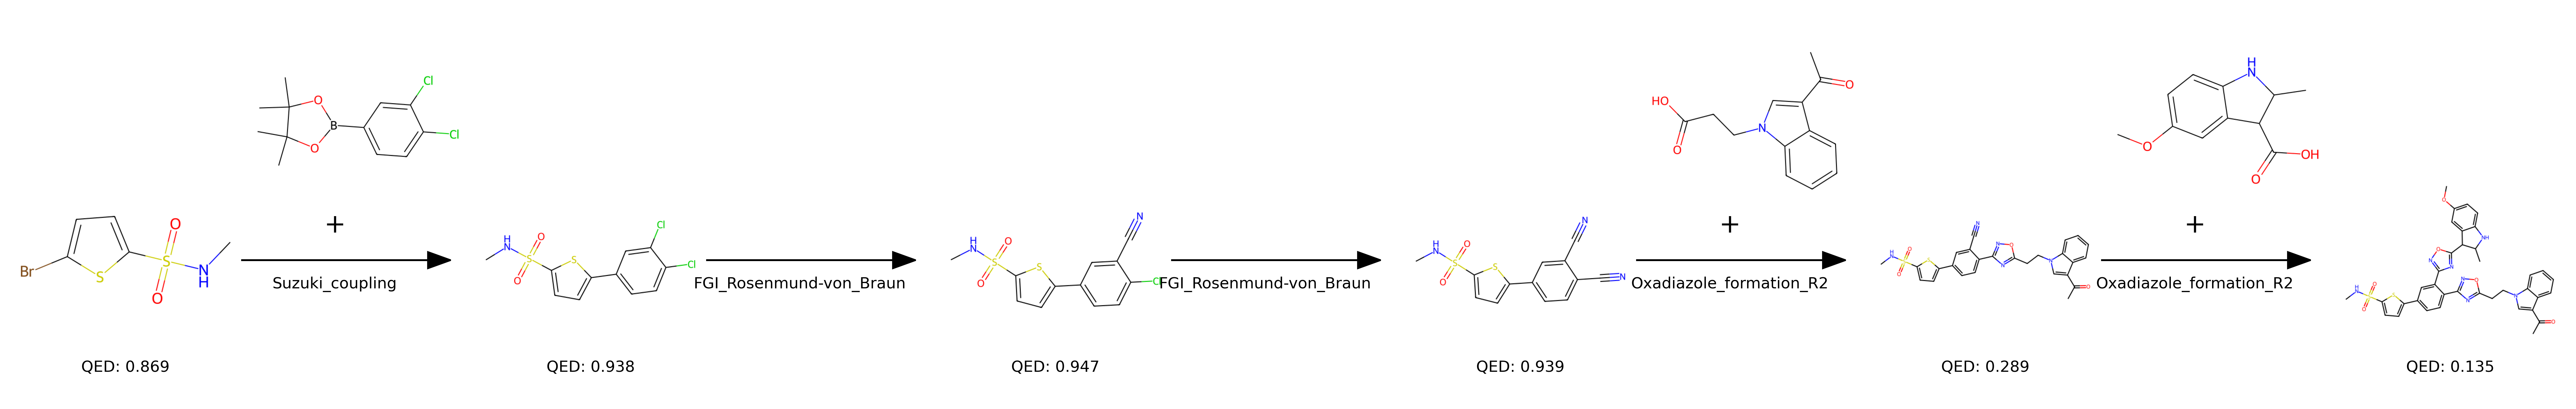

In [24]:
draw_path(randomsearch_results, 2089)

In [25]:
# display path with highest qed
print_path(randomsearch_results, 2952)

Synthesis Path ID: 2952
Step 0:
  Reactant: O=C(O)c1cnoc1-c1ccccc1F | Name: 5-(2-fluorophenyl)-1,2-oxazole-4-carboxylic acid
  Template: nan
  Product: O=C(O)c1cnoc1-c1ccccc1F | Name: 5-(2-fluorophenyl)-1,2-oxazole-4-carboxylic acid
  QED Score: 0.819
----------------------------------------
Step 1:
  Reactant: O=C(O)c1cnoc1-c1ccccc1F | Name: 5-(2-fluorophenyl)-1,2-oxazole-4-carboxylic acid
  Second Reactant: N[C@H]1C[C@H](CF)C1 | Name: 3-(fluoromethyl)cyclobutan-1-amine
  Template: Amide_formation
  Product: O=C(N[C@H]1C[C@H](CF)C1)c1cnoc1-c1ccccc1F | Name: Molecule not in PubChem Database
  QED Score: 0.942
----------------------------------------


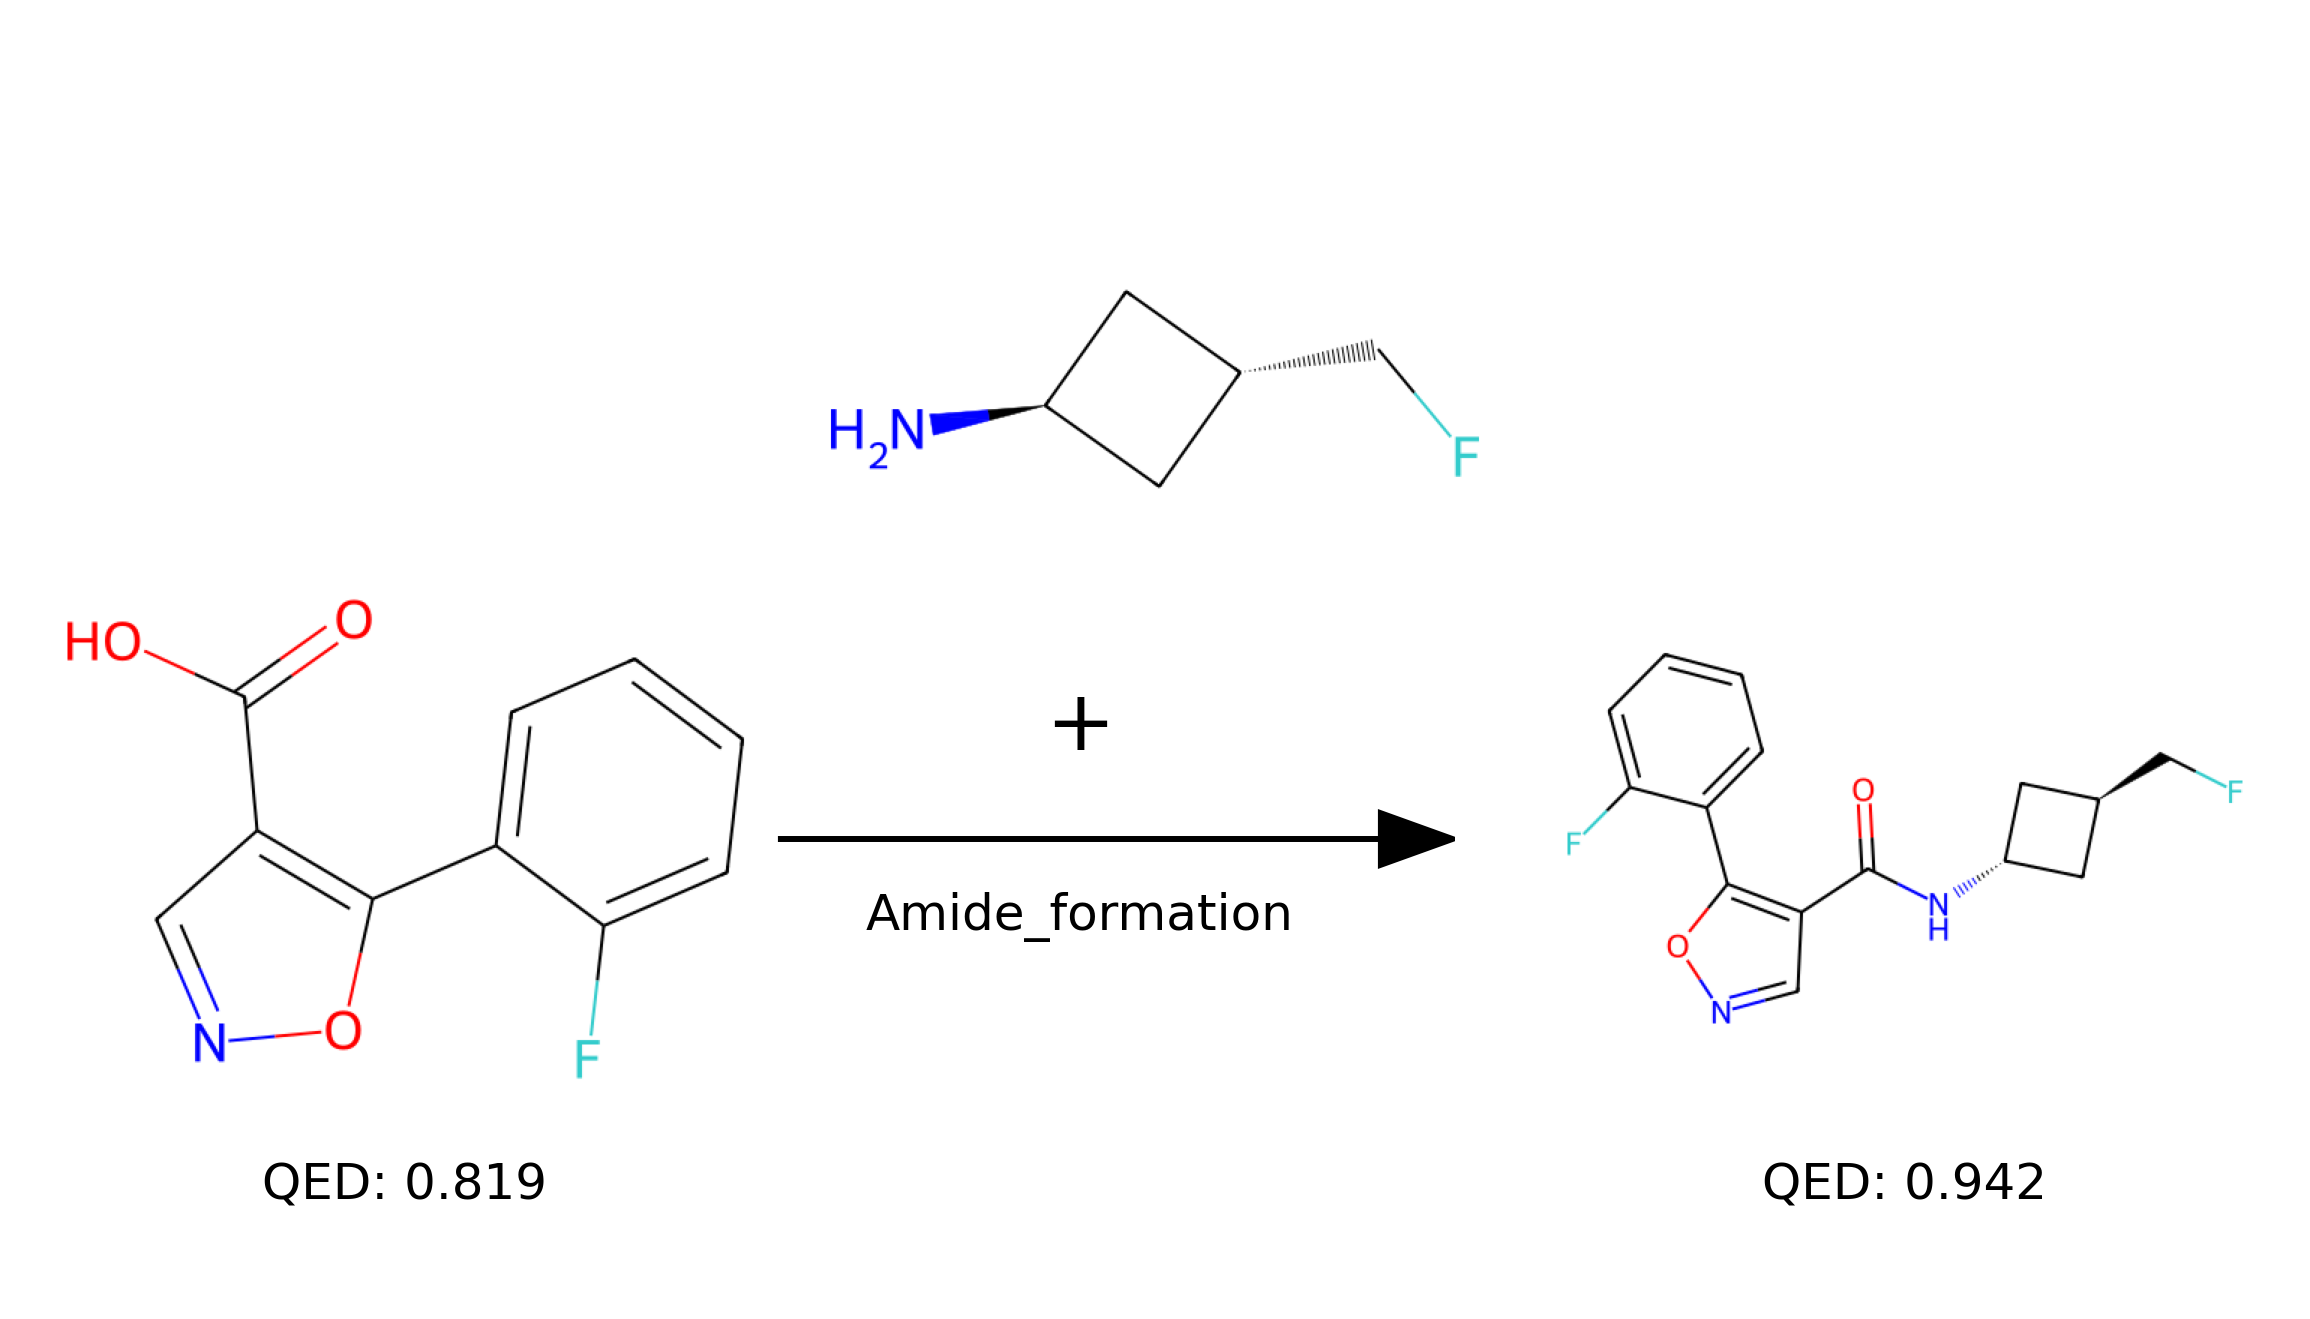

In [26]:
# synthesis path for molecule with highest qed
draw_path(randomsearch_results, 2952)

In [27]:
# display path with high qed
print_path(randomsearch_results, 3349)

Synthesis Path ID: 3349
Step 0:
  Reactant: CC(C)C(O)c1ccc2c(c1)CCCC2 | Name: 2-methyl-1-(5,6,7,8-tetrahydronaphthalen-2-yl)propan-1-ol
  Template: nan
  Product: CC(C)C(O)c1ccc2c(c1)CCCC2 | Name: 2-methyl-1-(5,6,7,8-tetrahydronaphthalen-2-yl)propan-1-ol
  QED Score: 0.784
----------------------------------------
Step 1:
  Reactant: CC(C)C(O)c1ccc2c(c1)CCCC2 | Name: 2-methyl-1-(5,6,7,8-tetrahydronaphthalen-2-yl)propan-1-ol
  Template: FGI_chlorination
  Product: CC(C)C(Cl)c1ccc2c(c1)CCCC2 | Name: 6-(1-chloro-2-methylpropyl)-1,2,3,4-tetrahydronaphthalene
  QED Score: 0.647
----------------------------------------
Step 2:
  Reactant: CC(C)C(Cl)c1ccc2c(c1)CCCC2 | Name: 6-(1-chloro-2-methylpropyl)-1,2,3,4-tetrahydronaphthalene
  Second Reactant: OC[C@@H](O)c1c[nH]nn1 | Name: (1S)-1-(2H-triazol-4-yl)ethane-1,2-diol
  Template: Williamson_ether
  Product: CC(C)C(O[C@H](CO)c1c[nH]nn1)c1ccc2c(c1)CCCC2 | Name: Molecule not in PubChem Database
  QED Score: 0.859
---------------------------------

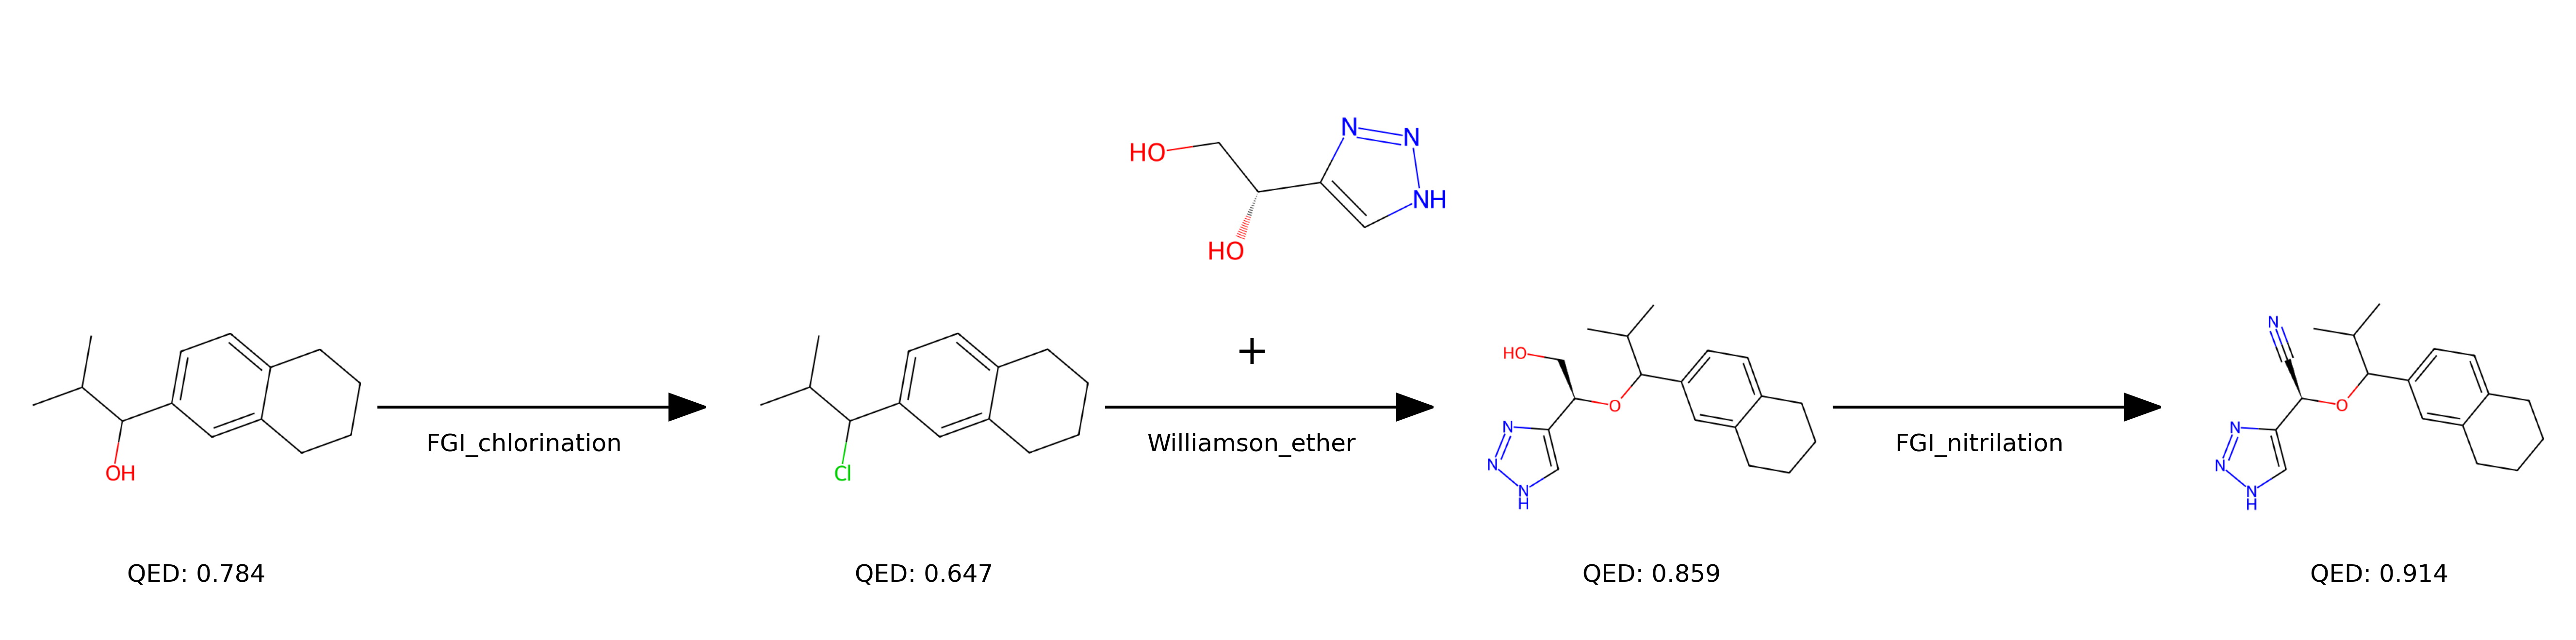

In [28]:
draw_path(randomsearch_results, 3349)

In [29]:
# display path with lowest qed
print_path(randomsearch_results, 1453)

Synthesis Path ID: 1453
Step 0:
  Reactant: Cc1sc2[nH]c(-c3ccc(C(=O)O)cc3)nc(=N)c2c1C | Name: 4-(4-amino-5,6-dimethylthieno[2,3-d]pyrimidin-2-yl)benzoic acid
  Template: nan
  Product: Cc1sc2[nH]c(-c3ccc(C(=O)O)cc3)nc(=N)c2c1C | Name: 4-(4-amino-5,6-dimethylthieno[2,3-d]pyrimidin-2-yl)benzoic acid
  QED Score: 0.679
----------------------------------------
Step 1:
  Reactant: Cc1sc2[nH]c(-c3ccc(C(=O)O)cc3)nc(=N)c2c1C | Name: 4-(4-amino-5,6-dimethylthieno[2,3-d]pyrimidin-2-yl)benzoic acid
  Second Reactant: CC(C)(C)[Si](C)(C)OCCOCCOCCI | Name: tert-butyl-[2-[2-(2-iodoethoxy)ethoxy]ethoxy]-dimethylsilane
  Template: Ketone_formation_R2
  Product: Cc1sc2[nH]c(-c3ccc(C(=O)CCOCCOCCO[Si](C)(C)C(C)(C)C)cc3)nc(=N)c2c1C | Name: Molecule not in PubChem Database
  QED Score: 0.17
----------------------------------------
Step 2:
  Reactant: Cc1sc2[nH]c(-c3ccc(C(=O)CCOCCOCCO[Si](C)(C)C(C)(C)C)cc3)nc(=N)c2c1C | Name: Molecule not in PubChem Database
  Second Reactant: CC(C)(C)OC(=O)[C@@H](N)CS | Nam

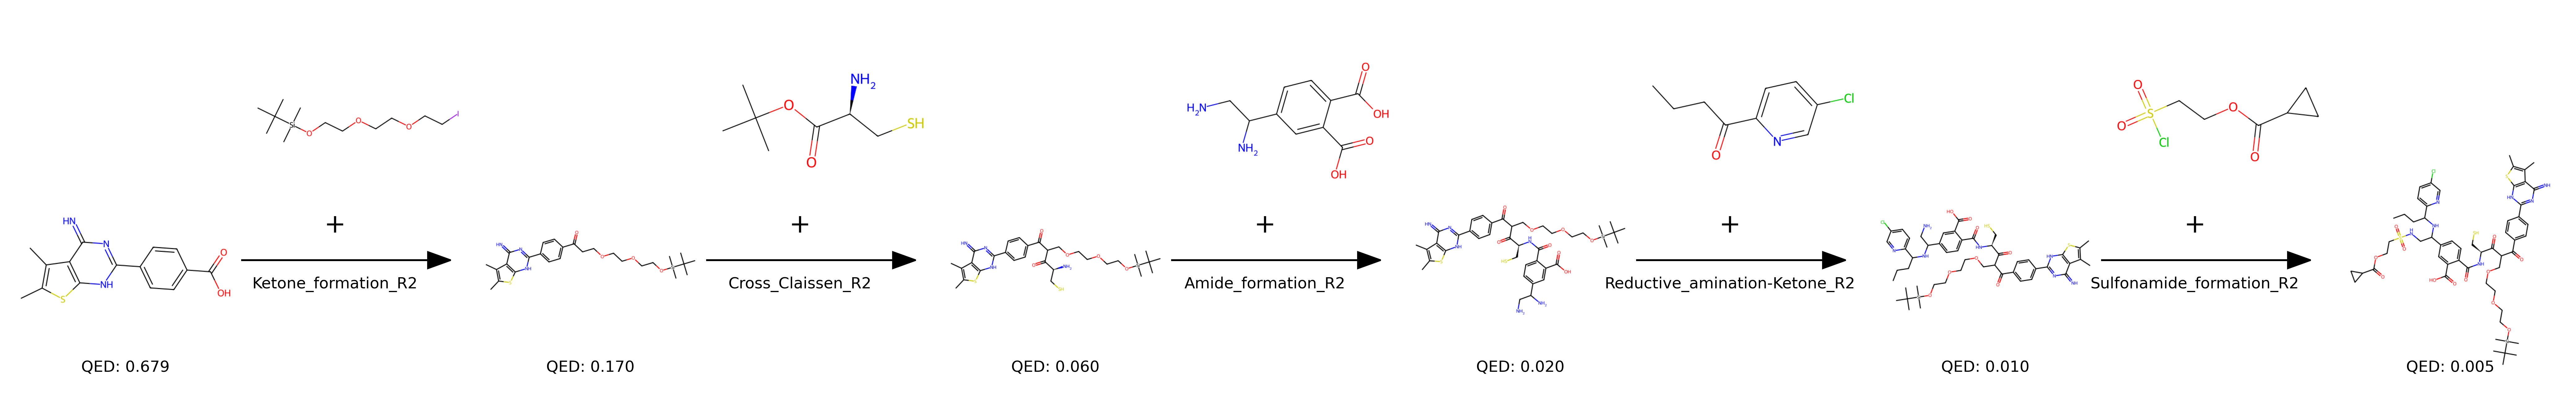

In [30]:
# Synthesis path with lowest qed
draw_path(randomsearch_results, 1453)

In [31]:
# Paths that achieved the max number of steps (5)
last_steps[last_steps["step"]==5].sort_values(by='qed', ascending=False).head(10)

step                                           reactant  \
path_id path_id                                                            
403     403         5  N#CCC1CCC2N=NN(C3CCC(CCNC(c4cccnc4)C4CCNCC4)CC...   
4199    4199        5  CCOC(=O)c1n[nH]c(C(CS)C(C)(C)N2N=NC3CN(C(C)C)C...   
1807    1807        5                 Cc1cc(C)c2c(n1)CCC(C(=O)C1CC1)C2=O   
4603    4603        5  CC1(c2ccccc2)CC1(N)C(=O)OCC1(CC=CC2(C(=O)OC3CC...   
2832    2832        5  Cc1ccc2nc(CC3(COC4(C)CCCC4N4N=NC5C[C@@H](C(=O)...   
2895    2895        5  CC1(C)N=NN(C2CC(CCNS(=O)(=O)C(Cl)CCl)CCC2c2cnc...   
5774    5774        5  O=C(OCCS(=O)(=O)Nc1cc(S(=O)(=O)O)ccc1Oc1ccc(OC...   
3024    3024        5  CCCCCCCCC(CCc1nc2c(C#N)cc(F)cc2c(=O)n1Cc1cc(OC...   
983     983         5                         O=C(O)C1(C(=O)C2CC2)CCCC1O   
3759    3759        5  Cc1cc(C)c2c(n1)CCCC2N1CCCCC(CN2N=NC3(C)CCCC(OC...   

                                                         template  \
path_id path_id                                                     
403     403      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
4199    4199     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1807    1807                                    Cross_Claissen_R2   
4603    4603                                       Cross_Claissen   
2832    2832     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
2895    2895     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
5774    5774                                       Cross_Claissen   
3024    3024                                       Cross_Claissen   
983     983                                   Williamson_ether_R2   
3759    3759                                       Cross_Claissen   

                                                           product    qed  \
path_id path_id                                                             
403     403                      CC1CC2C(CC1CO)N=NN2C1CCC(CC#N)CC1  0.868   
4199    4199                     CC(C)N1CCC(N2N=NC3CC(CCN)CCC32)C1  0.856   
1807    1807     Cc1cc(C)c2c(n1)CCC(C(=O)C1(C(=O)C3CCNCC3)CC1)C2=O  0.840   
4603    4603     CCN1C(=O)C(C(=O)C2(N)CC2(C)c2ccccc2)Cc2c(O)cccc21  0.817   
2832    2832     NCCC1CC2N=NN(C3CC[C@@H](C(F)(F)F)[C@H](C(=O)O)...  0.817   
2895    2895                         CC(C)(CCS)N1N=NC2CCCCCC(N)C21  0.775   
5774    5774     O=C(C1CC1)C1C(=O)N(Cc2ccccc2)C[C@@H](C(=O)O)[C...  0.762   
3024    3024      O=C(O)[C@@]1(C(=O)CC2CC3CCC2C3)CNC[C@H]1C1CCCCC1  0.758   
983     983                      O=C(O)C1(C(=O)C2CC2)CCCC1OC1CCNC1  0.726   
3759    3759       CNCCN(C)C(=O)CC(=O)[C@H](C(C)C)n1cnc2ccccc2c1=O  0.718   

                                                   second_reactant  
path_id path_id                                                     
403     403                                           CC1CC=CCC1CO  
4199    4199                                          NCCC1CC=CCC1  
1807    1807                                  CC(CN)OC(=O)C1CCNCC1  
4603    4603                               CCN1C(=O)CCc2c(O)cccc21  
2832    2832                                           NCCC1CC=CC1  
2895    2895                                        NC1/C=C\CCCCC1  
5774    5774     O=C(O)[C@@H]1CN(Cc2ccccc2)C(=O)C[C@H]1c1ccc(F)cc1  
3024    3024                        O=C(O)[C@@H]1CNC[C@H]1C1CCCCC1  
983     983                                              BrC1CCNC1  
3759    3759                                        CNCCN(C)C(C)=O

In [32]:
# display path with lowest qed
print_path(randomsearch_results, 403)

Synthesis Path ID: 403
Step 0:
  Reactant: C=C(CC)CN=[N+]=[N-] | Name: 2-(azidomethyl)but-1-ene
  Template: nan
  Product: C=C(CC)CN=[N+]=[N-] | Name: 2-(azidomethyl)but-1-ene
  QED Score: 0.232
----------------------------------------
Step 1:
  Reactant: C=C(CC)CN=[N+]=[N-] | Name: 2-(azidomethyl)but-1-ene
  Second Reactant: NCCC1CC=CCC1 | Name: 2-cyclohex-3-en-1-ylethanamine
  Template: Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2
  Product: C=C(CC)CN1N=NC2CCC(CCN)CC21 | Name: Molecule not in PubChem Database
  QED Score: 0.746
----------------------------------------
Step 2:
  Reactant: C=C(CC)CN1N=NC2CCC(CCN)CC21 | Name: Molecule not in PubChem Database
  Second Reactant: O=C(c1cccnc1)C1CCNCC1 | Name: piperidin-4-yl(pyridin-3-yl)methanone
  Template: Reductive_amination-Ketone_R2
  Product: C=C(CC)CN1N=NC2CCC(CCNC(c3cccnc3)C3CCNCC3)CC21 | Name: Molecule not in PubChem Database
  QED Score: 0.596
----------------------------------------
Step 3:
  Reactant: C=C(CC)CN1N=NC2CCC(CCN

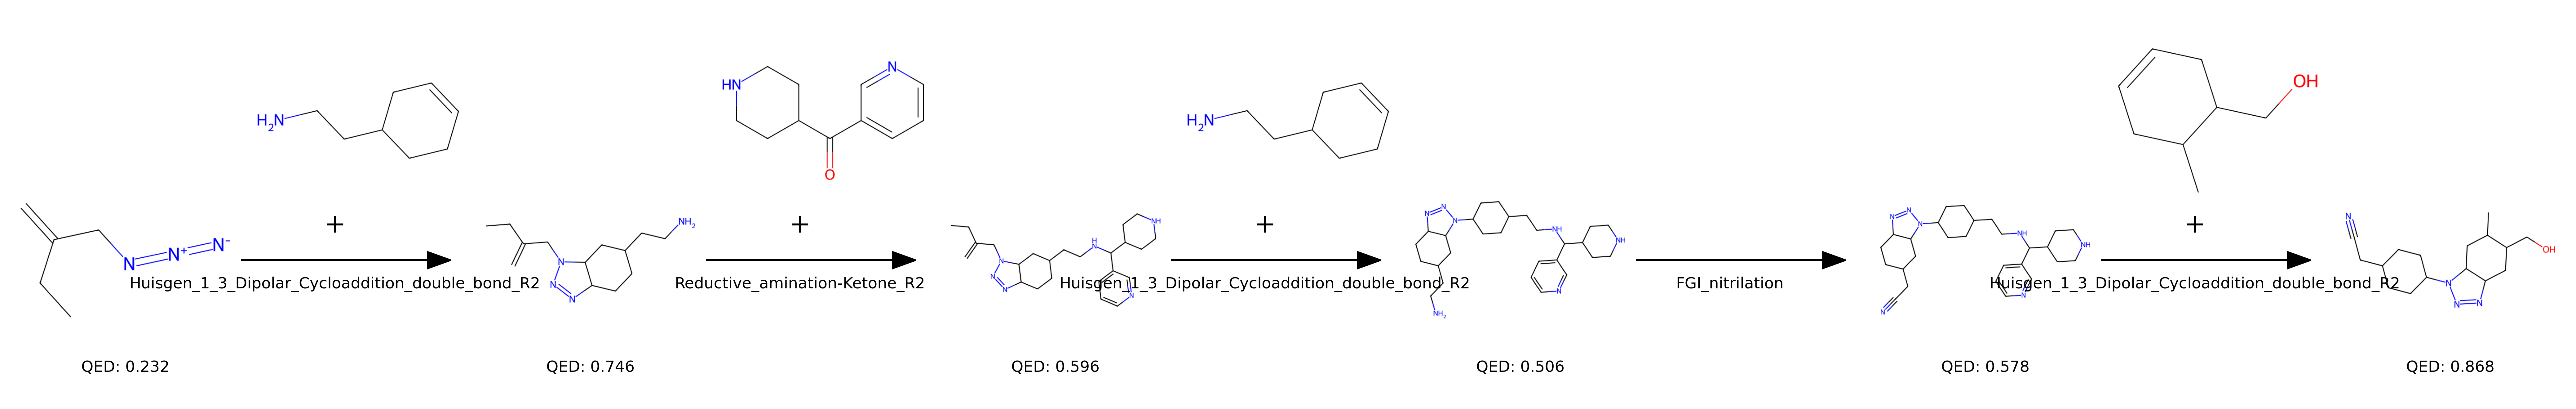

In [33]:
# Synthesis path
draw_path(randomsearch_results, 403)

## Data Analysis

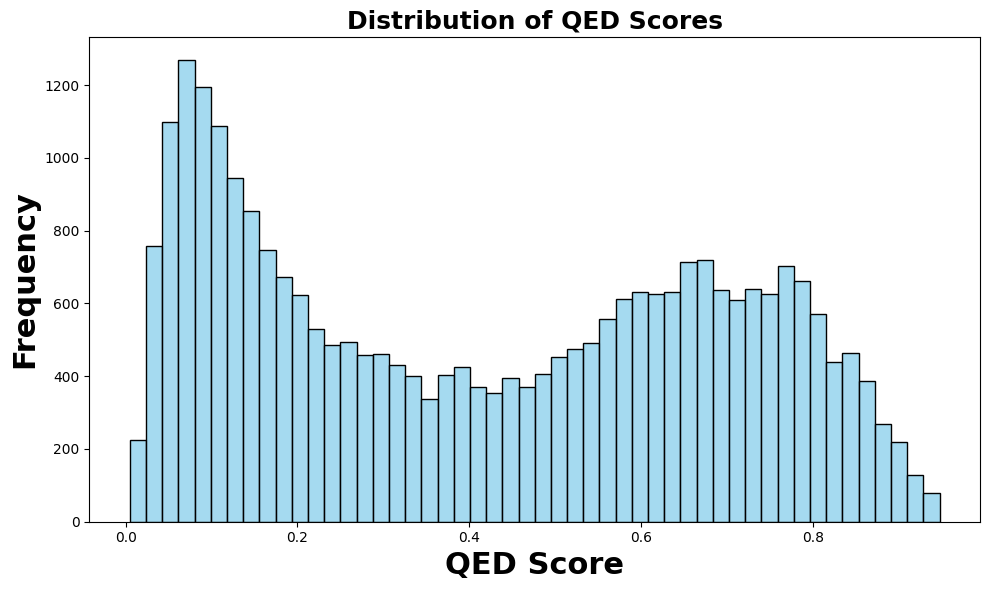

In [36]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(randomsearch_results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=18, fontweight='bold')
plt.xlabel('QED Score', fontsize=22, fontweight='bold')
plt.ylabel('Frequency', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

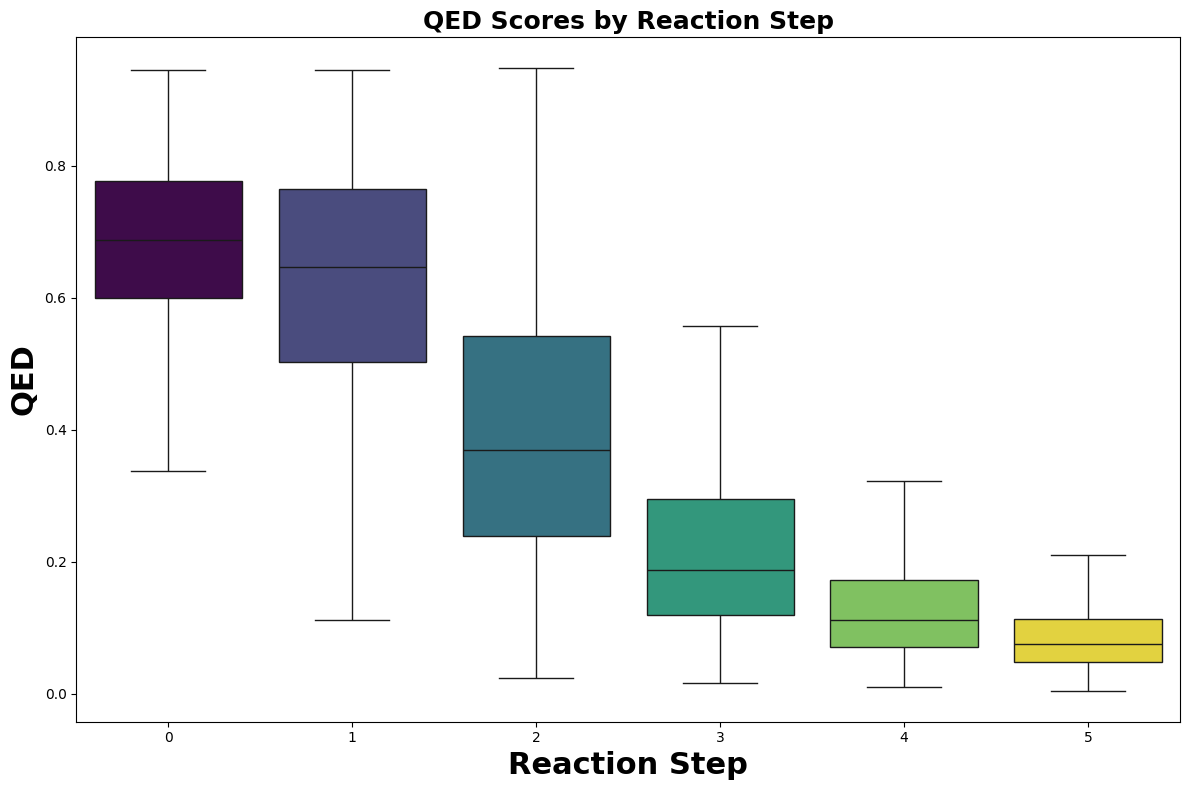

In [37]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=randomsearch_results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=22, fontweight='bold')
plt.ylabel('QED', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

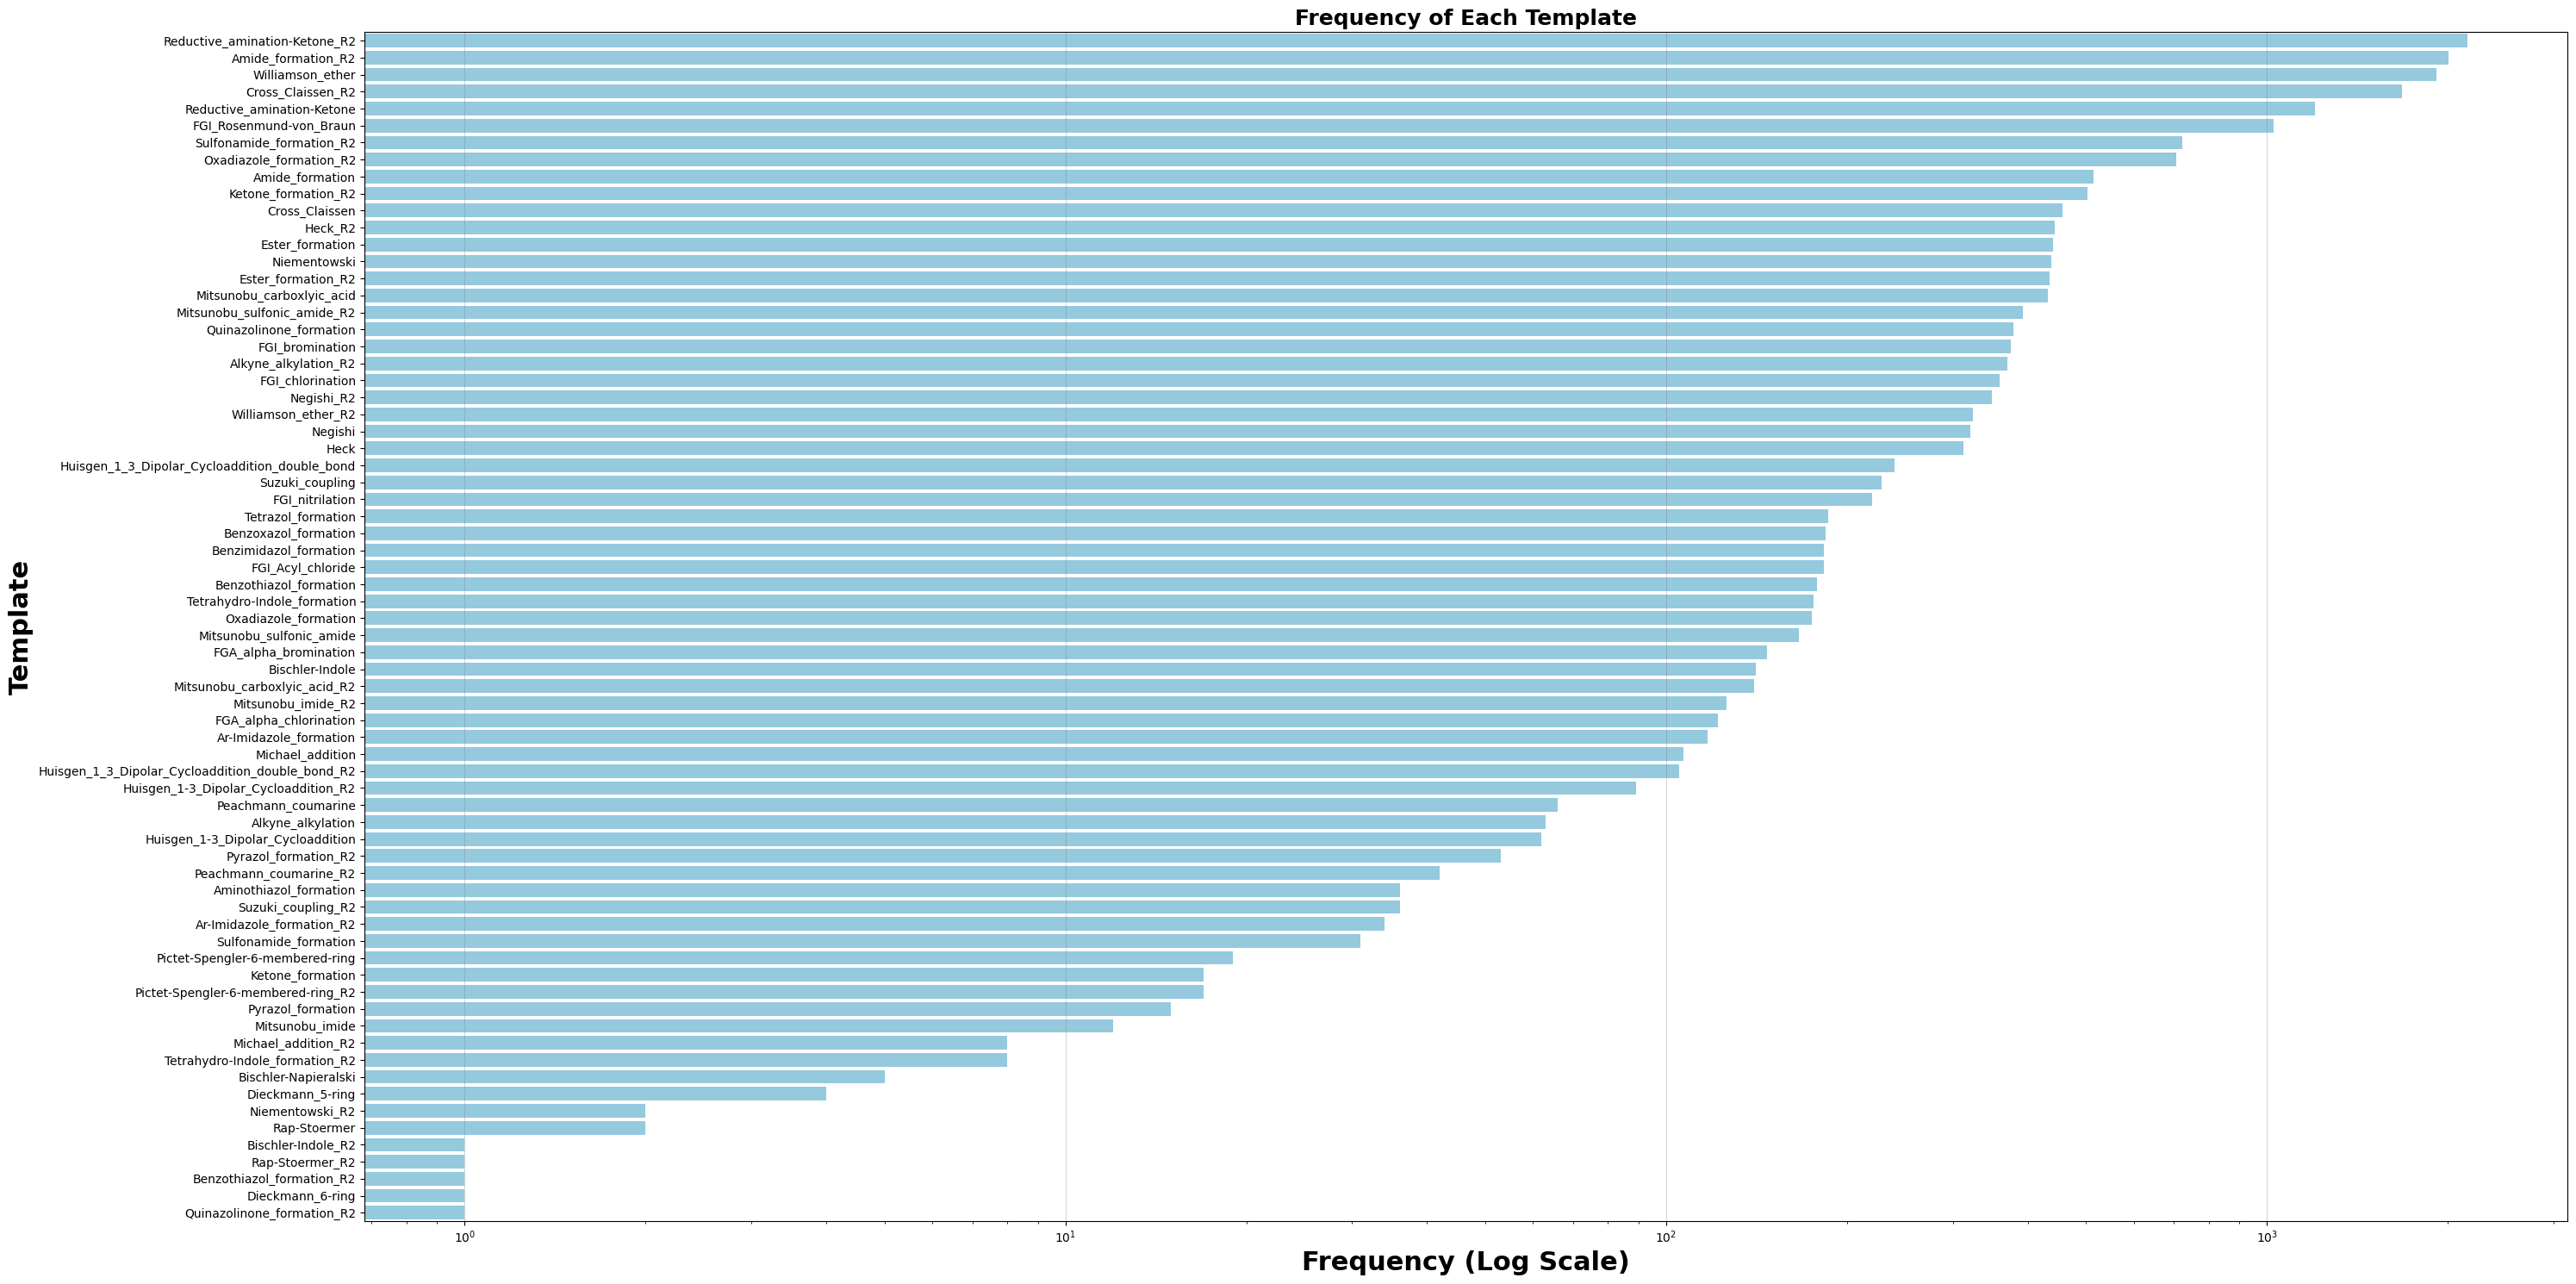

In [39]:
# Calculate frequency of each template
template_frequency = randomsearch_results['template'].value_counts().reset_index()
template_frequency.columns = ['template', 'frequency']

# Create horizontal bar plot with log scale for frequency
plt.figure(figsize=(30, 15))
sns.barplot(y='template', x='frequency', data=template_frequency, color='skyblue')
plt.xscale('log')
plt.title('Frequency of Each Template', fontsize=18, fontweight='bold')
plt.xlabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.ylabel('Template', fontsize=22, fontweight='bold')
# Add faint grey grid lines
plt.grid(color='grey', linestyle='-', linewidth=0.5, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

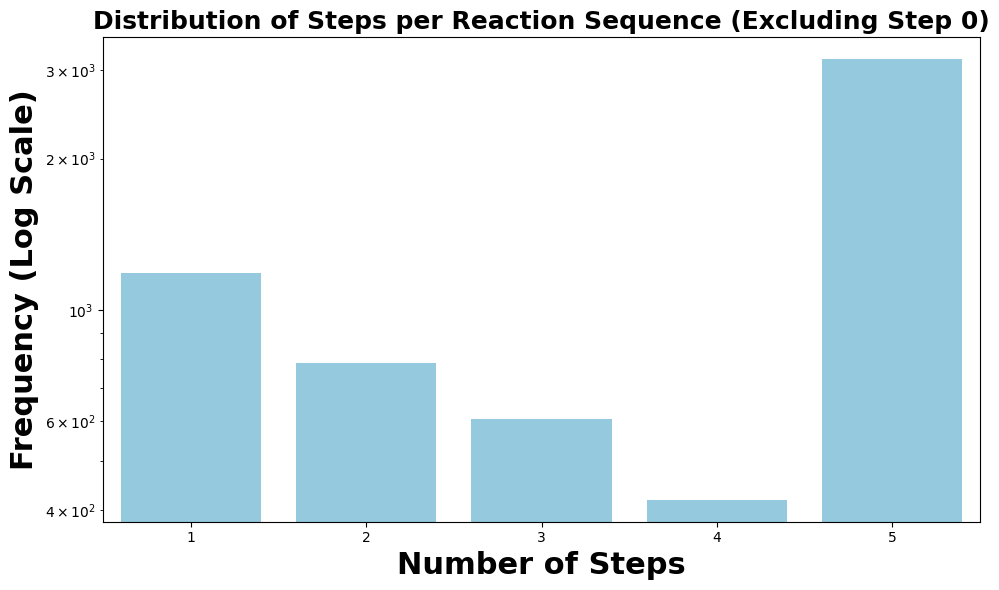

In [40]:
# Filter out step 0
df_filtered = randomsearch_results[randomsearch_results['step'] != 0]

# Calculate the number of steps per reaction sequence
steps_per_sequence = df_filtered.groupby('path_id')['step'].max()

# Calculate the frequency of each number of steps
steps_frequency = steps_per_sequence.value_counts().sort_index()

# Create a bar chart with log scale for frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=steps_frequency.index, y=steps_frequency.values, color='skyblue')
plt.yscale('log')
plt.title('Distribution of Steps per Reaction Sequence (Excluding Step 0)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Steps', fontsize=22, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1922726/1185886409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["reactant"] = data['reactant'].apply(get_compound_name)


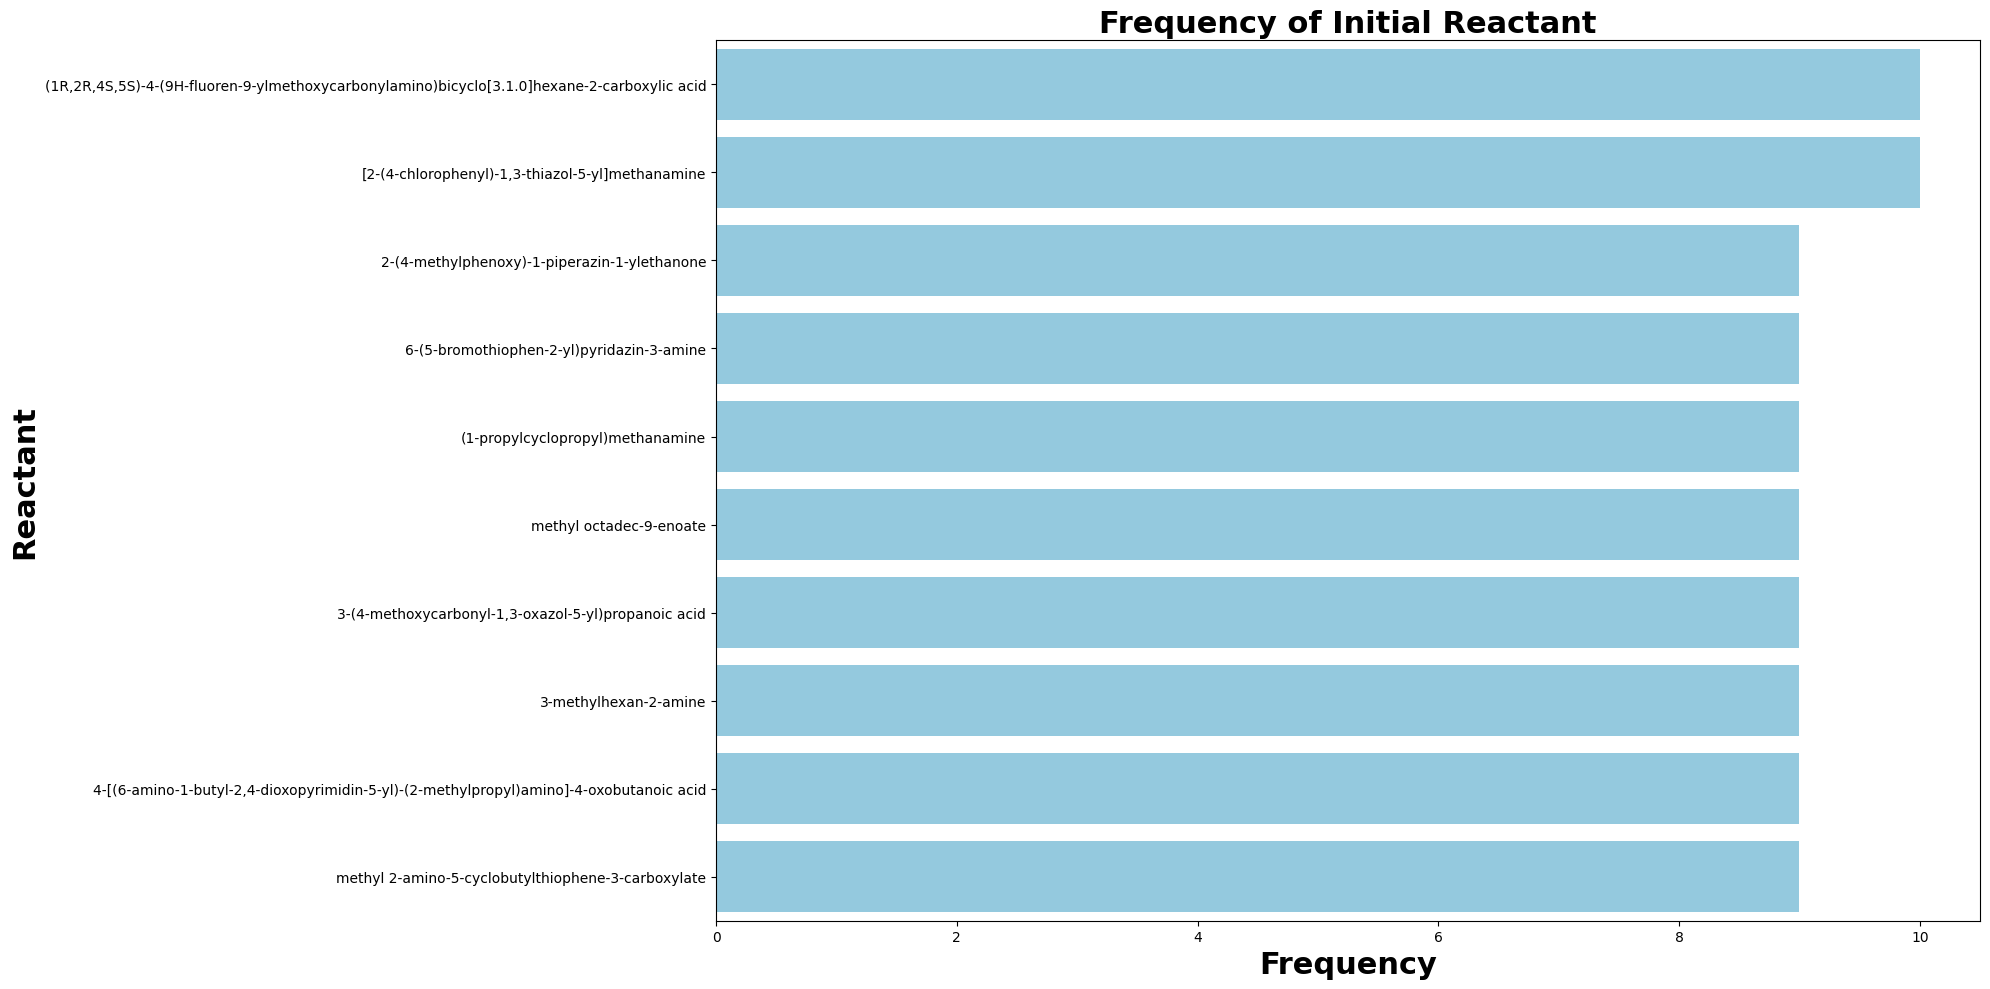

In [41]:
# Filter the DataFrame for step 0
df_step_0 = randomsearch_results[randomsearch_results['step'] == 0]

# Calculate the frequency of each combined reactant
reactant_frequency_step_0 = df_step_0['reactant'].value_counts().reset_index()
reactant_frequency_step_0.columns = ['reactant', 'frequency']
data = reactant_frequency_step_0.head(10)
data["reactant"] = data['reactant'].apply(get_compound_name)

# Create a horizontal bar chart
plt.figure(figsize=(20, 10))
sns.barplot(y='reactant', x='frequency', data=data, color='skyblue')
#plt.xscale('log')
plt.title('Frequency of Initial Reactant', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=22, fontweight='bold')
plt.ylabel('Reactant', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# Random search: 30hrs

In [16]:
randomsearch_results_30 = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/src/models/rsearch/results/Rmolsearch_results.csv", index_col=0)
randomsearch_results_30.describe()

step            qed
count  512046.000000  512046.000000
mean        2.079483       0.419447
std         1.657221       0.272882
min         0.000000       0.004000
25%         1.000000       0.147000
50%         2.000000       0.416000
75%         3.000000       0.666000
max         5.000000       0.948000

In [17]:
randomsearch_results_30.head(10)

step                                           reactant  \
path_id                                                            
0           0                                Cc1cccc(CC(=O)Cl)c1   
0           1                                Cc1cccc(CC(=O)Cl)c1   
0           2                         Cc1cccc(CC(=O)CC2CCCCC2)c1   
0           3  COC(=O)C(N)C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCC...   
0           4  COC(=O)C(C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCCCC...   
0           5  COC(=O)C(C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCCCC...   
1           0                                    OC1CN=C(CCl)NC1   
1           1                                    OC1CN=C(CCl)NC1   
1           2           Cc1ccccc1-n1ncc(C(=O)OC2CN=C(CCl)NC2)c1N   
1           3  C=CCCCS(=O)(=O)Nc1c(C(=O)OC2CN=C(CCl)NC2)cnn1-...   

                         template  \
path_id                             
0                             NaN   
0             Ketone_formation_R2   
0               Cross_Claissen_R2   
0         Quinazolinone_formation   
0         FGI_Rosenmund-von_Braun   
0         Oxadiazole_formation_R2   
1                             NaN   
1              Ester_formation_R2   
1        Sulfonamide_formation_R2   
1                            Heck   

                                                   product    qed  \
path_id                                                             
0                                      Cc1cccc(CC(=O)Cl)c1  0.620   
0                               Cc1cccc(CC(=O)CC2CCCCC2)c1  0.761   
0        COC(=O)C(N)C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCC...  0.535   
0        COC(=O)C(C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCCCC...  0.234   
0        COC(=O)C(C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCCCC...  0.261   
0        COC(=O)C(C1CC(C(=O)C(C(=O)Cc2cccc(C)c2)C2CCCCC...  0.127   
1                                          OC1CN=C(CCl)NC1  0.497   
1                 Cc1ccccc1-n1ncc(C(=O)OC2CN=C(CCl)NC2)c1N  0.646   
1        C=CCCCS(=O)(=O)Nc1c(C(=O)OC2CN=C(CCl)NC2)cnn1-...  0.234   
1        C=C(CCCS(=O)(=O)Nc1c(C(=O)OC2CN=C(CCl)NC2)cnn1...  0.195   

                           second_reactant  
path_id                                     
0                                      NaN  
0                               ICC1CCCCC1  
0        COC(=O)C(N)C1CC(C(=O)OC(C)(C)C)C1  
0                   Nc1c(Cl)cc(F)cc1C(=O)O  
0                                      NaN  
0            COC(=O)[C@H]1C[C@H](C(=O)O)C1  
1                                      NaN  
1               Cc1ccccc1-n1ncc(C(=O)O)c1N  
1                        C=CCCCS(=O)(=O)Cl  
1                 N#Cc1ccc(C(=O)O)c(Br)c1F

In [18]:
randomsearch_results_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512046 entries, 0 to 112045
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   step             512046 non-null  int64  
 1   reactant         512046 non-null  object 
 2   template         400000 non-null  object 
 3   product          512046 non-null  object 
 4   qed              512046 non-null  float64
 5   second_reactant  353101 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.3+ MB


In [19]:
# Number of paths
len(randomsearch_results_30.index.unique())

112046

In [20]:
# Molecules with the highest qed regardless of max steps
randomsearch_results_30[randomsearch_results_30["qed"]==0.948]

step                   reactant            template  \
path_id                                                        
46111       1  Cc1cc(C)n(-c2ccc(N)cc2)n1  Amide_formation_R2   
108630      1   Cc1c(C(=O)O)c(C(F)F)nn1C     Amide_formation   

                                                   product    qed  \
path_id                                                             
46111    Cc1cc(C)n(-c2ccc(NC(=O)[C@@H]3CCN(C)[C@@H]3C)c...  0.948   
108630                 Cc1nc(NC(=O)c2c(C(F)F)nn(C)c2C)sc1C  0.948   

                    second_reactant  
path_id                              
46111    C[C@@H]1[C@H](C(=O)O)CCN1C  
108630                 Cc1nc(N)sc1C

In [21]:
# Paths that achieved the max number of steps (5)
randomsearch_results_30[randomsearch_results_30["step"]==5].sort_values(by='qed', ascending=False)

step                                           reactant  \
path_id                                                            
111455      5            CCC1(Cc2ccc(OC3(CN)CN4CCC3CC4)nc2)CCCN1   
55891       5         C[C@@H]1[C@H](C(=O)C(C)(C=O)C(C)(C)C)CCN1C   
45133       5  CCCCCCCCC(C(CCCCCCCC(=O)OC)c1cccc(CN(CCc2ccccc...   
21620       5  C=C(C1CCCC(C)(N2N=NC3CC(CO)C(C)CC32)C1C)[C@@H]...   
33338       5  CC(Cc1ccccc1F)C(=O)N1CC2(CCC(c3ccoc3S(=O)(=O)C...   
...       ...                                                ...   
51142       5  C=C1C[C@]23C[C@@]1(O)CC[C@@H]2[C@@]12CC(C(Cc4c...   
70361       5  CCOC(=O)C(C(=O)[C@]1(C(=O)Sc2nc3scc(-c4ccc(F)c...   
67941       5  CCOC(=O)c1ccc(Oc2ccc(N=Nc3ccccc3C(=O)CCOCCOCCO...   
66608       5  CCOc1cc(C=O)c(Cl)cc1OCC(=O)C(Cc1ccc(F)cc1)C(=O...   
102641      5  C=C(CCCS(=O)(=O)Nc1cccc(-c2ccc(C(=O)NN)cc2)c1)...   

                                                 template  \
path_id                                                     
111455                                    FGI_nitrilation   
55891                  Pictet-Spengler-6-membered-ring_R2   
45133    Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
21620    Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
33338    Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
...                                                   ...   
51142                                Benzoxazol_formation   
70361                                      Cross_Claissen   
67941                                    Williamson_ether   
66608                                    Michael_addition   
102641                                            Heck_R2   

                                                   product    qed  \
path_id                                                             
111455            CCC1(Cc2ccc(OC3(C#N)CN4CCC3CC4)nc2)CCCN1  0.892   
55891    C[C@@H]1[C@H](C(=O)C(C)(C2NCC3COc4cccc2c43)C(C...  0.879   
45133             CC(=O)C1CCC2(C)N=NN(C3CCC(CO)C(C)C3)C2C1  0.871   
21620                CC(=O)C1CCC2N=NN(C3CCC(C)C(CO)C3)C2C1  0.870   
33338              CC(C)N1CCC(N2N=NC3(CC(C)(C)O)CCCCC23)C1  0.868   
...                                                    ...    ...   
51142    C=C1C[C@]23C[C@@]1(O)CC[C@@H]2[C@@]12CC(C(Cc4c...  0.005   
70361    COC(=O)[C@]1(C(=O)C(Cc2nc[nH]n2)NC(C)=O)CCC[C@...  0.005   
67941    CCOC(=O)c1ccc(Oc2ccc(N=Nc3ccccc3C(=O)CCOCCOCCO...  0.005   
66608    CCOc1cc(C=O)c(Cl)cc1OCC(=O)C(Cc1ccc(F)cc1)(C(=...  0.005   
102641   C=C(CCCS(=O)(=O)Nc1cccc(-c2ccc(C(=O)NN)cc2)c1)...  0.004   

                                           second_reactant  
path_id                                                     
111455                                                 NaN  
55891                                      NCC1COc2ccccc21  
45133                                   CC(=O)C1CC=C(C)CC1  
21620                                      CC(=O)C1CC=CCC1  
33338                                   CC(C)(O)CC1=CCCCC1  
...                                                    ...  
51142                              Nc1cc(F)c(C(F)(F)F)cc1O  
70361                 O=C(O)CCc1cc(I)c(Oc2ccc(O)cc2)c(I)c1  
67941                                   ON=C(O)c1ccc(O)cc1  
66608    O=C1N[C@@H]2CCCC[C@H]2NC(=O)C2(C/C=C\COc3ccccc...  
102641                           CCCCCCCCC=CCCCCCCCC(=O)OC  

[57084 rows x 6 columns]

In [22]:
# Group by path_id and find the last step for each path
last_steps = randomsearch_results_30.loc[randomsearch_results_30.groupby('path_id')['step'].idxmax()]

# Find the maximum QED value from the last steps of each path
max_qed_value = last_steps['qed'].max()

max_qed_value

0.948

In [23]:
last_steps.sort_values(by='qed', ascending=False).head(30)

step                         reactant                       template  \
path_id                                                                         
108630      1         Cc1c(C(=O)O)c(C(F)F)nn1C                Amide_formation   
46111       1        Cc1cc(C)n(-c2ccc(N)cc2)n1             Amide_formation_R2   
44989       1                NCc1ccc2c(c1)OCO2             Amide_formation_R2   
54450       1              O=C(O)C1CCC12CCOCC2         Benzimidazol_formation   
32951       1           CNS(=O)(=O)c1ccc(Br)s1                Suzuki_coupling   
38866       1         c1n[nH]c([C@@H]2CCCN2)n1  Reductive_amination-Ketone_R2   
68857       1           CNS(=O)(=O)c1ccc(Br)s1                Suzuki_coupling   
64877       1             Cc1nc(C)c(CC(=O)O)s1                Amide_formation   
8725        1              O=C(O)C1CCC12CCOCC2         Benzimidazol_formation   
98065       1              CNc1cc(C(C)C)[nH]n1             Amide_formation_R2   
67380       1              Nc1ccnc(C(F)(F)F)n1  Reductive_amination-Ketone_R2   
57440       1            Cc1nc(C(F)(F)F)ncc1Br                     Negishi_R2   
18635       1        FC(F)(F)c1ccc2nnc(Br)n2c1                        Heck_R2   
21099       1           CNS(=O)(=O)c1ccc(Br)s1                     Negishi_R2   
3609        1                     CC1CCC(N)CN1        Quinazolinone_formation   
35697       1                     CC1CCC(N)CN1        Quinazolinone_formation   
99962       1                     CC1CCC(N)CN1        Quinazolinone_formation   
48916       1                     CC1CCC(N)CN1        Quinazolinone_formation   
68196       2           CS(=O)(=O)c1cccc(Br)c1                     Negishi_R2   
107368      1                     CC1CCC(N)CN1        Quinazolinone_formation   
31624       1           NC[C@]1(F)C[C@H](CO)C1        Quinazolinone_formation   
73407       1              O=C1NCCNC1c1ccccc1F  Reductive_amination-Ketone_R2   
97633       1             Cc1nn(C)c(C)c1C(=O)O                Amide_formation   
27453       1                       FCC1CCNCC1             Amide_formation_R2   
47183       1             Nc1cccc(-c2cccnc2)c1             Amide_formation_R2   
41107       1             Cc1c(I)c(C(=O)O)nn1C                     Negishi_R2   
25081       1        CC(C)(C)NS(=O)(=O)CC(=O)O         Benzothiazol_formation   
81584       1               Fc1ccc2c(c1F)CNCC2  Reductive_amination-Ketone_R2   
91553       1             CCC1NCCC1c1ccc(C)cc1             Amide_formation_R2   
2497        2  Clc1cc(Cl)c2c(c1)OCCC2NCc1nccs1        FGI_Rosenmund-von_Braun   

                                                   product    qed  \
path_id                                                             
108630                 Cc1nc(NC(=O)c2c(C(F)F)nn(C)c2C)sc1C  0.948   
46111    Cc1cc(C)n(-c2ccc(NC(=O)[C@@H]3CCN(C)[C@@H]3C)c...  0.948   
44989                   O=C(NCc1ccc2c(c1)OCO2)C1Cc2cscc2C1  0.947   
54450               CCn1c(C2CCC23CCOCC3)nc2cc(C(N)=O)ccc21  0.947   
32951                  CNS(=O)(=O)c1ccc(-c2cccc3c2CCOC3)s1  0.947   
38866                  Clc1nsc(CN2CCC[C@H]2c2ncn[nH]2)c1Cl  0.947   
68857                  CNS(=O)(=O)c1ccc(-c2cccc3c2CCOC3)s1  0.947   
64877                Cc1nc(C)c(CC(=O)Nc2c(C#N)ccc(F)c2F)s1  0.947   
8725                CCn1c(C2CCC23CCOCC3)nc2cc(C(N)=O)ccc21  0.947   
98065           CC1Cc2cccc(C(=O)N(C)c3cc(C(C)C)[nH]n3)c2O1  0.947   
67380                  CC(Nc1ccnc(C(F)(F)F)n1)c1cnc(Cl)n1C  0.947   
57440                 Cc1ccc(-c2cnc(C(F)(F)F)nc2C)c(CCO)n1  0.946   
18635                NCCC1CCC=C(c2nnc3ccc(C(F)(F)F)cn23)C1  0.946   
21099                   CNS(=O)(=O)c1ccc(-c2cc(C)sc2C#N)s1  0.946   
3609                   CC1CCC(n2cnc3ccc(OC(C)C)cc3c2=O)CN1  0.946   
35697                  CC1CCC(n2cnc3ccc(OC(C)C)cc3c2=O)CN1  0.946   
99962                  CC1CCC(n2cnc3ccc(OC(C)C)cc3c2=O)CN1  0.946   
48916                  CC1CCC(n2cnc3ccc(OC(C)C)cc3c2=O)CN1  0.946   
68196              CNC(=O)c1c(F)cccc

In [24]:
last_steps.sort_values(by='qed', ascending=False).tail(10)

step                                           reactant  \
path_id                                                            
70361       5  CCOC(=O)C(C(=O)[C@]1(C(=O)Sc2nc3scc(-c4ccc(F)c...   
74790       4  Cc1ccc(O)c(NC(C(F)(F)c2ccc(OCCCn3cnc4c(S(=O)(=...   
79722       5  O=C1CCCC(c2c(C3CC(c4cccc(NC(=O)c5cc(S(=O)(=O)N...   
108662      5  CC1(CC(c2cccnc2SCC(=O)Nc2ccccc2OC(F)F)N(C(=O)C...   
51142       5  C=C1C[C@]23C[C@@]1(O)CC[C@@H]2[C@@]12CC(C(Cc4c...   
55754       5  COc1cc(Cc2cnc(N)nc2NS(=O)(=O)CCOC(=O)C2CC2)cc(...   
109508      5  CCCCCCCCC=C(CCCCCCCC(=O)OC)CC(=O)c1ccccc1-c1cc...   
7763        5  Cc1nn(Cc2ccc(C(=O)NN)cc2)c(C)c1-c1ccc(-c2c(CCC...   
66608       5  CCOc1cc(C=O)c(Cl)cc1OCC(=O)C(Cc1ccc(F)cc1)C(=O...   
102641      5  C=C(CCCS(=O)(=O)Nc1cccc(-c2ccc(C(=O)NN)cc2)c1)...   

                            template  \
path_id                                
70361                 Cross_Claissen   
74790               Williamson_ether   
79722              Cross_Claissen_R2   
108662           Ketone_formation_R2   
51142           Benzoxazol_formation   
55754              Cross_Claissen_R2   
109508             Cross_Claissen_R2   
7763     Mitsunobu_sulfonic_amide_R2   
66608               Michael_addition   
102641                       Heck_R2   

                                                   product    qed  \
path_id                                                             
70361    COC(=O)[C@]1(C(=O)C(Cc2nc[nH]n2)NC(C)=O)CCC[C@...  0.005   
74790    CCCCN(CCCC)CCC(Oc1ccc([C@@H]2C[C@@]2(C(=O)NN)C...  0.005   
79722    NCCOCC(=O)[C@]1(C(=O)Oc2ccc(S(=O)(=O)N3CCN(Cc4...  0.005   
108662   CC1(CC(c2cccnc2SCC(=O)Nc2ccccc2OC(F)F)N(C(=O)C...  0.005   
51142    C=C1C[C@]23C[C@@]1(O)CC[C@@H]2[C@@]12CC(C(Cc4c...  0.005   
55754    COc1cc(Cc2cnc(N)nc2NS(=O)(=O)CCOC(=O)C2(C(=O)[...  0.005   
109508   CCCCCCCCC=C(CCCCCCC(C(=O)CCCl)C(=O)OC)CC(=O)c1...  0.005   
7763     Cc1nn(Cc2ccc(C(=O)NN)cc2)c(C)c1-c1ccc(-c2c(CCC...  0.005   
66608    CCOc1cc(C=O)c(Cl)cc1OCC(=O)C(Cc1ccc(F)cc1)(C(=...  0.005   
102641   C=C(CCCS(=O)(=O)Nc1cccc(-c2ccc(C(=O)NN)cc2)c1)...  0.004   

                                           second_reactant  
path_id                                                     
70361                 O=C(O)CCc1cc(I)c(Oc2ccc(O)cc2)c(I)c1  
74790    CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...  
79722                                        CCOC(=O)COCCN  
108662                        CC(C)(C)[Si](C)(C)OCCOCCOCCI  
51142                              Nc1cc(F)c(C(F)(F)F)cc1O  
55754                            CC(C)(C)OC(=O)[C@@H](N)CS  
109508                                  CC(C)(C)OC(=O)CCCl  
7763                           CC(C)(C)OC(=O)Nc1ccc(CO)cc1  
66608    O=C1N[C@@H]2CCCC[C@H]2NC(=O)C2(C/C=C\COc3ccccc...  
102641                           CCCCCCCCC=CCCCCCCCC(=O)OC

In [25]:
# Filter out rows where step is zero
filtered_df = randomsearch_results_30[randomsearch_results_30['step'] != 0]

# Get the number of unique products
unique_products_count = filtered_df['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 363170


In [26]:
# Filter the DataFrame for step 0
df_step_0 = randomsearch_results_30[randomsearch_results_30['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 2000


In [27]:
# Calculate the number of unique products
unique_template_count = randomsearch_results_30['template'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) templates used is: {unique_template_count}')

The number of non-repetitive (unique) templates used is: 78


In [28]:
# display a path with highest qed in the last step
print_path(randomsearch_results_30, 108630)

Synthesis Path ID: 108630
Step 0:
  Reactant: Cc1c(C(=O)O)c(C(F)F)nn1C | Name: 3-(difluoromethyl)-1,5-dimethylpyrazole-4-carboxylic acid
  Template: nan
  Product: Cc1c(C(=O)O)c(C(F)F)nn1C | Name: 3-(difluoromethyl)-1,5-dimethylpyrazole-4-carboxylic acid
  QED Score: 0.766
----------------------------------------
Step 1:
  Reactant: Cc1c(C(=O)O)c(C(F)F)nn1C | Name: 3-(difluoromethyl)-1,5-dimethylpyrazole-4-carboxylic acid
  Second Reactant: Cc1nc(N)sc1C | Name: 4,5-dimethyl-1,3-thiazol-2-amine
  Template: Amide_formation
  Product: Cc1nc(NC(=O)c2c(C(F)F)nn(C)c2C)sc1C | Name: Molecule not in PubChem Database
  QED Score: 0.948
----------------------------------------


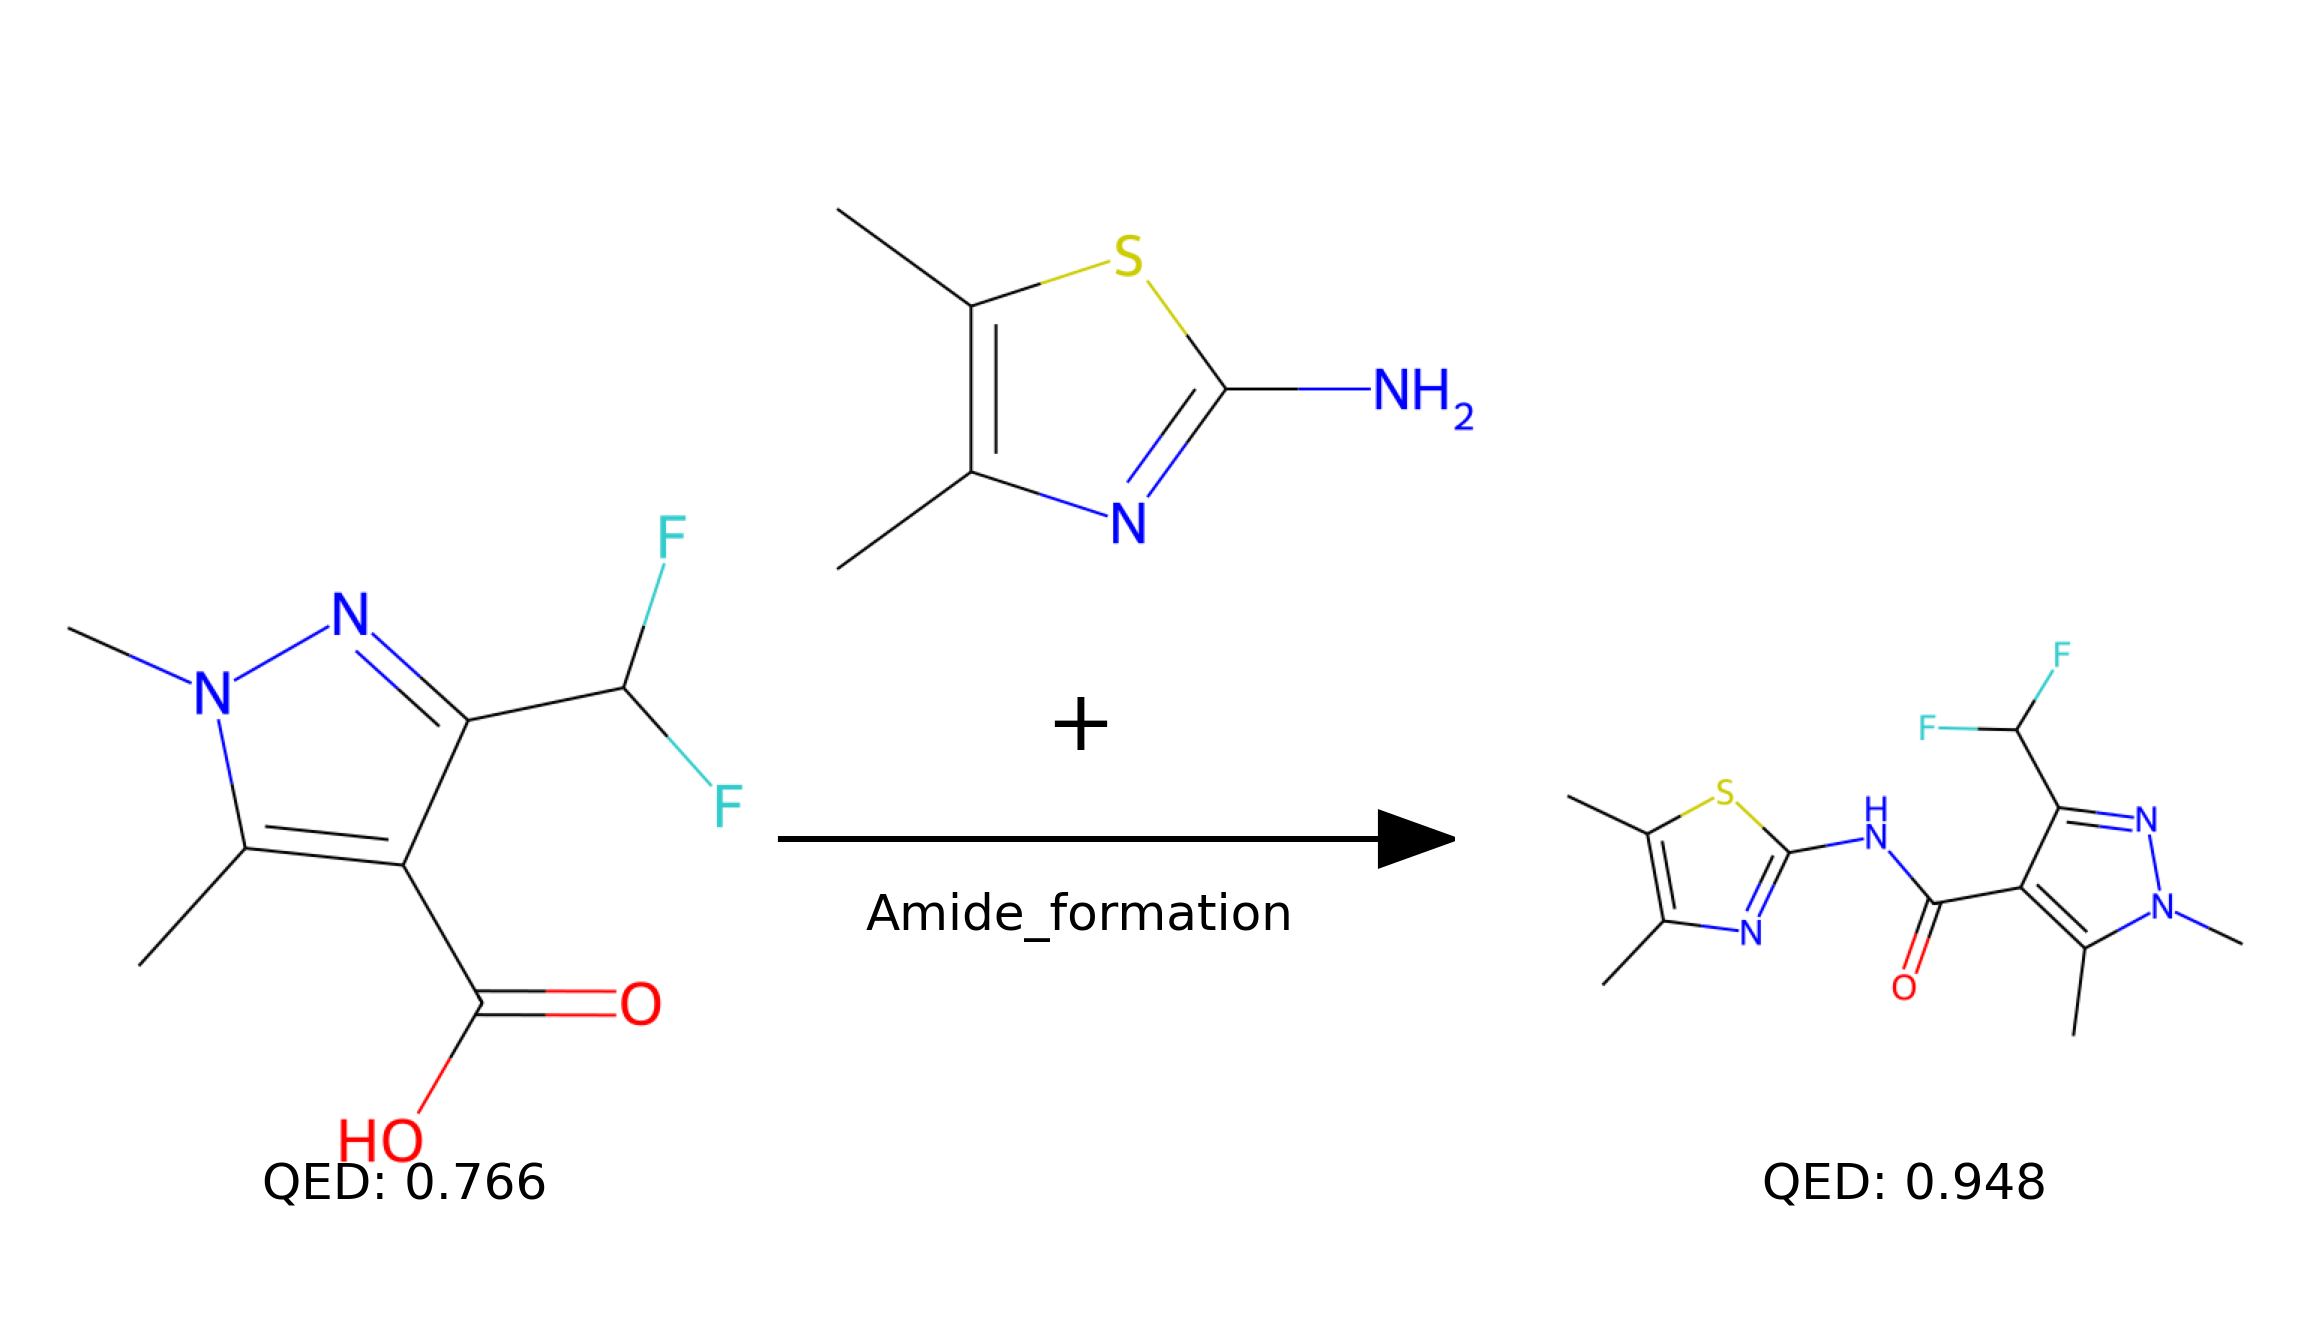

In [29]:
# synthesis path for molecule with highest qed
draw_path(randomsearch_results_30, 108630)

In [30]:
# Function to check if QED values are strictly increasing for a given path
def is_strictly_increasing(group):
    return (group['qed'].diff().dropna() > 0).all()

# Group by path_id and filter the paths where QED is strictly increasing
increasing_qed_paths = randomsearch_results_30.groupby('path_id').filter(is_strictly_increasing)

In [31]:
# Display the dataframe
increasing_qed_paths.head(20)

step                   reactant                     template  \
path_id                                                                 
16          0          COCc1noc(C(C)O)n1                          NaN   
16          1          COCc1noc(C(C)O)n1          Williamson_ether_R2   
36          0  NCC1CCN(C(=O)C(F)(F)F)CC1                          NaN   
36          1  NCC1CCN(C(=O)C(F)(F)F)CC1      Quinazolinone_formation   
60          0    Nc1ccc(Oc2cccc(F)c2)nc1                          NaN   
60          1    Nc1ccc(Oc2cccc(F)c2)nc1           Amide_formation_R2   
74          0            CC(N)CCc1ccccn1                          NaN   
74          1            CC(N)CCc1ccccn1  Tetrahydro-Indole_formation   
80          0               Cc1nnc(CO)o1                          NaN   
80          1               Cc1nnc(CO)o1          Williamson_ether_R2   
103         0        O=C1NCCc2c(Br)ncn21                          NaN   
103         1        O=C1NCCc2c(Br)ncn21              Suzuki_coupling   
112         0        CC1(C)CCc2ccccc2C1N                          NaN   
112         1        CC1(C)CCc2ccccc2C1N      Quinazolinone_formation   
113         0                NCCC1(N)CC1                          NaN   
113         1                NCCC1(N)CC1              FGI_nitrilation   
113         2               N#CCC1(N)CC1     Sulfonamide_formation_R2   
122         0    NC(=O)C(Cl)c1ccc(Br)cc1                          NaN   
122         1    NC(=O)C(Cl)c1ccc(Br)cc1                      Negishi   
123         0        COc1ccc2c(c1)CCC2=O                          NaN   

                                                product    qed  \
path_id                                                          
16                                    COCc1noc(C(C)O)n1  0.683   
16                      COCc1noc(C(C)Oc2cn(CC#N)nc2C)n1  0.786   
36                            NCC1CCN(C(=O)C(F)(F)F)CC1  0.694   
36       Cc1cc2c(=O)n(CC3CCN(C(=O)C(F)(F)F)CC3)cnc2cc1F  0.763   
60                              Nc1ccc(Oc2cccc(F)c2)nc1  0.817   
60              N#CC1OCCCC1C(=O)Nc1ccc(Oc2cccc(F)c2)nc1  0.922   
74                                      CC(N)CCc1ccccn1  0.706   
74                  CCCc1c(C)c2c(n1C(C)CCc1ccccn1)CCCC2  0.715   
80                                         Cc1nnc(CO)o1  0.552   
80               Cc1nnc(COc2cc(F)c(F)cc2[N+](=O)[O-])o1  0.625   
103                                 O=C1NCCc2c(Br)ncn21  0.695   
103                   O=C1NCc2cc(-c3ncn4c3CCNC4=O)ccc21  0.807   
112                                 CC1(C)CCc2ccccc2C1N  0.644   
112            Cc1cc2c(=O)n(C3c4ccccc4CCC3(C)C)cnc2cc1F  0.660   
113                                         NCCC1(N)CC1  0.506   
113                                        N#CCC1(N)CC1  0.513   
113                 N#CCC1(NS(=O)(=O)CC(=O)c2ccccc2)CC1  0.793   
122                             NC(=O)C(Cl)c1ccc(Br)cc1  0.801   
122                  COc1ccc(-c2ccc(C(Cl)C(N)=O)cc2)nc1  0.873   
123                                 COc1ccc2c(c1)CCC2=O  0.629   

                            second_reactant  
path_id                                      
16                                      NaN  
16                          Cc1nn(CC#N)cc1I  
36                                      NaN  
36                    Cc1cc(C(=O)O)c(N)cc1F  
60                                      NaN  
60                        N#CC1OCCCC1C(=O)O  
74                                      NaN  
74                            CC(=O)C1CCCO1  
80                                      NaN  
80             O=[N+]([O-])c1cc(F)c(F)cc1Br  
103                                     NaN  
103      CC1(C)OB(c2ccc3c(c2)CNC3=O)OC1(C)C  
112                                     NaN  
112                   Cc1cc(C(=O)O)c(N)cc1F  
113                                     NaN  
113                                     NaN  
113               O=C(CS(=O)(=O)Cl)c1ccccc1  
122                                     NaN  
122                          

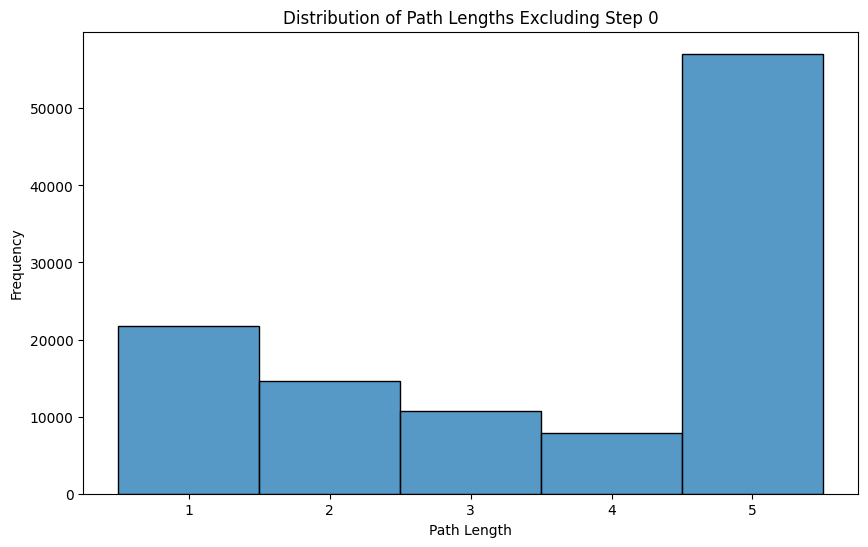

In [32]:
# Exclude step 0
df_filtered = randomsearch_results_30[randomsearch_results_30['step'] != 0]

# Calculate the length of each path excluding step 0
path_lengths = df_filtered.groupby('path_id').size()

# Create the plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(path_lengths, bins=range(1, 6), discrete=True, kde=False)

# Add labels and title
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.title('Distribution of Path Lengths Excluding Step 0')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

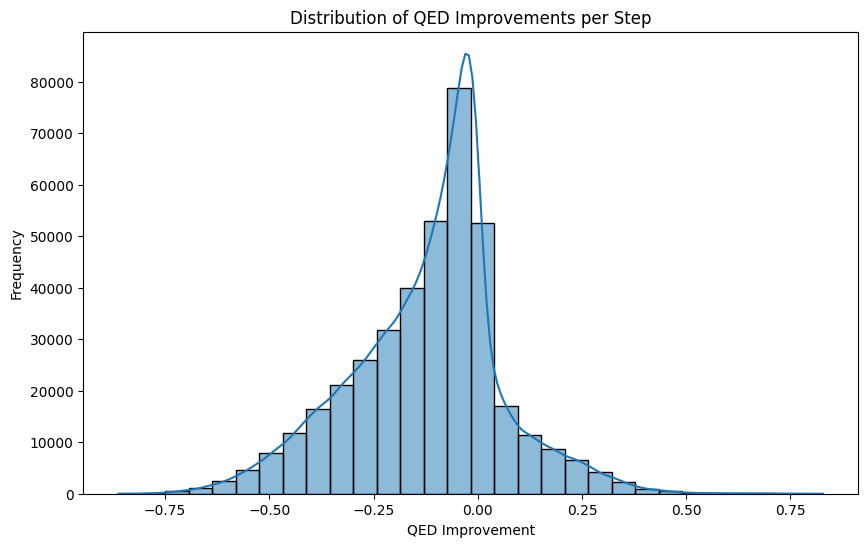

In [33]:
# Calculate the QED improvement per step for each path
qed_improvement = randomsearch_results_30.groupby('path_id')['qed'].diff().dropna()

# Calculate the average QED improvement
average_qed_improvement = qed_improvement.mean()

# Plot the distribution of QED improvements using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(qed_improvement, bins=30, kde=True)

# Add labels and title
plt.xlabel('QED Improvement')
plt.ylabel('Frequency')
plt.title('Distribution of QED Improvements per Step')
plt.show()

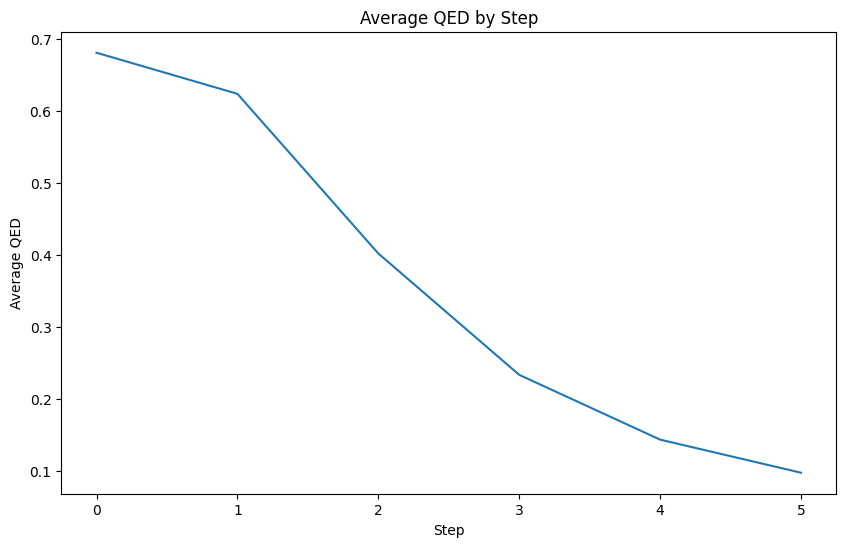

In [34]:
# Calculate the average QED value at each step
average_qed_by_step = randomsearch_results_30.groupby('step')['qed'].mean()

# Plot the average QED by step using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_qed_by_step.index, y=average_qed_by_step.values)

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Average QED')
plt.title('Average QED by Step')
plt.show()

In [35]:
# Calculate QED improvements
qed_improvement = randomsearch_results_30.groupby('path_id')['qed'].diff().dropna()

# Calculate the probability of QED increase
qed_increase_prob = (qed_improvement > 0).mean()

qed_increase_prob

0.1943525

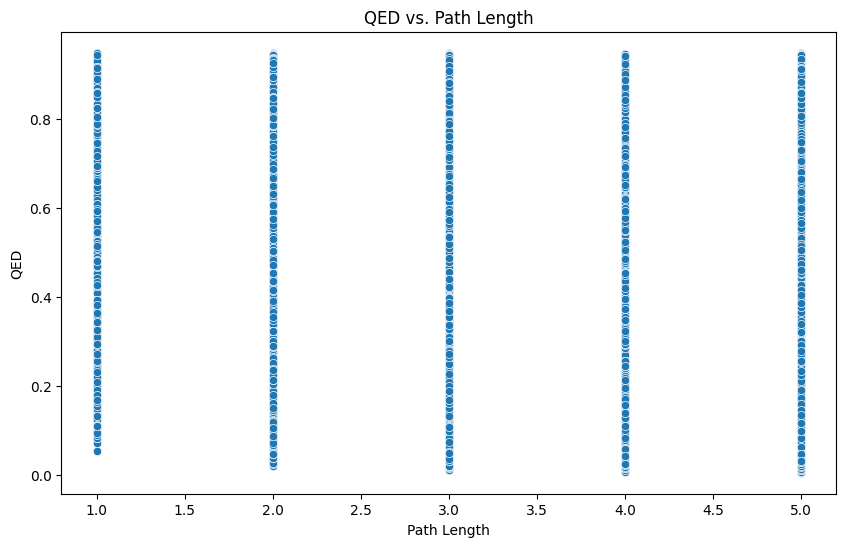

In [57]:
# Calculate the length of each path excluding step 0
df_filtered = randomsearch_results_30[randomsearch_results_30['step'] != 0]
path_lengths = df_filtered.groupby('path_id').size().reset_index(name='path_length')
df_with_lengths = df_filtered.merge(path_lengths, on='path_id')

# Plot QED values against path length using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='path_length', y='qed', data=df_with_lengths)

# Add labels and title
plt.xlabel('Path Length')
plt.ylabel('QED')
plt.title('QED vs. Path Length')
plt.show()

## Data Analysis

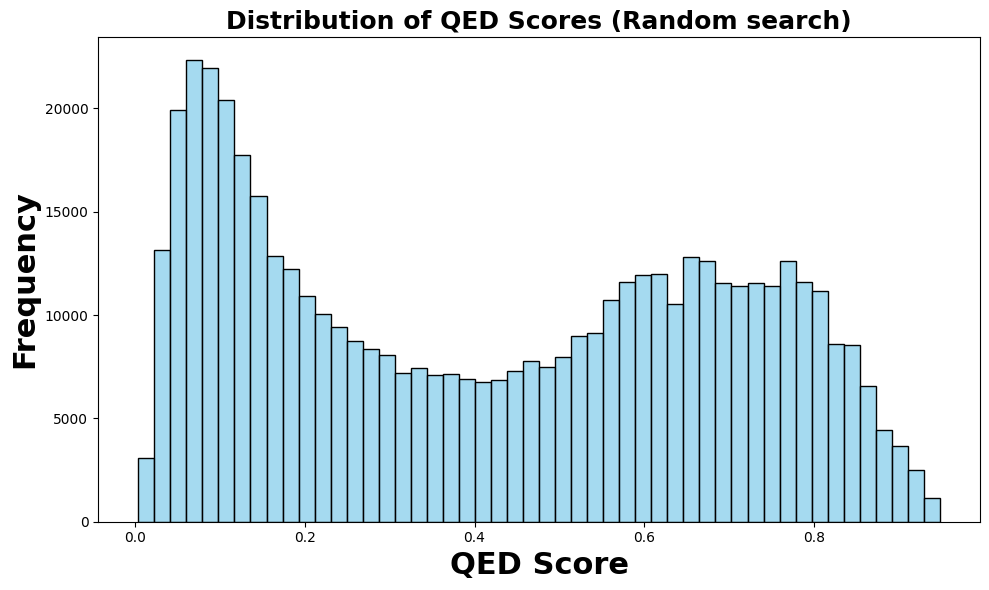

In [60]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(randomsearch_results_30['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores (Random search)', fontsize=18, fontweight='bold')
plt.xlabel('QED Score', fontsize=22, fontweight='bold')
plt.ylabel('Frequency', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

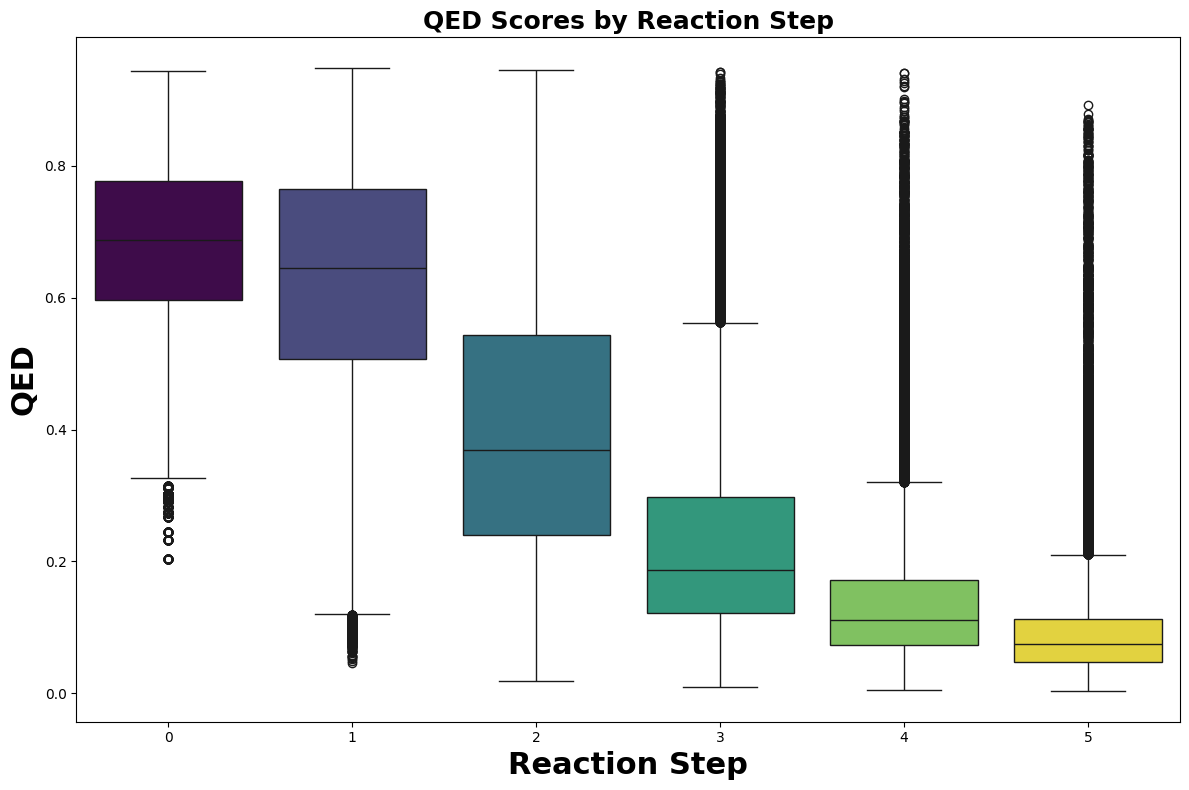

In [72]:
# Box plot for QED scores by reaction step
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=randomsearch_results_30, hue='step', palette="viridis", showfliers=True, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=22, fontweight='bold')
plt.ylabel('QED', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

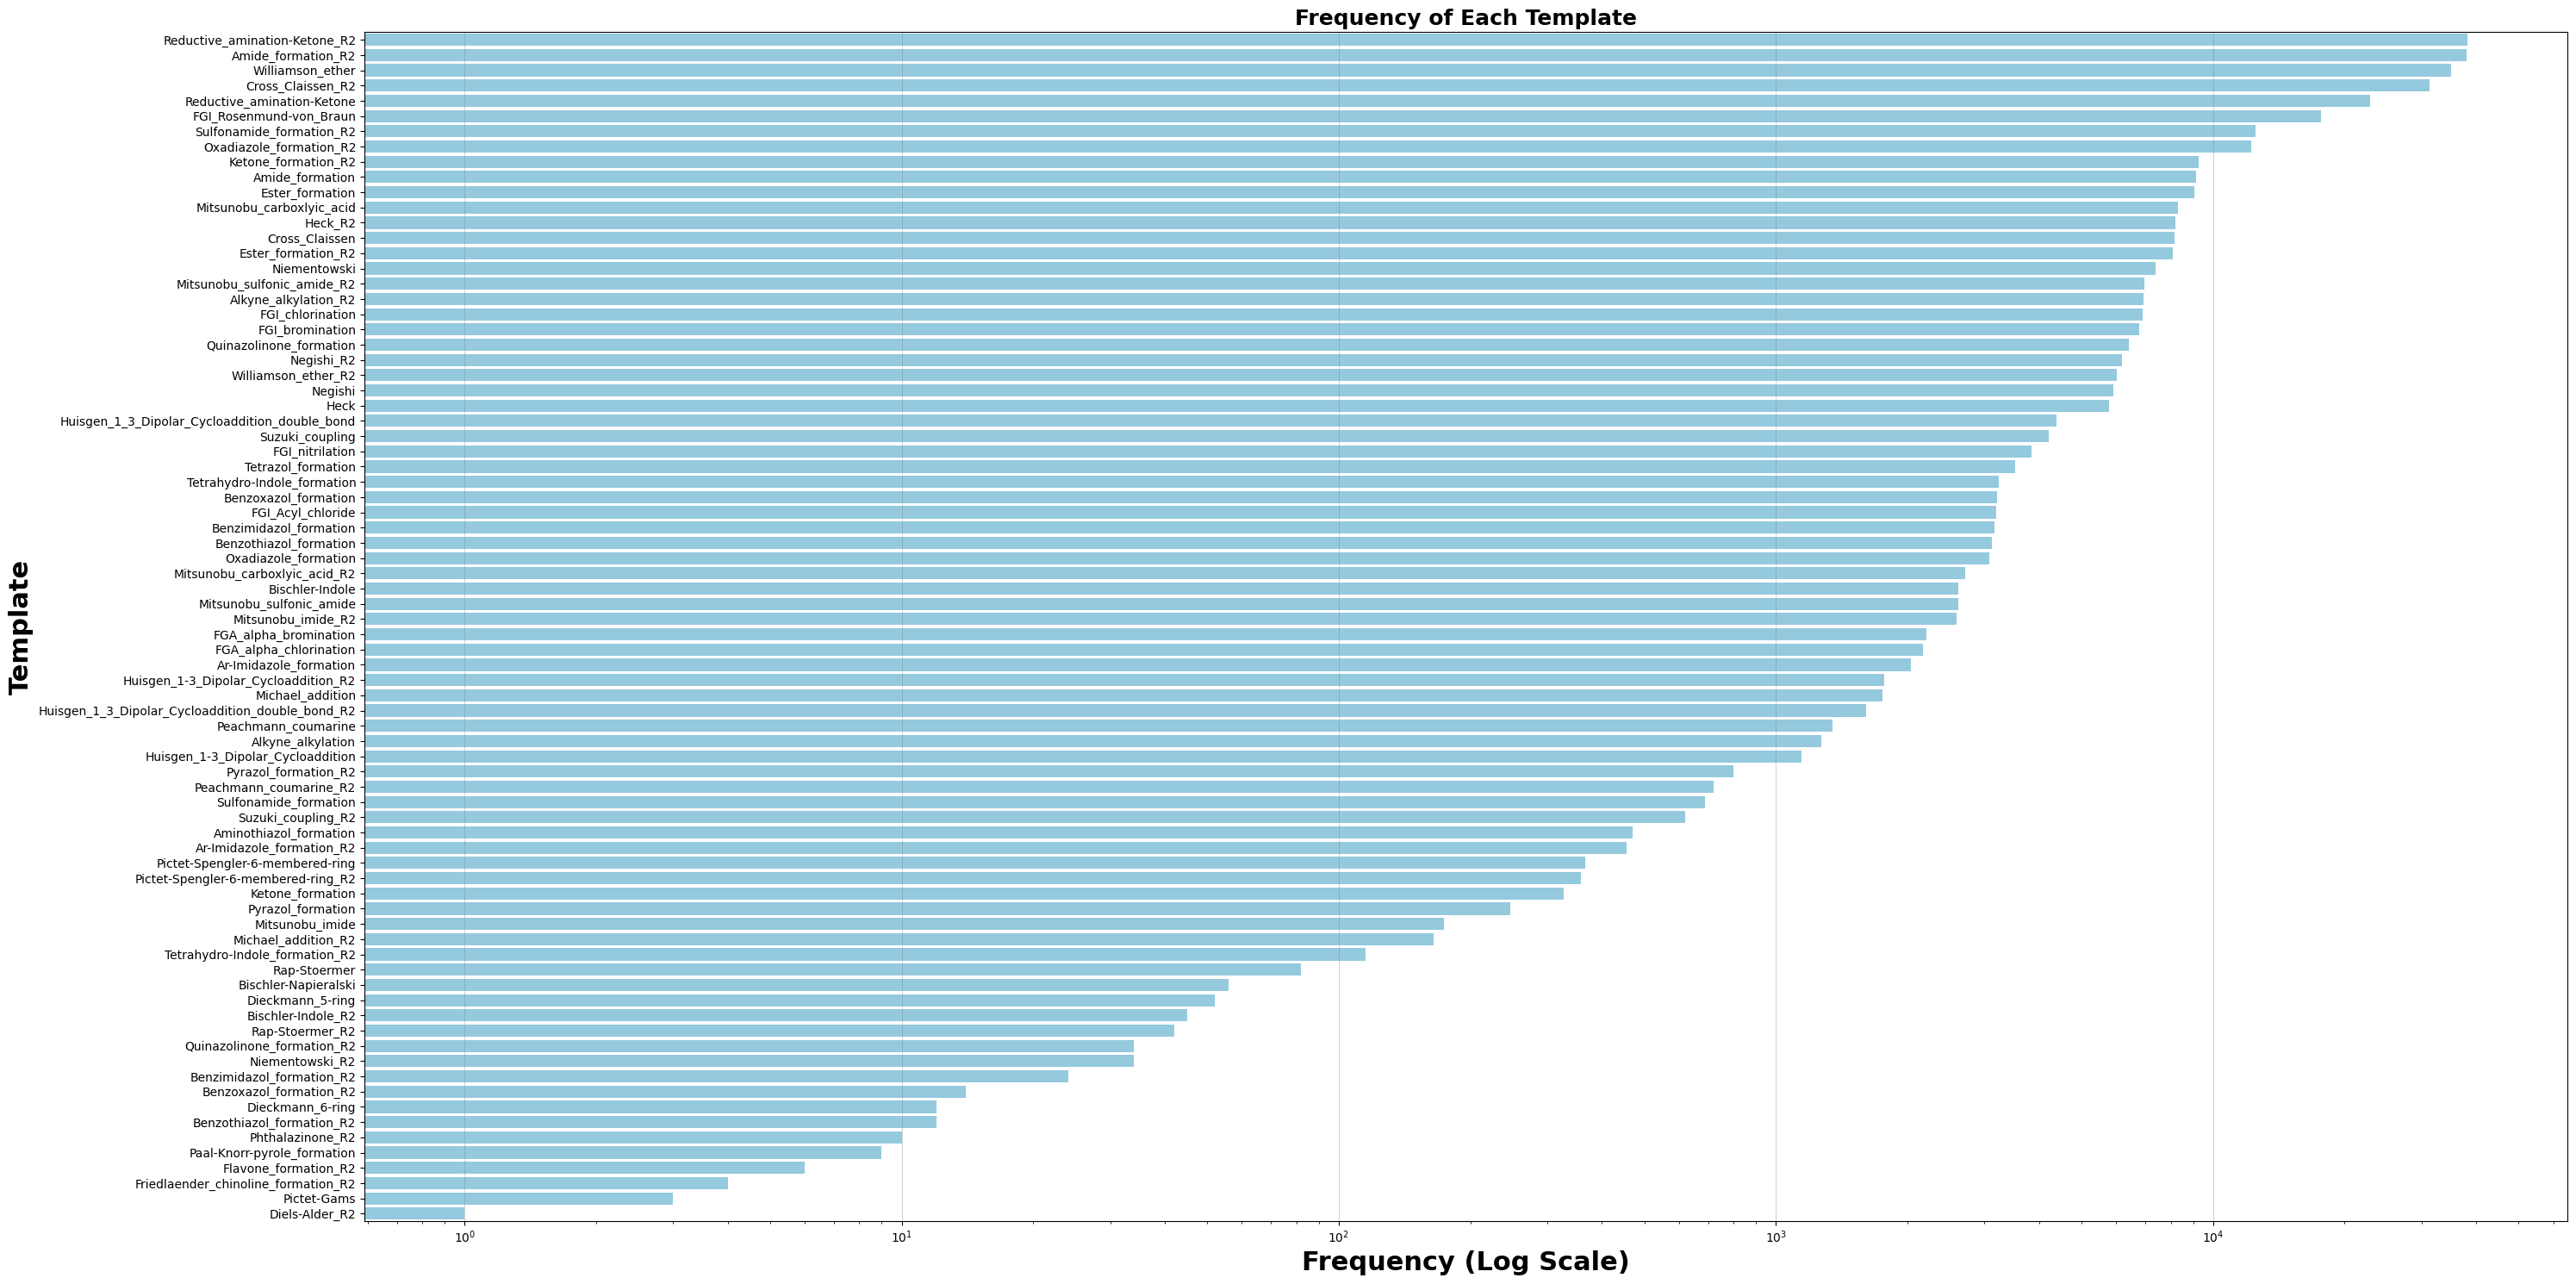

In [73]:
# Calculate frequency of each template
template_frequency = randomsearch_results_30['template'].value_counts().reset_index()
template_frequency.columns = ['template', 'frequency']

# Create horizontal bar plot with log scale for frequency
plt.figure(figsize=(30, 15))
sns.barplot(y='template', x='frequency', data=template_frequency, color='skyblue')
plt.xscale('log')
plt.title('Frequency of Each Template', fontsize=18, fontweight='bold')
plt.xlabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.ylabel('Template', fontsize=22, fontweight='bold')
# Add faint grey grid lines
plt.grid(color='grey', linestyle='-', linewidth=0.5, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2783336/1173448485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["reactant"] = data['reactant'].apply(get_compound_name)


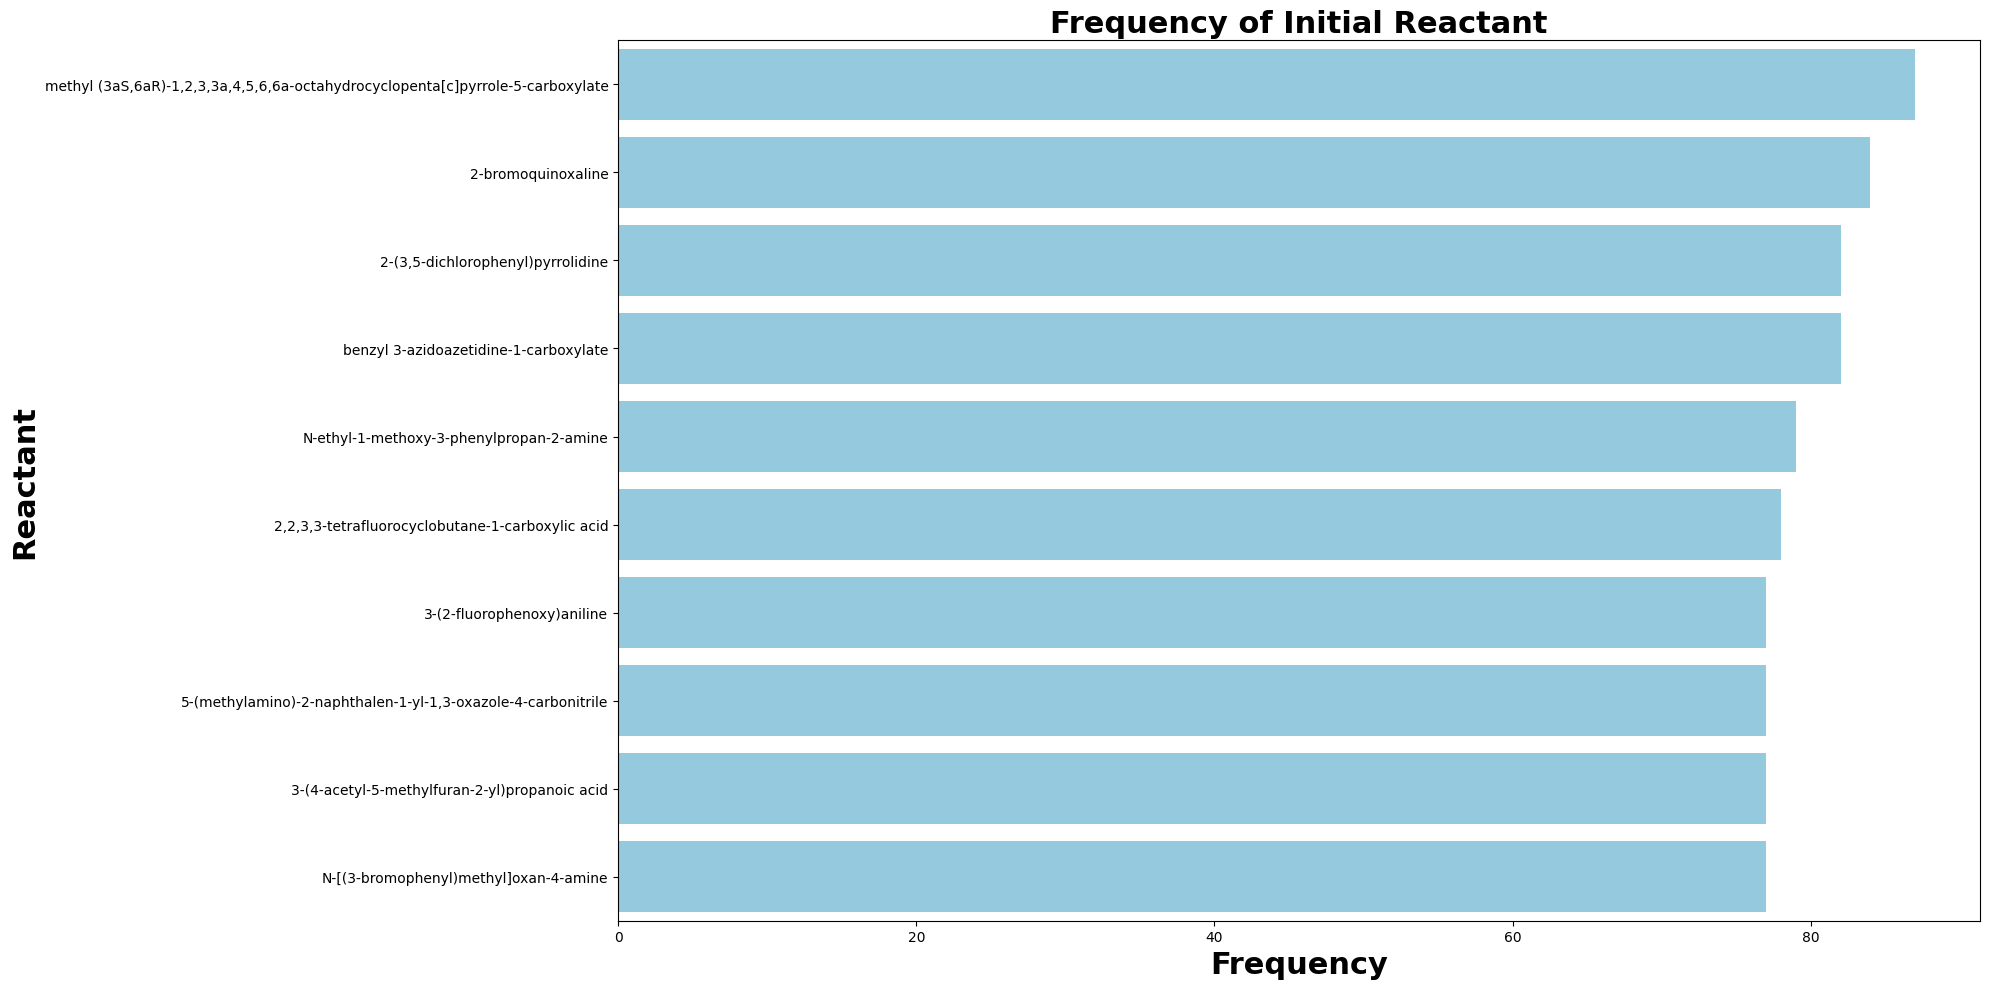

In [36]:
# Filter the DataFrame for step 0
df_step_0 = randomsearch_results_30[randomsearch_results_30['step'] == 0]

# Calculate the frequency of each combined reactant
reactant_frequency_step_0 = df_step_0['reactant'].value_counts().reset_index()
reactant_frequency_step_0.columns = ['reactant', 'frequency']
data = reactant_frequency_step_0.head(10)
data["reactant"] = data['reactant'].apply(get_compound_name)

# Create a horizontal bar chart
plt.figure(figsize=(20, 10))
sns.barplot(y='reactant', x='frequency', data=data, color='skyblue')
#plt.xscale('log')
plt.title('Frequency of Initial Reactant', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=22, fontweight='bold')
plt.ylabel('Reactant', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# Greedy Search: 2000 compatible reactants, exhaustive search...

In [37]:
greedysearch_results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/src/models/gsearch/results/Gmolsearch_results.csv", index_col=0)
greedysearch_results.describe()

step          qed
count  9342.000000  9342.000000
mean      2.157247     0.665257
std       1.704042     0.195625
min       0.000000     0.141000
25%       1.000000     0.504000
50%       2.000000     0.678000
75%       4.000000     0.842000
max       5.000000     0.948000

In [38]:
greedysearch_results.head(10)

step                                           reactant  \
path_id                                                            
0           0              CC1(C)OB(c2ccc(-c3ccccc3)cc2F)OC1(C)C   
0           1              CC1(C)OB(c2ccc(-c3ccccc3)cc2F)OC1(C)C   
0           2              C[C@H](N)c1nccn1-c1ccc(-c2ccccc2)cc1F   
0           3   C[C@H](NC1CNC(=O)C1)c1nccn1-c1ccc(-c2ccccc2)cc1F   
0           4  CC(CN)N(C1CNC(=O)C1)[C@@H](C)c1nccn1-c1ccc(-c2...   
0           5  CC(CN)N(C1CNC(=O)C1C(=O)C1CC1)[C@@H](C)c1nccn1...   
1           0                             N[C@H]1CCCc2cc(F)ccc21   
1           1                             N[C@H]1CCCc2cc(F)ccc21   
2           0                               Clc1cc(Br)cc2c1OCCN2   
2           1                               Clc1cc(Br)cc2c1OCCN2   

                              template  \
path_id                                  
0                                  NaN   
0            Ar-Imidazole_formation_R2   
0        Reductive_amination-Ketone_R2   
0        Reductive_amination-Ketone_R2   
0                    Cross_Claissen_R2   
0           Reductive_amination-Ketone   
1                                  NaN   
1                   Amide_formation_R2   
2                                  NaN   
2                           Negishi_R2   

                                                   product    qed  \
path_id                                                             
0                    CC1(C)OB(c2ccc(-c3ccccc3)cc2F)OC1(C)C  0.785   
0                    C[C@H](N)c1nccn1-c1ccc(-c2ccccc2)cc1F  0.795   
0         C[C@H](NC1CNC(=O)C1)c1nccn1-c1ccc(-c2ccccc2)cc1F  0.731   
0        CC(CN)N(C1CNC(=O)C1)[C@@H](C)c1nccn1-c1ccc(-c2...  0.614   
0        CC(CN)N(C1CNC(=O)C1C(=O)C1CC1)[C@@H](C)c1nccn1...  0.449   
0        CC(CN)N(C1CNC(=O)C1C(C1CC1)N1CC2(CN(C)C(=O)O2)...  0.360   
1                                   N[C@H]1CCCc2cc(F)ccc21  0.626   
1                  COc1ccc(C(=O)N[C@H]2CCCc3cc(F)ccc32)nc1  0.948   
2                                     Clc1cc(Br)cc2c1OCCN2  0.762   
2                     Cc1nn(CCC#N)cc1-c1cc(Cl)c2c(c1)NCCO2  0.945   

                  second_reactant  
path_id                            
0                             NaN  
0             C[C@H](N)c1ncc[nH]1  
0                   O=C1CNC(=O)C1  
0                        CC(=O)CN  
0        O=C(OCCS(=O)(=O)Cl)C1CC1  
0               CN1CC2(CNC2)OC1=O  
1                             NaN  
1              COc1ccc(C(=O)O)nc1  
2                             NaN  
2               Cc1nn(CCC#N)cc1Br

In [39]:
greedysearch_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9342 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             9342 non-null   int64  
 1   reactant         9342 non-null   object 
 2   template         7332 non-null   object 
 3   product          9342 non-null   object 
 4   qed              9342 non-null   float64
 5   second_reactant  7305 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 510.9+ KB


In [40]:
# Number of paths
len(greedysearch_results.index.unique())

2000

In [41]:
# Molecules with the highest qed regardless of max steps
greedysearch_results[greedysearch_results["qed"]==0.948].tail(10)

step                    reactant                       template  \
path_id                                                                    
1830        1          CCC(C(=O)O)n1ccnc1                Amide_formation   
1849        1   Cc1cc(N2CCC(N)C2=O)ccc1Br               Williamson_ether   
1850        1          N#Cc1ccc(F)c(CN)c1  Reductive_amination-Ketone_R2   
1851        1  C[C@@H]1[C@H](C(=O)O)CCN1C                Amide_formation   
1855        1              Cc1c(Cl)cncc1I                     Negishi_R2   
1861        1          CCc1cccc(C(=O)O)n1                Amide_formation   
1927        1    Cc1ccc(C(F)(F)C(=O)O)cc1                Amide_formation   
1962        1            CSC1(C(=O)O)CCC1                Amide_formation   
1975        1  O=C1NCC(C2CC2)n2cc(Br)cc21               Williamson_ether   
1980        1           Nc1cncc(C(=O)O)c1                Amide_formation   

                                              product    qed  \
path_id                                                        
1830              CCC(C(=O)N1CCCCc2cc(O)ccc21)n1ccnc1  0.948   
1849              Cc1cc(N2CCC(N)C2=O)ccc1Oc1ccc(F)cc1  0.948   
1850            Cn1c2c(ccc1=O)C(NCc1cc(C#N)ccc1F)CCC2  0.948   
1851     C[C@@H]1[C@H](C(=O)NCc2coc3c(Cl)cccc23)CCN1C  0.948   
1855               CNS(=O)(=O)c1ccc(-c2cncc(Cl)c2C)s1  0.948   
1861     CCc1cccc(C(=O)N[C@@H]2C[C@]23CCOc2ccccc23)n1  0.948   
1927     Cc1ccc(C(F)(F)C(=O)N2CCC[C@H]2c2ncn[nH]2)cc1  0.948   
1962            CSC1(C(=O)Nc2cc(=O)n(C)c3ccccc23)CCC1  0.948   
1975            O=C1NCC(C2CC2)n2cc(Oc3cc(Cl)ccn3)cc21  0.948   
1980                Nc1cncc(C(=O)N2CCCC2Cc2ccccc2F)c1  0.948   

                     second_reactant  
path_id                               
1830              Oc1ccc2c(c1)CCCCN2  
1849                    Oc1ccc(F)cc1  
1850         Cn1c2c(ccc1=O)C(=O)CCC2  
1851             NCc1coc2c(Cl)cccc12  
1855          CNS(=O)(=O)c1ccc(Br)s1  
1861     N[C@@H]1C[C@]12CCOc1ccccc12  
1927        c1n[nH]c([C@@H]2CCCN2)n1  
1962          Cn1c(=O)cc(N)c2ccccc21  
1975                   Oc1cc(Cl)ccn1  
1980               Fc1ccccc1CC1CCCN1

In [42]:
# Paths that achieved the max number of steps (5)
greedysearch_results[greedysearch_results["step"]==5].sort_values(by='qed', ascending=False).head(20)

step                                           reactant  \
path_id                                                            
1811        5        C[C@@H]1CCC2(C(=O)C1)N(C(C)(C)CCN)N=NC2(C)C   
1761        5           CC(=O)C1CCC(C)C(N2N=NC3CC(C)C(CO)CC32)C1   
1885        5           CC(=O)C1CCC2C(C1)N=NN2C1(C2CCC2)CC(CN)C1   
1987        5           CC(=O)C1CCC2C(C1)N=NN2C1(C2CCC2)CC(CN)C1   
1798        5           CC(=O)C1CCC(C)C(N2N=NC3CC(C)C(CO)CC32)C1   
655         5              CCC1(N2N=NC3(CC(CN)C3)C23CCC3)CCCC1=O   
1131        5              CCC1(N2N=NC3(CC(CN)C3)C23CCC3)CCCC1=O   
1035        5  COC(C)(C)CN1CC2(C1)CC(c1cc(C)ns1)(N1N=NC3CN(C(...   
1337        5            CC(C)N1CCC(N2N=NC3(CC(C)(C)O)CCCCC23)C1   
1123        5           CC(=O)C1CCCC(N2N=NC3(CC(CN)C3)C23CCC3)C1   
1208        5              CCC1(N2N=NC3(CC(CN)C3)C23CCC3)CCCC1=O   
569         5              CC1C(O)CCCC1(C)N1N=NC2CN(C)CCC21CCC#N   
1749        5              CC1C(O)CCCC1(C)N1N=NC2CN(C)CCC21CCC#N   
1501        5              CC1C(O)CCCC1(C)N1N=NC2CN(C)CCC21CCC#N   
547         5  CC(C1CCC(C)(N2N=NC(C)(C)C2CN)C(c2ccc(-n3[nH]nn...   
504         5  CC(C1CCC(C)(N2N=NC(C)(C)C2CN)C(c2ccc(-n3[nH]nn...   
358         5  C[C@@H]1CCC(C(C)(C)N2N=NC(C)(C)C2CN)C(N2Cc3con...   
1726        5  CCCCCCCCC(CCCCCCCCC(=O)OC)(c1nnc[nH]1)N1N=NC(C...   
576         5  Cn1cnc(C(=O)NCC(c2cccc(C(=O)N3CCSC3=S)c2)C(C)(...   
928         5  Cc1ccc(C2(N3N=NC(C)(C)C3CN)CCN(C(=O)OC(C)(C)C)...   

                                                 template  \
path_id                                                     
1811                           Reductive_amination-Ketone   
1761     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1885     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1987     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1798     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
655      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1131     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1035     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1337     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1123     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1208     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
569      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1749     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1501     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
547      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
504      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
358      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
1726     Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
576      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   
928      Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2   

                                                   product    qed  \
path_id                                                             
1811     C[C@@H]1CCC2(C(N3Cc4conc4C3)C1)N(C(C)(C)CCN)N=...  0.872   
1761              CC(=O)C1CCC2(C)C(C1)N=NN2C1CCC(CO)C(C)C1  0.871   
1885              CC(=O)C1CCCC(N2N=NC3(CC(CN)C3)C23CCC3)C1  0.871   
1987              CC(=O)C1CCCC(N2N=NC3(CC(CN)C3)C23CCC3)C1  0.871   
1798              CC(=O)C1CCC2(C)C(C1)N=NN2C1CCC(CO)C(C)C1  0.871   
655               CC(=O)C1CCC2C(C1)N=NN2C1(C2CCC2)CC(CN)C1  0.868   
1131              CC(=O)C1CCC2C(C1)N=NN2C1(C2CCC2)CC(CN)C1  0.868   
1035               CC(C)N1CCC(N2N=NC3(CC(C)(C)O)CCCCC23)C1  0.868   
1337               CC(C)N1CC2N=NN(C3(CC(C)(C)O)CCCCC3)C2C1  0.868   
1123              CC(=O)C1CCC2C(C1)N=NN2C1(C2CCC2)CC(CN)C1  0.868   
1208              CC(=O)C1CCC2C(C1)N=NN2C1(C2CCC2)CC(CN)C1  0.868   
569                CN1CCC(CCC#N)C(N2N=NC3(C)CCCC(O)C23C)C1  0.866   
1749               CN1CCC(CCC#N)C(N2N=NC3(C)CCCC(O)C23C)C1  0.866   
1501               CN1CCC(CCC#N)C(N2N=NC3(C)CCCC(O)C23C)C1  0.866   
547            C[C@@H]1CCC2(C(=O)C1)N(C(C)(C)CCN)N=NC2(C)C  0.864

In [43]:
# Find the maximum qed value for the last step of each path
last_steps = greedysearch_results.groupby('path_id').apply(lambda x: x[x['step']==x['step'].max()])
max_qed_last_step = last_steps.loc[last_steps['qed'].idxmax()]
max_qed_last_step

step                reactant            template  \
path_id path_id                                                     
1       1           1  N[C@H]1CCCc2cc(F)ccc21  Amide_formation_R2   

                                                 product    qed  \
path_id path_id                                                   
1       1        COc1ccc(C(=O)N[C@H]2CCCc3cc(F)ccc32)nc1  0.948   

                    second_reactant  
path_id path_id                      
1       1        COc1ccc(C(=O)O)nc1

In [44]:
last_steps.sort_values(by='qed', ascending=False).head(30)

step                           reactant  \
path_id path_id                                            
784     784         1             O=C(O)c1cc2ccc(F)cc2s1   
1241    1241        1       CC1(C)[C@H](c2ccccc2)[C@H]1N   
1770    1770        1              CCn1nc(C)c(C(=O)O)c1F   
554     554         1                CNc1cc(C(C)C)[nH]n1   
1108    1108        1        Cc1cnn(-c2ccc(C(=O)O)cc2)c1   
1962    1962        1                   CSC1(C(=O)O)CCC1   
1816    1816        1                  Fc1ccccc1CC1CCCN1   
1369    1369        1                       Cc1nc(N)sc1C   
704     704         1             CC1Cc2cccc(C(=O)O)c2O1   
1815    1815        1                 COc1ccc(C(=O)O)nc1   
1091    1091        1                    CC(N)c1ccn(C)c1   
303     303         1            O=C(O)C1(c2ccccc2)CCOC1   
223     223         1              O=C(O)c1cccc2c1OCCCO2   
1351    1351        1             Cn1c(=O)cc(N)c2ccccc21   
1703    1703        1  CO[C@@H]1C[C@@]2(C(=O)O)C[C@@H]12   
1       1           1             N[C@H]1CCCc2cc(F)ccc21   
1232    1232        1               CC(C)C(=O)c1cnn(C)c1   
1701    1701        1        N[C@@H]1C[C@]12CCOc1ccccc12   
458     458         1                  CC(N)c1cc(F)ccc1F   
1226    1226        1               O=C(O)c1cn2c(n1)SCC2   
501     501         1                 CCN1Cc2cccc(N)c2C1   
1006    1006        1                 CN1CCc2ccc(N)cc2C1   
679     679         1               CC(C)n1cnc(C(=O)O)c1   
1377    1377        1                      CON1CCC(N)CC1   
166     166         1                 Cc1cc2nc(N)sc2cc1F   
584     584         1             O=C([O-])c1ncn2c1CCCC2   
375     375         1           Cc1c(C(=O)O)c(C(F)F)nn1C   
877     877         1                     NC1CC2(CSC2)C1   
1265    1265        1               CCc1cnc(C(=O)[O-])s1   
1861    1861        1                 CCc1cccc(C(=O)O)n1   

                                      template  \
path_id path_id                                  
784     784                    Amide_formation   
1241    1241                Amide_formation_R2   
1770    1770                   Amide_formation   
554     554      Reductive_amination-Ketone_R2   
1108    1108                   Amide_formation   
1962    1962                   Amide_formation   
1816    1816                Amide_formation_R2   
1369    1369                Amide_formation_R2   
704     704                    Amide_formation   
1815    1815                   Amide_formation   
1091    1091                Amide_formation_R2   
303     303                    Amide_formation   
223     223                    Amide_formation   
1351    1351                Amide_formation_R2   
1703    1703                   Amide_formation   
1       1                   Amide_formation_R2   
1232    1232        Reductive_amination-Ketone   
1701    1701                Amide_formation_R2   
458     458                 Amide_formation_R2   
1226    1226                   Amide_formation   
501     501                 Amide_formation_R2   
1006    1006                Amide_formation_R2   
679     679                    Amide_formation   
1377    1377                Amide_formation_R2   
166     166                 Amide_formation_R2   
584     584                    Amide_formation   
375     375                    Amide_formation   
877     877                 Amide_formation_R2   
1265    1265                   Amide_formation   
1861    1861                   Amide_formation   

                                                           product    qed  \
path_id path_id                                                             
784     784                     CON1CCC(NC(=O)c2cc3ccc(F)cc3s2)CC1  0.948   
1241    1241       CC1(C)[C@H](NC(=O)c2cn3c(n2)SCC3)[C@H]1c1ccccc1  0.948   
1770    1770                   CCn1nc(C)c(C(=O)NC2CCOc3ccccc32)c1F  0.948   
554     554               CC(C)c1cc(N(C)C2CCCc3c2ccc(=O)n3C)n[nH]1  0.948   
1108    1108              Cc1cnn(

In [45]:
last_steps.sort_values(by='qed', ascending=False).tail(10)

step                                           reactant  \
path_id path_id                                                            
217     217         4  Cc1cc(-c2csc(NC(=O)C3OCCCO3)n2)c(C)n1Cc1ccccc1...   
1867    1867        5  CC(C)CC(NS(=O)(=O)c1ccc(-n2c(OC3(C)C4CCC(N5CC6...   
389     389         5  CC(CN(C1CNC(=O)C1)C1CC2CCC1C2)N(c1cccc(Sc2cccc...   
1259    1259        5  C[C@H]1N(C)CC[C@]1(C(=O)C1CC1)C(=O)N(C1CNC(=O)...   
180     180         5  COC(=O)C(Cc1nc(C2(N(C3CNC(=O)C3)C3CC4CCC3C4)CC...   
495     495         5  Cc1ccc(F)c(-c2ccc(C(=O)C(=O)O)c(OC3CCN(C(C)CNC...   
267     267         5  Cc1cccc(Oc2ccc(S(=O)(=O)N3CCCCC3)cc2N(C(C)CNC(...   
1939    1939        5  Cc1cc(-c2csc(N(C(C)CNC(=O)C3OCCCO3)C(C)CNC(=O)...   
667     667         4  COc1nn(CC(C(=O)NN)(C(=O)C2CC2)C(C2CCCC2)N2CCCC...   
1093    1093        5  CCCCN(CCCC)CCC(O)c1cc2c(O[C@@H]3COC[C@H]3NC(=O...   

                                   template  \
path_id path_id                               
217     217                    Niementowski   
1867    1867             Amide_formation_R2   
389     389               Cross_Claissen_R2   
1259    1259     Reductive_amination-Ketone   
180     180               Cross_Claissen_R2   
495     495                    Niementowski   
267     267                    Niementowski   
1939    1939                   Niementowski   
667     667      Reductive_amination-Ketone   
1093    1093            Williamson_ether_R2   

                                                           product    qed  \
path_id path_id                                                             
217     217      Cc1cc(-c2csc(NC(=O)C3OCCCO3)n2)c(C)n1Cc1ccccc1...  0.208   
1867    1867     CC(C)CC(NS(=O)(=O)c1ccc(-n2c(OC3(C)C4CCC(N5CC6...  0.205   
389     389      CC(CN(C1CC2CCC1C2)C1CNC(=O)C1C(=O)C1CC1)N(c1cc...  0.201   
1259    1259     C[C@H]1N(C)CC[C@@]1(C(=O)N(C1CNC(=O)C1)C1CC(N(...  0.198   
180     180      COC(=O)C(Cc1nc(C2(N(C3CC4CCC3C4)C3CNC(=O)C3C(=...  0.195   
495     495      Cc1cc2c(=O)n(CC(C)N3CCC(Oc4cc(-c5c(F)ccc(C)c5F...  0.187   
267     267      Cc1cccc(Oc2ccc(S(=O)(=O)N3CCCCC3)cc2N(C(C)CNC(...  0.184   
1939    1939     Cc1cc(-c2csc(N(C(C)CNC(=O)C3OCCCO3)C(C)Cn3c(C4...  0.183   
667     667      COc1nn(CC(C(=O)NN)(C(C2CC2)N2Cc3conc3C2)C(C2CC...  0.174   
1093    1093     CCCCN(CCCC)CCC(OCC1CN(C(C)=O)C(=O)O1)c1cc2c(O[...  0.141   

                                   second_reactant  
path_id path_id                                     
217     217            Nc1ccc(S(N)(=O)=O)cc1C(=O)O  
1867    1867     O=C(O)[C@]12COC[C@H]1CS(=O)(=O)C2  
389     389               O=C(OCCS(=O)(=O)Cl)C1CC1  
1259    1259                     CN1CC2(CNC2)OC1=O  
180     180               O=C(OCCS(=O)(=O)Cl)C1CC1  
495     495                  Cc1cc(C(=O)O)c(N)cc1F  
267     267            Nc1ccc(S(N)(=O)=O)cc1C(=O)O  
1939    1939           Nc1ccc(S(N)(=O)=O)cc1C(=O)O  
667     667                           c1onc2c1CNC2  
1093    1093                  CC(=O)N1CC(CCl)OC1=O

In [46]:
# Calculate the number of unique products
unique_products_count = greedysearch_results['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 8776


In [47]:
# Filter the DataFrame for step 0
df_step_0 = greedysearch_results[greedysearch_results['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 2000


In [48]:
# display path with highest qed regarddless of step
print_path(greedysearch_results, 1849)

Synthesis Path ID: 1849
Step 0:
  Reactant: Cc1cc(N2CCC(N)C2=O)ccc1Br | Name: 3-amino-1-(4-bromo-3-methylphenyl)pyrrolidin-2-one
  Template: nan
  Product: Cc1cc(N2CCC(N)C2=O)ccc1Br | Name: 3-amino-1-(4-bromo-3-methylphenyl)pyrrolidin-2-one
  QED Score: 0.845
----------------------------------------
Step 1:
  Reactant: Cc1cc(N2CCC(N)C2=O)ccc1Br | Name: 3-amino-1-(4-bromo-3-methylphenyl)pyrrolidin-2-one
  Second Reactant: Oc1ccc(F)cc1 | Name: 4-fluorophenol
  Template: Williamson_ether
  Product: Cc1cc(N2CCC(N)C2=O)ccc1Oc1ccc(F)cc1 | Name: Molecule not in PubChem Database
  QED Score: 0.948
----------------------------------------
Step 2:
  Reactant: Cc1cc(N2CCC(N)C2=O)ccc1Oc1ccc(F)cc1 | Name: Molecule not in PubChem Database
  Second Reactant: CC(=O)CN | Name: 1-aminopropan-2-one
  Template: Reductive_amination-Ketone_R2
  Product: Cc1cc(N2CCC(NC(C)CN)C2=O)ccc1Oc1ccc(F)cc1 | Name: Molecule not in PubChem Database
  QED Score: 0.834
----------------------------------------
Step 3:
  Rea

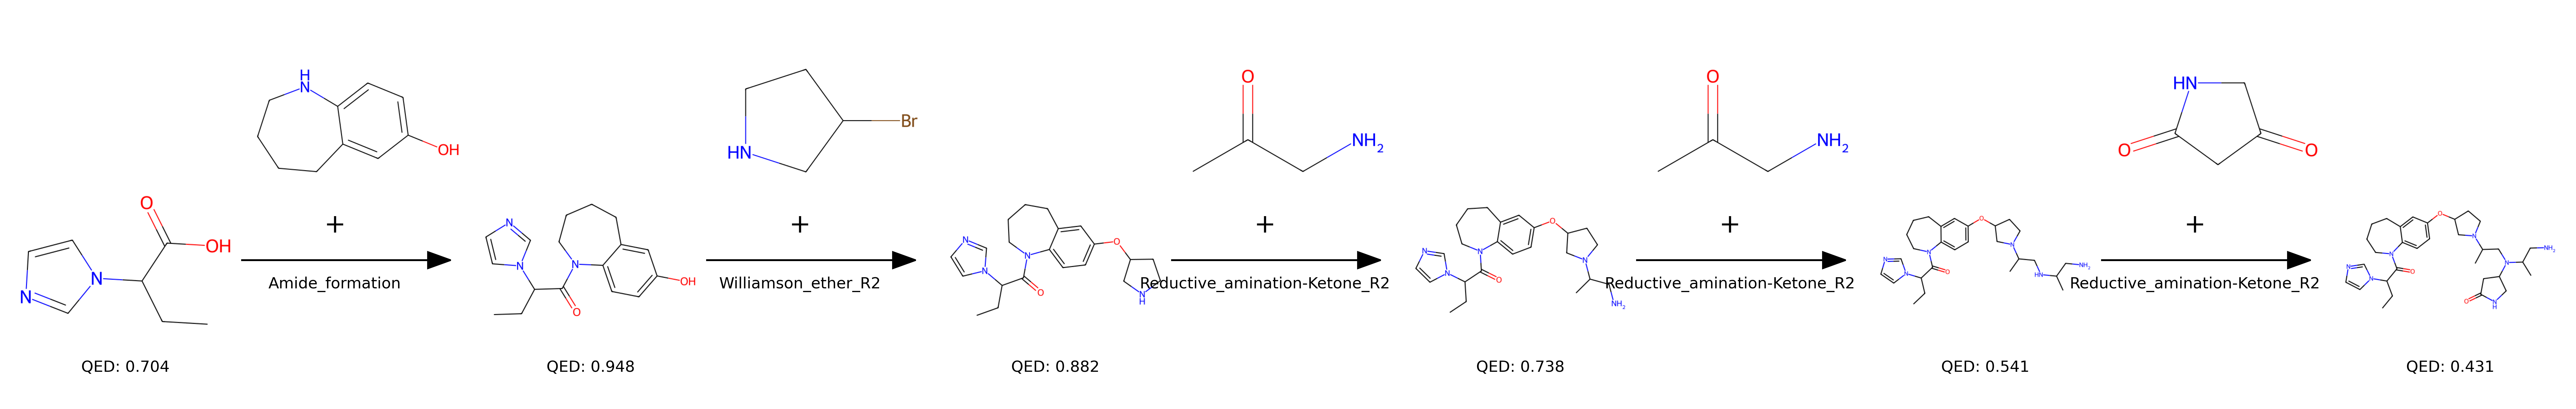

In [49]:
# synthesis path for molecule with highest qed regardless of step
draw_path(greedysearch_results, 1830)

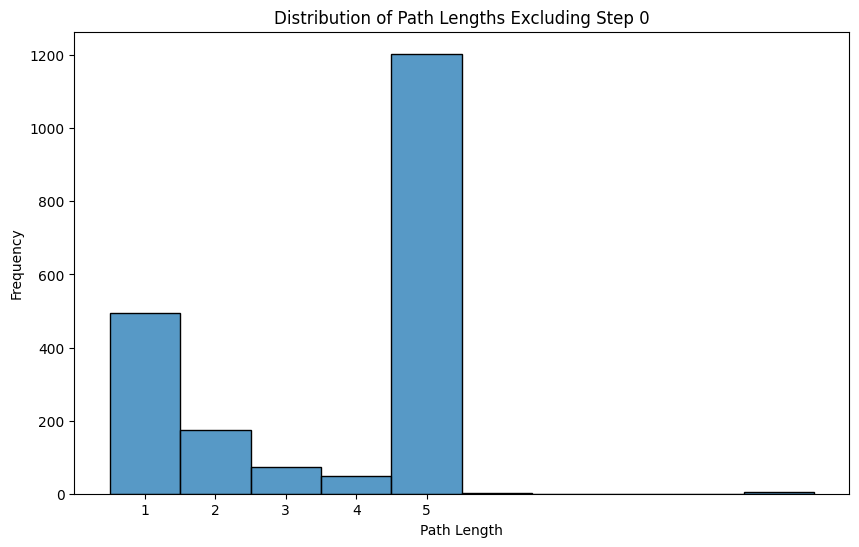

In [52]:
# Exclude step 0
df_filtered = greedysearch_results[greedysearch_results['step'] != 0]

# Calculate the length of each path excluding step 0
path_lengths = df_filtered.groupby('path_id').size()

# Create the plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(path_lengths, bins=range(1, 6), discrete=True, kde=False)

# Add labels and title
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.title('Distribution of Path Lengths Excluding Step 0')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

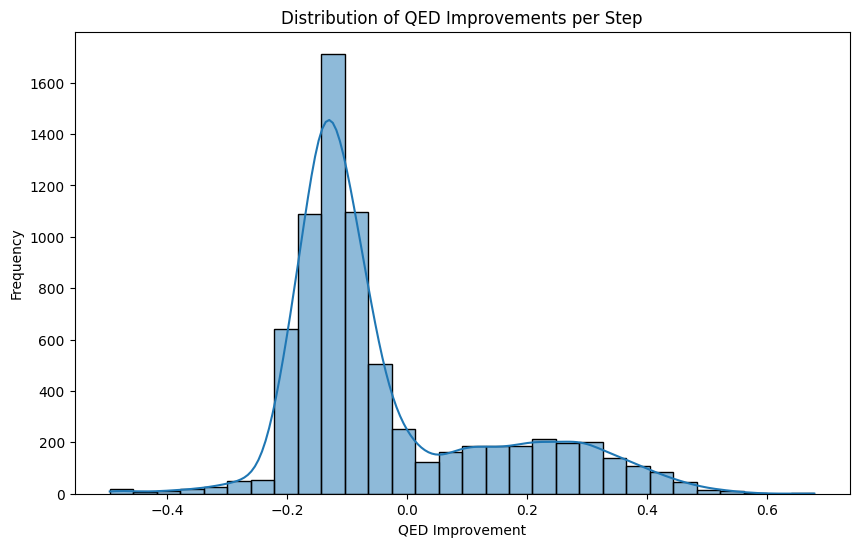

In [53]:
# Calculate the QED improvement per step for each path
qed_improvement = greedysearch_results.groupby('path_id')['qed'].diff().dropna()

# Calculate the average QED improvement
average_qed_improvement = qed_improvement.mean()

# Plot the distribution of QED improvements using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(qed_improvement, bins=30, kde=True)

# Add labels and title
plt.xlabel('QED Improvement')
plt.ylabel('Frequency')
plt.title('Distribution of QED Improvements per Step')
plt.show()

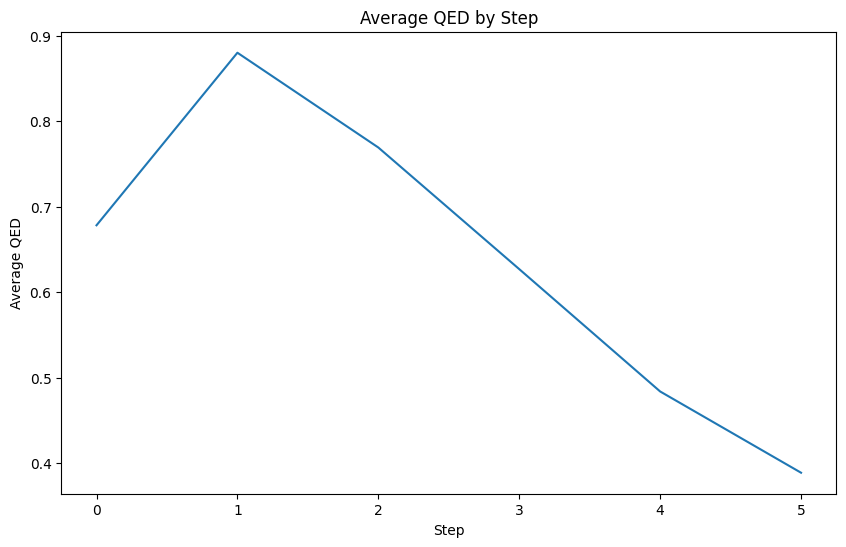

In [54]:
# Calculate the average QED value at each step
average_qed_by_step = greedysearch_results.groupby('step')['qed'].mean()

# Plot the average QED by step using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=average_qed_by_step.index, y=average_qed_by_step.values)

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Average QED')
plt.title('Average QED by Step')
plt.show()

In [55]:
# Calculate QED improvements
qed_improvement = greedysearch_results.groupby('path_id')['qed'].diff().dropna()

# Calculate the probability of QED increase
qed_increase_prob = (qed_improvement > 0).mean()

qed_increase_prob

0.2632797602833016

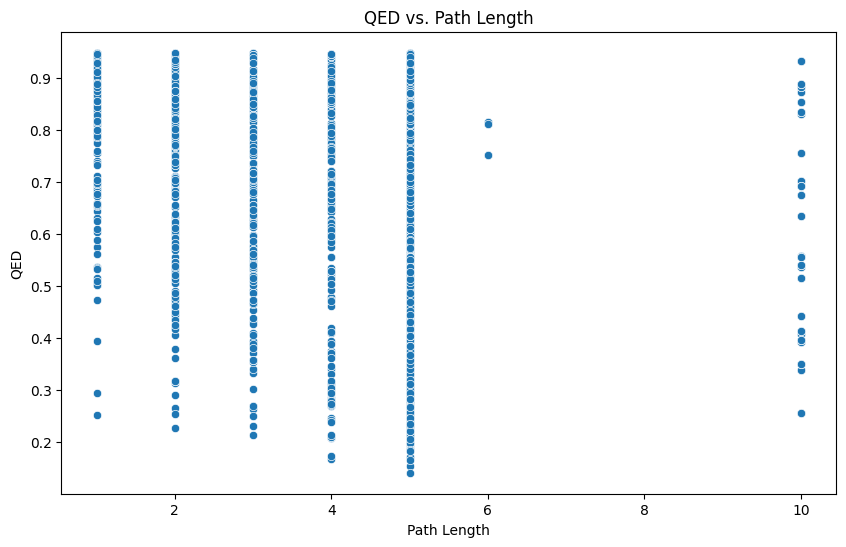

In [58]:
# Calculate the length of each path excluding step 0
df_filtered = greedysearch_results[greedysearch_results['step'] != 0]
path_lengths = df_filtered.groupby('path_id').size().reset_index(name='path_length')
df_with_lengths = df_filtered.merge(path_lengths, on='path_id')

# Plot QED values against path length using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='path_length', y='qed', data=df_with_lengths)

# Add labels and title
plt.xlabel('Path Length')
plt.ylabel('QED')
plt.title('QED vs. Path Length')
plt.show()

## Data Analysis

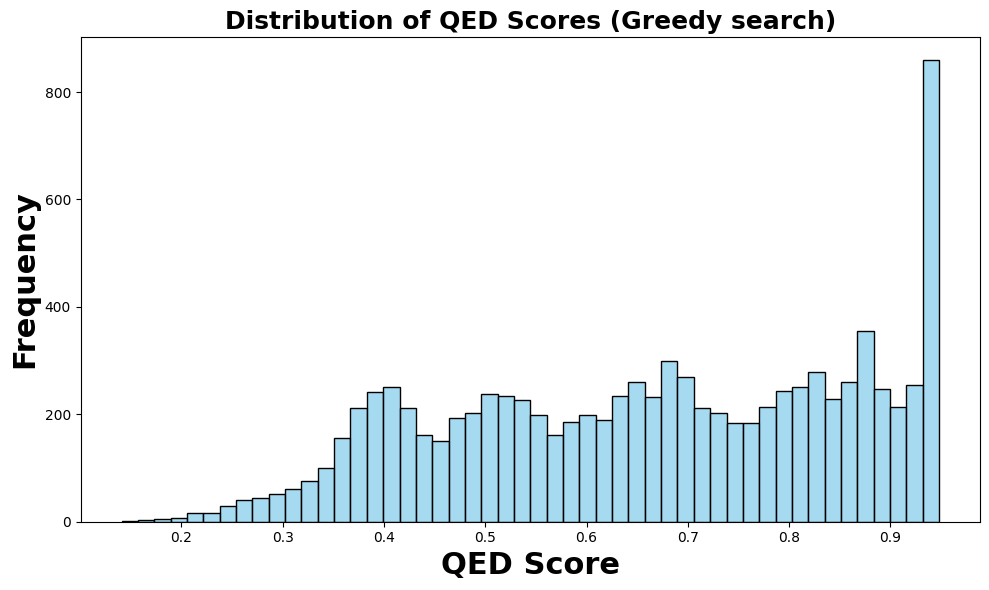

In [59]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(greedysearch_results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores (Greedy search)', fontsize=18, fontweight='bold')
plt.xlabel('QED Score', fontsize=22, fontweight='bold')
plt.ylabel('Frequency', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

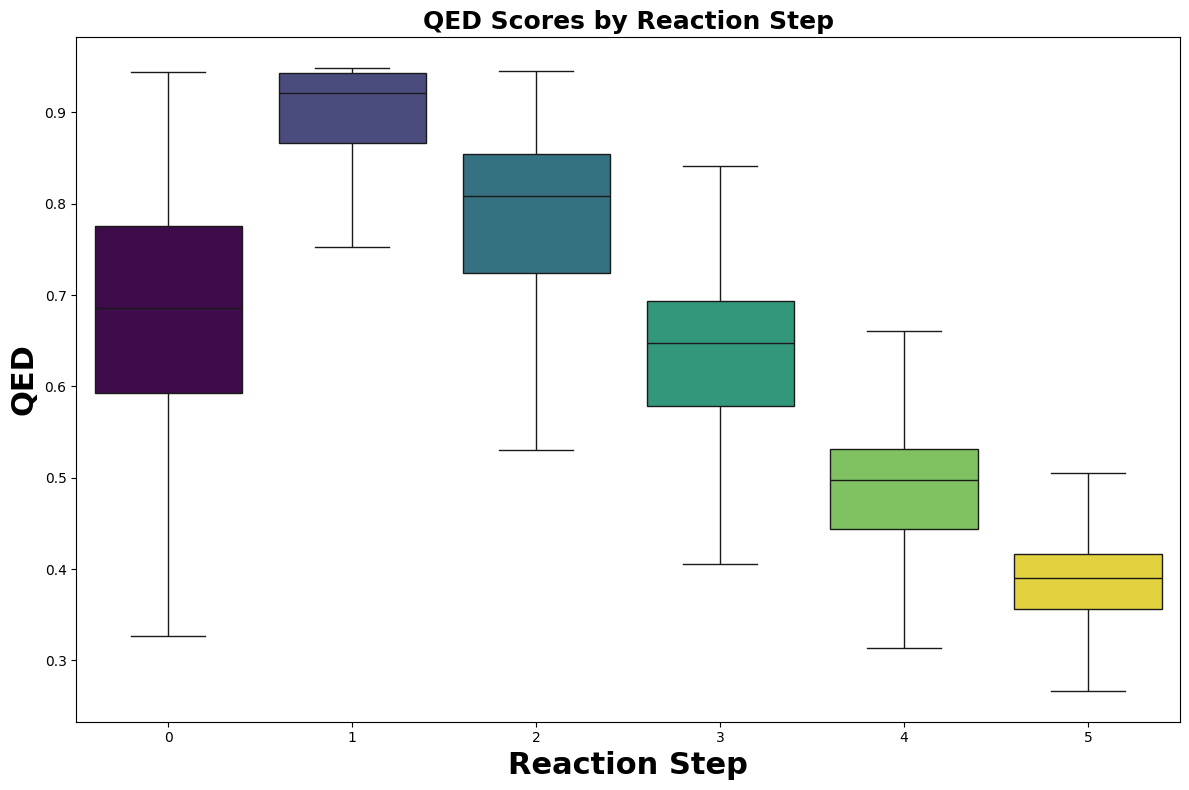

In [25]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=greedysearch_results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=22, fontweight='bold')
plt.ylabel('QED', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

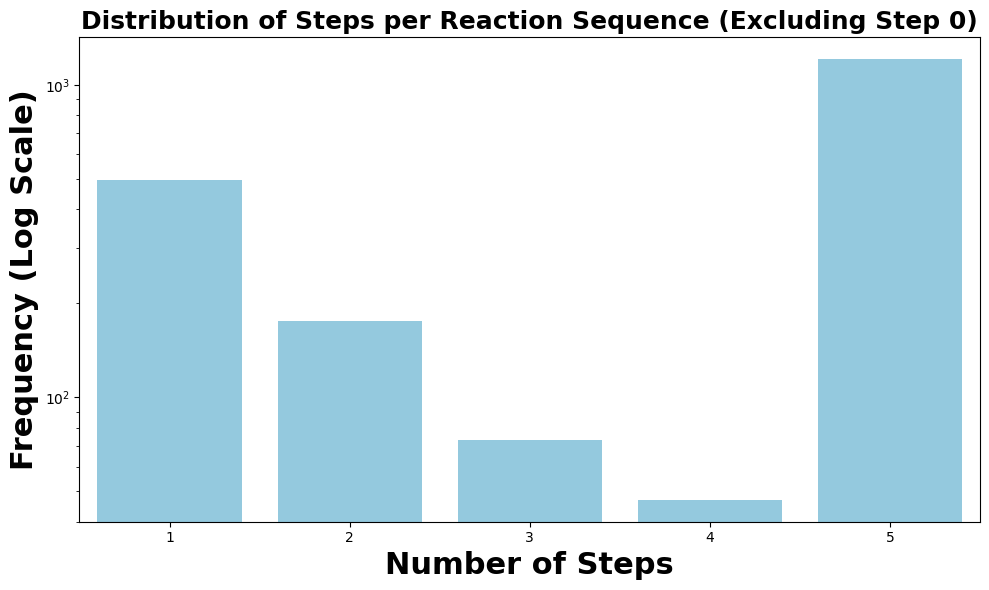

In [26]:
# Filter out step 0
df_filtered = greedysearch_results[greedysearch_results['step'] != 0]

# Calculate the number of steps per reaction sequence
steps_per_sequence = df_filtered.groupby('path_id')['step'].max()

# Calculate the frequency of each number of steps
steps_frequency = steps_per_sequence.value_counts().sort_index()

# Create a bar chart with log scale for frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=steps_frequency.index, y=steps_frequency.values, color='skyblue')
plt.yscale('log')
plt.title('Distribution of Steps per Reaction Sequence (Excluding Step 0)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Steps', fontsize=22, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# Greedy Search: 2000 compatible reactants, 15 Unimolecular templates, exhaustive search...  

In [4]:
greedysearch_results_uni = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/src/models/gsearch/results/Gmolsearch_results_uni.csv", index_col=0)
greedysearch_results_uni.describe()

step          qed  second_reactant
count  4802.000000  4802.000000              0.0
mean      0.804873     0.681228              NaN
std       0.852135     0.129369              NaN
min       0.000000     0.025000              NaN
25%       0.000000     0.597000              NaN
50%       1.000000     0.695000              NaN
75%       1.000000     0.779000              NaN
max       5.000000     0.946000              NaN

In [9]:
greedysearch_results_uni.head(10)

step                            reactant                 template  \
path_id                                                                      
0           0      CCOC(=O)C=Cc1cc(OC)c(O)c(OC)c1                      NaN   
0           1      CCOC(=O)C=Cc1cc(OC)c(O)c(OC)c1          FGI_bromination   
0           2     CCOC(=O)C=Cc1cc(OC)c(Br)c(OC)c1  FGI_Rosenmund-von_Braun   
1           0                O=C(O)C1CCCN1c1nccs1                      NaN   
1           1                O=C(O)C1CCCN1c1nccs1        FGI_Acyl_chloride   
2           0                    OCCc1cn2ccccc2n1                      NaN   
2           1                    OCCc1cn2ccccc2n1          FGI_bromination   
3           0  COc1cccc([C@@H]2CCN[C@H]2C(=O)O)c1                      NaN   
3           1  COc1cccc([C@@H]2CCN[C@H]2C(=O)O)c1        FGI_Acyl_chloride   
4           0                   CC(NC(N)=O)C(=O)O                      NaN   

                                     product    qed  second_reactant  
path_id                                                               
0             CCOC(=O)C=Cc1cc(OC)c(O)c(OC)c1  0.641              NaN  
0            CCOC(=O)C=Cc1cc(OC)c(Br)c(OC)c1  0.619              NaN  
0           CCOC(=O)C=Cc1cc(OC)c(C#N)c(OC)c1  0.600              NaN  
1                       O=C(O)C1CCCN1c1nccs1  0.775              NaN  
1                      O=C(Cl)C1CCCN1c1nccs1  0.708              NaN  
2                           OCCc1cn2ccccc2n1  0.711              NaN  
2                          BrCCc1cn2ccccc2n1  0.716              NaN  
3         COc1cccc([C@@H]2CCN[C@H]2C(=O)O)c1  0.806              NaN  
3        COc1cccc([C@@H]2CCN[C@H]2C(=O)Cl)c1  0.819              NaN  
4                          CC(NC(N)=O)C(=O)O  0.456              NaN

In [10]:
greedysearch_results_uni.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4802 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             4802 non-null   int64  
 1   reactant         4802 non-null   object 
 2   template         2802 non-null   object 
 3   product          4802 non-null   object 
 4   qed              4802 non-null   float64
 5   second_reactant  0 non-null      float64
dtypes: float64(2), int64(1), object(3)
memory usage: 262.6+ KB


In [11]:
# Number of paths
len(greedysearch_results_uni.index.unique())

2000

In [13]:
# Molecules with the highest qed regardless of max steps
greedysearch_results_uni[greedysearch_results_uni["qed"]==0.946].tail(10)

step                                  reactant  \
path_id                                                   
966         0  Cc1cc(C(F)(F)F)c2c(C3CC3)nn(CC(=O)O)c2n1   
1889        2      CN(Cc1ccc(Br)cc1)C(=O)c1cc(Br)c[nH]1   

                        template                                   product  \
path_id                                                                      
966                          NaN  Cc1cc(C(F)(F)F)c2c(C3CC3)nn(CC(=O)O)c2n1   
1889     FGI_Rosenmund-von_Braun     CN(Cc1ccc(C#N)cc1)C(=O)c1cc(Br)c[nH]1   

           qed  second_reactant  
path_id                          
966      0.946              NaN  
1889     0.946              NaN

In [14]:
# Paths that achieved the max number of steps (5)
greedysearch_results_uni[greedysearch_results_uni["step"]==5].sort_values(by='qed', ascending=False).head(20)

step                               reactant                 template  \
path_id                                                                         
1481        5              COc1ccc(CC(C#N)CBr)cc1C#N       Tetrazol_formation   
931         5          COc1ccc(CC(C#N)C(=O)Cl)cc1C#N       Tetrazol_formation   
1308        5             N#Cc1cc(C(=O)O)cc(C#N)c1Br  FGI_Rosenmund-von_Braun   
930         5  Brc1ccc(CC2NCCc3cc(Br)c(Br)cc32)cc1Br  FGI_Rosenmund-von_Braun   

                                        product    qed  second_reactant  
path_id                                                                  
1481           COc1ccc(CC(CBr)c2nn[nH]n2)cc1C#N  0.848              NaN  
931        COc1ccc(CC(C(=O)Cl)c2nn[nH]n2)cc1C#N  0.829              NaN  
1308                N#Cc1cc(C(=O)O)cc(C#N)c1C#N  0.722              NaN  
930      N#Cc1ccc(CC2NCCc3cc(Br)c(Br)cc32)cc1Br  0.630              NaN

In [16]:
# Find the maximum qed value for the last step of each path
last_steps = greedysearch_results_uni.groupby('path_id').apply(lambda x: x[x['step']==x['step'].max()])
max_qed_last_step = last_steps.loc[last_steps['qed'].idxmax()]
max_qed_last_step

step                                                   2
reactant            CN(Cc1ccc(Br)cc1)C(=O)c1cc(Br)c[nH]1
template                         FGI_Rosenmund-von_Braun
product            CN(Cc1ccc(C#N)cc1)C(=O)c1cc(Br)c[nH]1
qed                                                0.946
second_reactant                                      NaN
Name: (1889, 1889), dtype: object

In [17]:
last_steps.sort_values(by='qed', ascending=False).head(30)

step                                      reactant  \
path_id path_id                                                       
1889    1889        2          CN(Cc1ccc(Br)cc1)C(=O)c1cc(Br)c[nH]1   
1608    1608        2             O=S(=O)(Nc1cccc(Br)c1)c1ccc(F)cc1   
1654    1654        3             N#Cc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1   
167     167         1                   O=C(O)c1ccc(-c2csc(O)n2)cc1   
1855    1855        3                     CC(C)SC(C#N)c1cccc(C#N)c1   
190     190         2         O=C(O)c1cc(-c2cccc(C(F)(F)F)c2)ccc1Br   
1521    1521        1                   O=C(O)c1cccc(-c2noc(O)n2)c1   
1676    1676        1                     CC(C)c1nc(O)n(C2CCNCC2)n1   
41      41          3                      N#Cc1ccccc1C1(C#N)CCCCC1   
825     825         3                     CCC(C#N)(CC)c1ccc(C#N)cc1   
1030    1030        2                     O=C(NCc1ccccc1Br)c1ccncc1   
629     629         1                    O=C(CO)Nc1nsc(-c2ccccc2)n1   
1726    1726        2                   Nc1cc(-c2cccc(Cl)c2)nn1CCBr   
355     355         1  O=C(O)Cn1nc(C2CC2)c2c(C(F)(F)F)cc(=O)[nH]c21   
1136    1136        2          O=C(Cl)Cc1ccc(NC(=O)c2cccc(Br)c2)cc1   
1006    1006        1                  COc1cccc(-c2cc(N)n(CCO)n2)c1   
451     451         2          O=C(Cl)Cc1ccc(NC(=O)c2ccc(Br)cc2)cc1   
1830    1830        3                      N#CC(CBr)Cc1ccc(F)c(F)c1   
864     864         2                 O=C(Cl)CNC(=O)c1cnc2ccccc2c1O   
1190    1190        3              N#C[C@H]1C[C@@H](Br)CN1Cc1ccccc1   
1411    1411        2              OC1(Cc2nn[nH]n2)CCN(c2ccccc2)CC1   
1850    1850        2          CN1CCN(C(c2ccc(Br)cc2)c2nn[nH]n2)CC1   
365     365         2                      Nc1ncc(COc2ccc(Cl)cc2)s1   
1399    1399        1         CC(C)(C)OC(=O)Nc1ccc2c(ccn2CC(=O)O)c1   
1031    1031        3                     N#CC(CC(=O)Cl)c1ccc(Br)s1   
1454    1454        3                         CC(c1ccccc1)C(C#N)CBr   
1577    1577        3                         N#CC(CBr)Cc1ccc(F)cc1   
502     502         2                 Cc1ccc(C)n1NC(=O)c1ccc(Br)cc1   
1452    1452        3                    N#CC(CBr)Cc1ccccc1C(F)(F)F   
628     628         3                       COc1ccc(C(C)(Br)C#N)cc1   

                                template  \
path_id path_id                            
1889    1889     FGI_Rosenmund-von_Braun   
1608    1608     FGI_Rosenmund-von_Braun   
1654    1654     FGI_Rosenmund-von_Braun   
167     167              FGI_bromination   
1855    1855          Tetrazol_formation   
190     190      FGI_Rosenmund-von_Braun   
1521    1521             FGI_bromination   
1676    1676             FGI_bromination   
41      41            Tetrazol_formation   
825     825           Tetrazol_formation   
1030    1030     FGI_Rosenmund-von_Braun   
629     629              FGI_bromination   
1726    1726     FGI_Rosenmund-von_Braun   
355     355            FGI_Acyl_chloride   
1136    1136     FGI_Rosenmund-von_Braun   
1006    1006             FGI_bromination   
451     451      FGI_Rosenmund-von_Braun   
1830    1830          Tetrazol_formation   
864     864              FGI_bromination   
1190    1190          Tetrazol_formation   
1411    1411             FGI_bromination   
1850    1850     FGI_Rosenmund-von_Braun   
365     365      FGI_Rosenmund-von_Braun   
1399    1399           FGI_Acyl_chloride   
1031    1031          Tetrazol_formation   
1454    1454          Tetrazol_formation   
1577    1577          Tetrazol_formation   
502     502      FGI_Rosenmund-von_Braun   
1452    1452          Tetrazol_formation   
628     628           Tetrazol_formation   

                                                       product    qed  \
path_id path_id                                                         
1889    1889             CN(Cc1ccc(C#N)cc1)C(=O)c1cc(Br)c[nH]1  0.946   
1608    1608                N#Cc1cccc(NS(=O)(=O)c2ccc(F)cc2)c1  0.936   
1654    1654                N#Cc1ccc(CCNC(=

In [18]:
last_steps.sort_values(by='qed', ascending=False).tail(10)

step                                           reactant  \
path_id path_id                                                            
1318    1318        1                                   CCCCCCCCCCCCCCCO   
1430    1430        1             COC1=C(OC)C(=O)C(CCCCCCCCCCO)=C(C)C1=O   
1547    1547        1                       [N-]=[N+]=N[C@H]1CCC[C@@H]1O   
656     656         1  Cc1c(CCC(=O)O)c(=O)oc2cc3occ(-c4ccc5ccccc5c4)c...   
882     882         1                              CC(N=[N+]=[N-])C(=O)O   
1829    1829        3  CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1CC[...   
1887    1887        2  Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)N[C@@H](CC...   
1320    1320        1  CC(NCCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=...   
980     980         1  C[N+]1=C(C=CC=CC=C2N(CCCCCC(=O)O)c3ccccc3C2(C)...   
1932    1932        3  CC(NC(=O)C(CCCNC(=N)N)NC(=O)C(CCCNC(=N)N)NC(=O...   

                           template  \
path_id path_id                       
1318    1318        FGI_bromination   
1430    1430        FGI_bromination   
1547    1547        FGI_bromination   
656     656       FGI_Acyl_chloride   
882     882       FGI_Acyl_chloride   
1829    1829        FGI_bromination   
1887    1887      FGI_Acyl_chloride   
1320    1320      FGI_Acyl_chloride   
980     980       FGI_Acyl_chloride   
1932    1932     Tetrazol_formation   

                                                           product    qed  \
path_id path_id                                                             
1318    1318                                     CCCCCCCCCCCCCCCBr  0.269   
1430    1430               COC1=C(OC)C(=O)C(CCCCCCCCCCBr)=C(C)C1=O  0.266   
1547    1547                         [N-]=[N+]=N[C@H]1CCC[C@@H]1Br  0.264   
656     656      Cc1c(CCC(=O)Cl)c(=O)oc2cc3occ(-c4ccc5ccccc5c4)...  0.252   
882     882                                 CC(N=[N+]=[N-])C(=O)Cl  0.243   
1829    1829     CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1CC[...  0.232   
1887    1887     Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)N[C@@H](CC...  0.226   
1320    1320     CC(NCCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=...  0.171   
980     980      C[N+]1=C(C=CC=CC=C2N(CCCCCC(=O)Cl)c3ccccc3C2(C...  0.151   
1932    1932     CC(NC(=O)C(CCCNC(=N)N)NC(=O)C(CCCNC(=N)N)NC(=O...  0.025   

                 second_reactant  
path_id path_id                   
1318    1318                 NaN  
1430    1430                 NaN  
1547    1547                 NaN  
656     656                  NaN  
882     882                  NaN  
1829    1829                 NaN  
1887    1887                 NaN  
1320    1320                 NaN  
980     980                  NaN  
1932    1932                 NaN

In [19]:
# Calculate the number of unique products
unique_products_count = greedysearch_results_uni['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 4795


In [20]:
# Filter the DataFrame for step 0
df_step_0 = greedysearch_results_uni[greedysearch_results_uni['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 2000


In [22]:
# display path with highest qed reagrdless of step
print_path(greedysearch_results_uni, 1889)

Synthesis Path ID: 1889
Step 0:
  Reactant: CN(Cc1ccc(O)cc1)C(=O)c1cc(Br)c[nH]1 | Name: 4-bromo-N-[(4-hydroxyphenyl)methyl]-N-methyl-1H-pyrrole-2-carboxamide
  Template: nan
  Product: CN(Cc1ccc(O)cc1)C(=O)c1cc(Br)c[nH]1 | Name: 4-bromo-N-[(4-hydroxyphenyl)methyl]-N-methyl-1H-pyrrole-2-carboxamide
  QED Score: 0.916
----------------------------------------
Step 1:
  Reactant: CN(Cc1ccc(O)cc1)C(=O)c1cc(Br)c[nH]1 | Name: 4-bromo-N-[(4-hydroxyphenyl)methyl]-N-methyl-1H-pyrrole-2-carboxamide
  Template: FGI_bromination
  Product: CN(Cc1ccc(Br)cc1)C(=O)c1cc(Br)c[nH]1 | Name: 4-bromo-N-[(4-bromophenyl)methyl]-N-methyl-1H-pyrrole-2-carboxamide
  QED Score: 0.874
----------------------------------------
Step 2:
  Reactant: CN(Cc1ccc(Br)cc1)C(=O)c1cc(Br)c[nH]1 | Name: 4-bromo-N-[(4-bromophenyl)methyl]-N-methyl-1H-pyrrole-2-carboxamide
  Template: FGI_Rosenmund-von_Braun
  Product: CN(Cc1ccc(C#N)cc1)C(=O)c1cc(Br)c[nH]1 | Name: 4-bromo-N-[(4-cyanophenyl)methyl]-N-methyl-1H-pyrrole-2-carboxamide
 

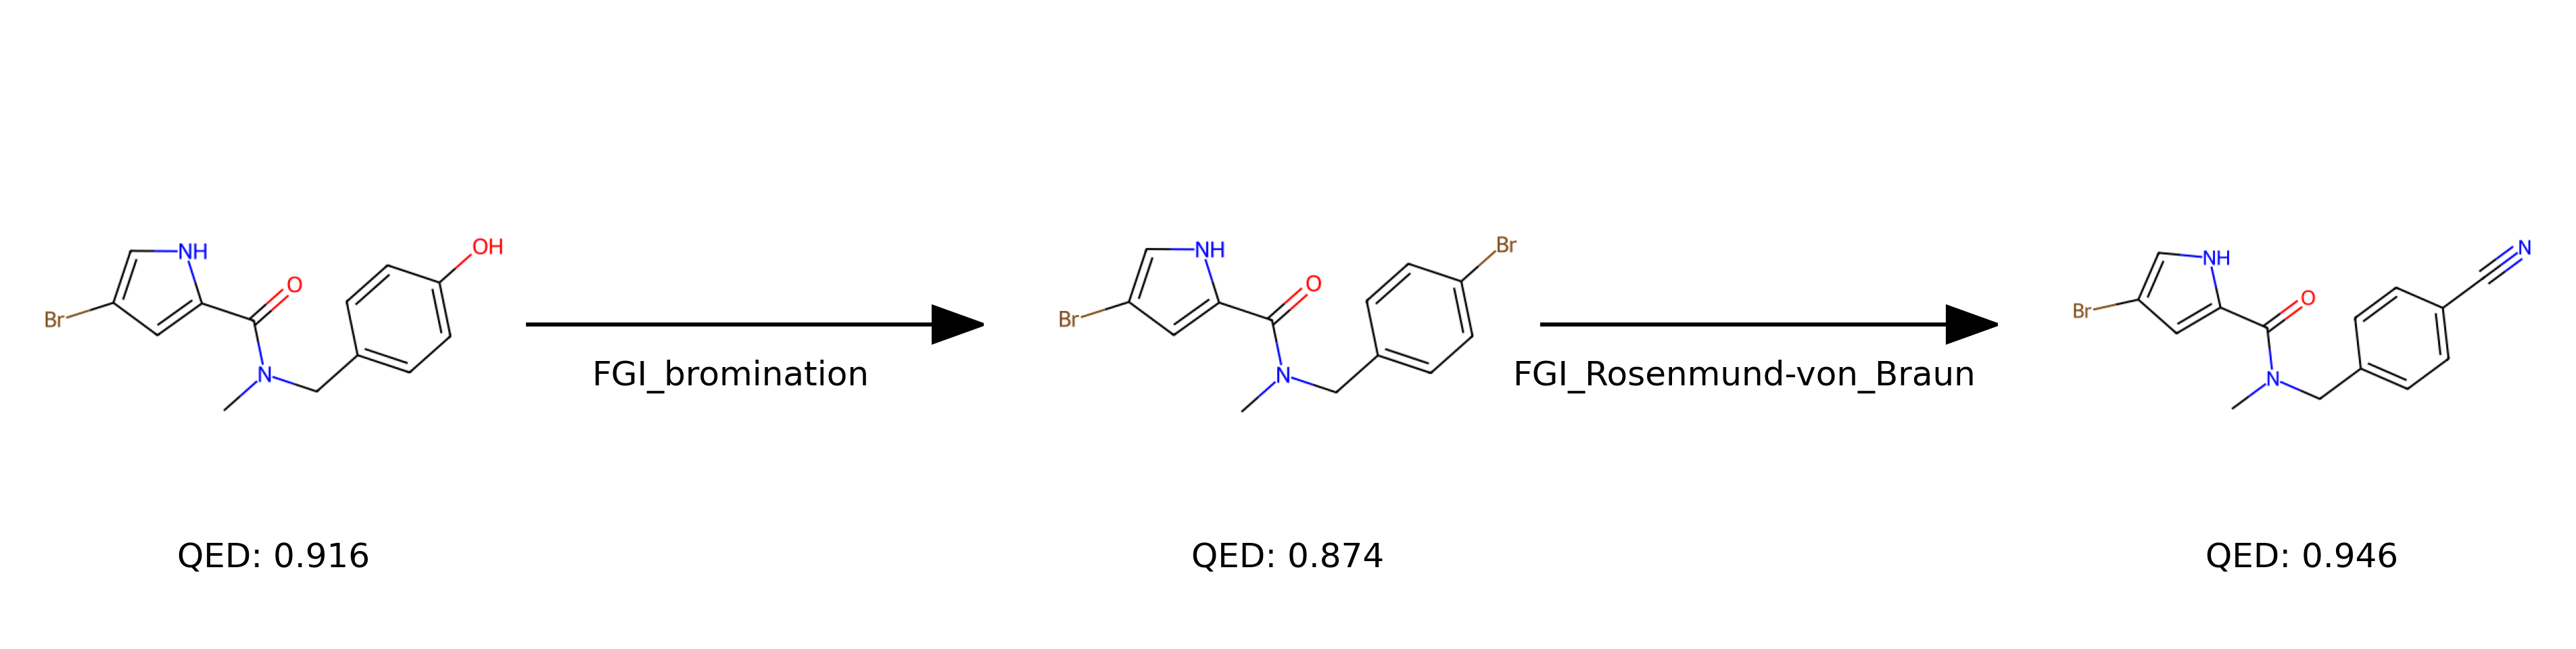

In [23]:
# synthesis path for molecule with highest qed
draw_path(greedysearch_results_uni, 1889)

In [24]:
# display path with max qed steps
print_path(greedysearch_results_uni, 1481)

Synthesis Path ID: 1481
Step 0:
  Reactant: COc1ccc(CC(CN)CO)cc1O | Name: 5-[2-(aminomethyl)-3-hydroxypropyl]-2-methoxyphenol
  Template: nan
  Product: COc1ccc(CC(CN)CO)cc1O | Name: 5-[2-(aminomethyl)-3-hydroxypropyl]-2-methoxyphenol
  QED Score: 0.663
----------------------------------------
Step 1:
  Reactant: COc1ccc(CC(CN)CO)cc1O | Name: 5-[2-(aminomethyl)-3-hydroxypropyl]-2-methoxyphenol
  Template: FGI_bromination
  Product: COc1ccc(CC(CN)CO)cc1Br | Name: 2-(aminomethyl)-3-(3-bromo-4-methoxyphenyl)propan-1-ol
  QED Score: 0.856
----------------------------------------
Step 2:
  Reactant: COc1ccc(CC(CN)CO)cc1Br | Name: 2-(aminomethyl)-3-(3-bromo-4-methoxyphenyl)propan-1-ol
  Template: FGI_bromination
  Product: COc1ccc(CC(CN)CBr)cc1Br | Name: Molecule not in PubChem Database
  QED Score: 0.839
----------------------------------------
Step 3:
  Reactant: COc1ccc(CC(CN)CBr)cc1Br | Name: Molecule not in PubChem Database
  Template: FGI_Rosenmund-von_Braun
  Product: COc1ccc(CC(CN)CB

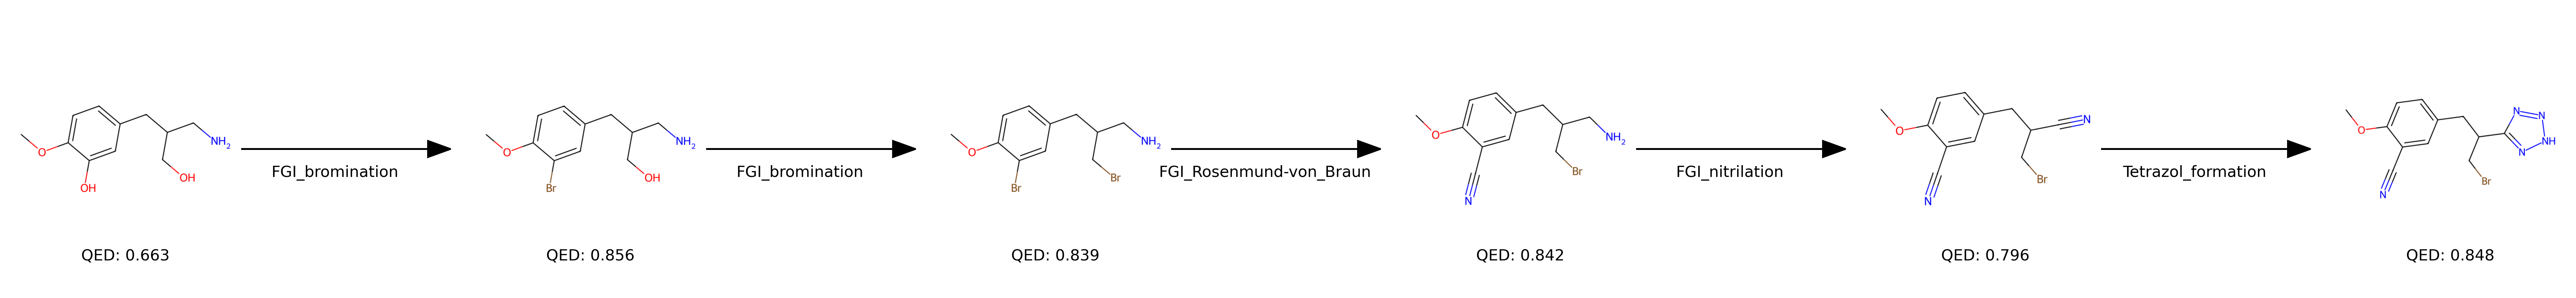

In [25]:
# synthesis path for molecule with highest qed
draw_path(greedysearch_results_uni, 1481)

## Data analysis

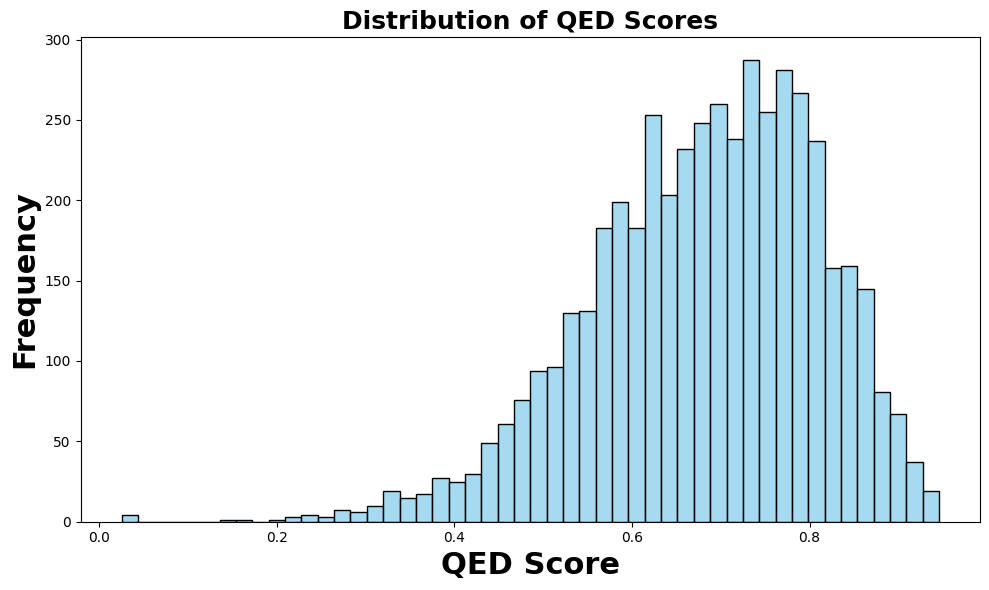

In [5]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(greedysearch_results_uni['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores (Greedy serach)', fontsize=18, fontweight='bold')
plt.xlabel('QED Score', fontsize=22, fontweight='bold')
plt.ylabel('Frequency', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

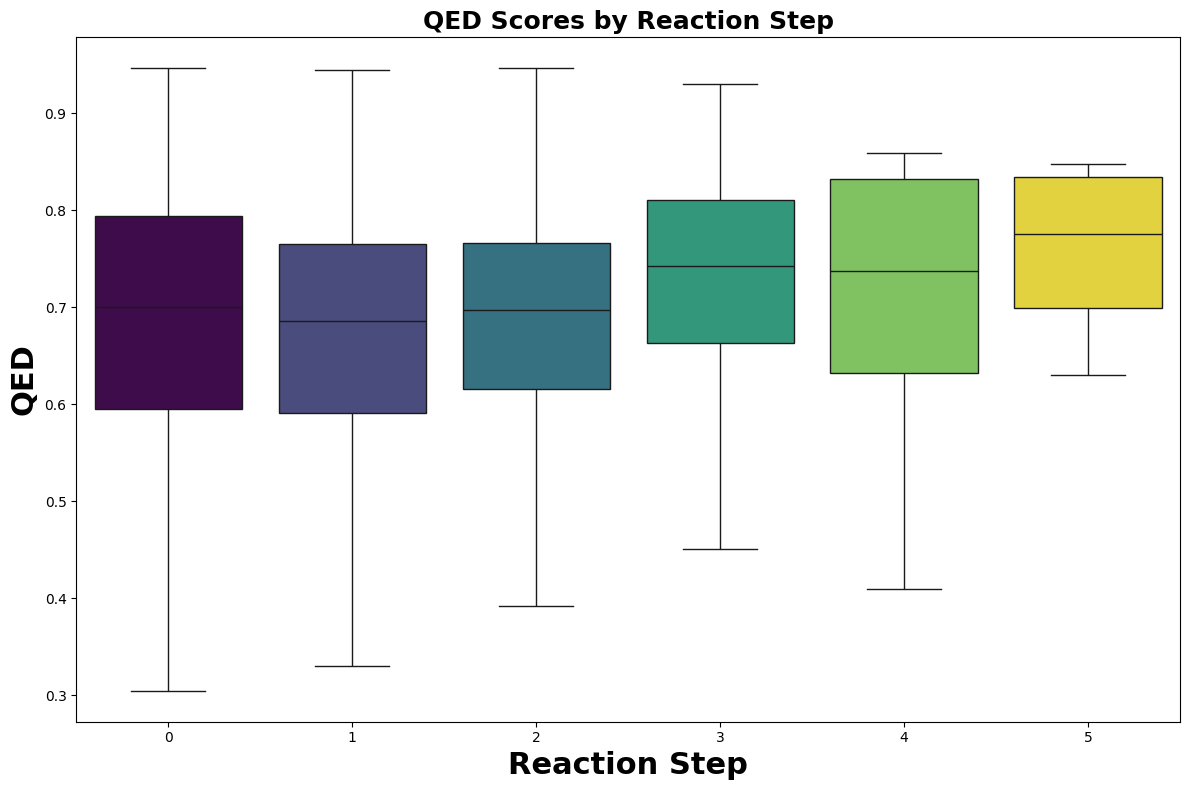

In [7]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=greedysearch_results_uni, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=22, fontweight='bold')
plt.ylabel('QED', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

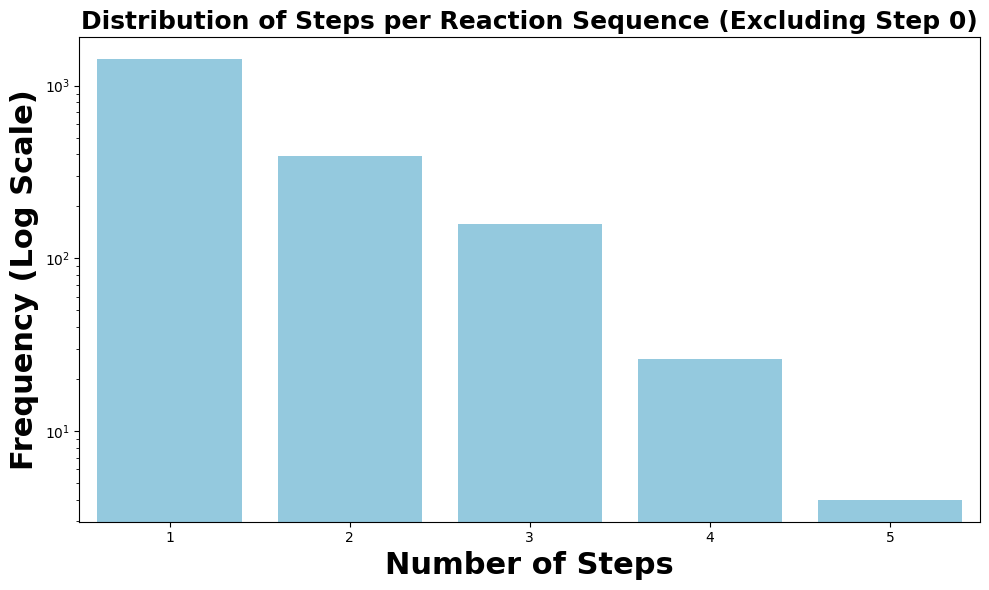

In [8]:
# Filter out step 0
df_filtered = greedysearch_results_uni[greedysearch_results_uni['step'] != 0]

# Calculate the number of steps per reaction sequence
steps_per_sequence = df_filtered.groupby('path_id')['step'].max()

# Calculate the frequency of each number of steps
steps_frequency = steps_per_sequence.value_counts().sort_index()

# Create a bar chart with log scale for frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=steps_frequency.index, y=steps_frequency.values, color='skyblue')
plt.yscale('log')
plt.title('Distribution of Steps per Reaction Sequence (Excluding Step 0)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Steps', fontsize=22, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# Random vs Greedy

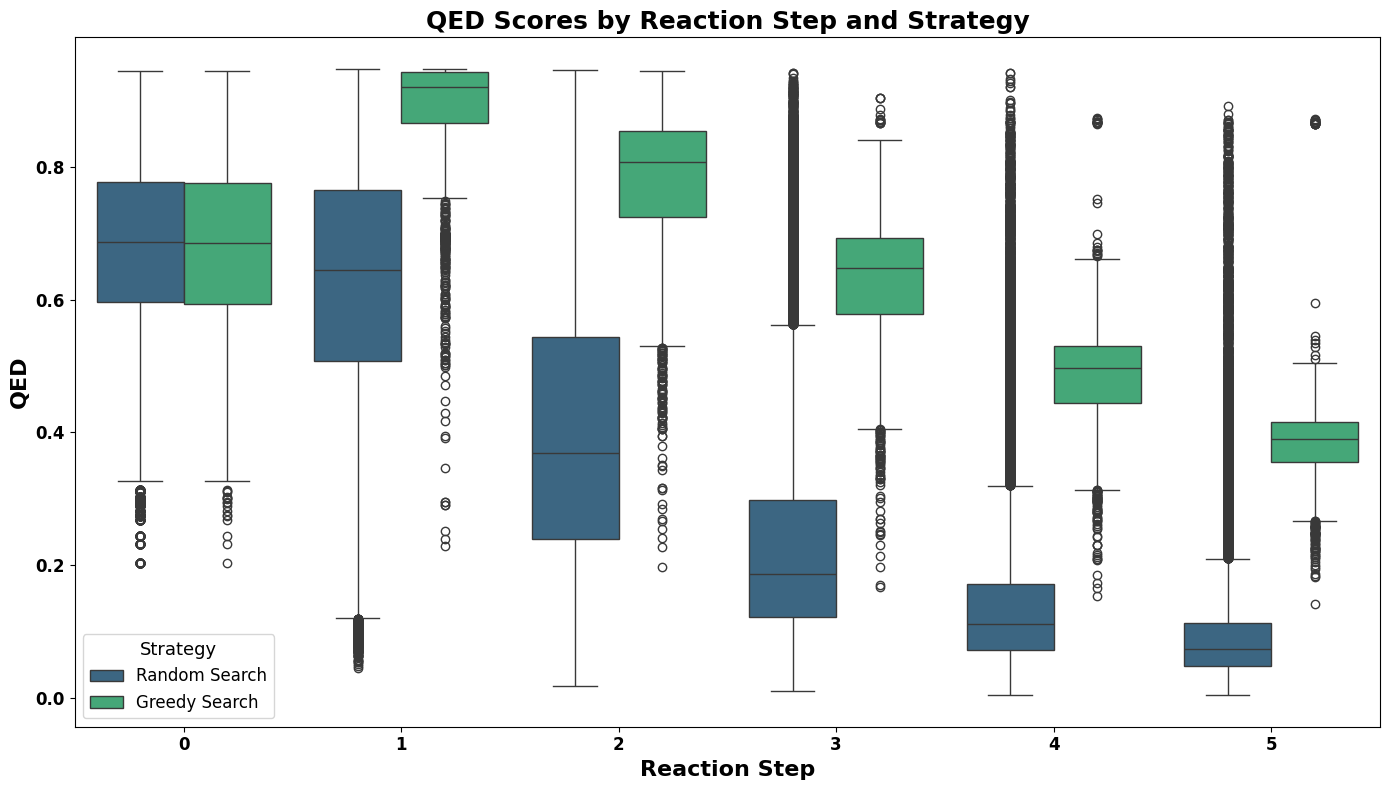

In [13]:
# Add a new column to indicate the search strategy
randomsearch_results_30['strategy'] = 'Random Search'
greedysearch_results['strategy'] = 'Greedy Search'

# Combine the data from both strategies
combined_results = pd.concat([randomsearch_results_30, greedysearch_results], ignore_index=True)

# Box plot for QED scores by reaction step and strategy
plt.figure(figsize=(14, 8))
sns.boxplot(x='step', y='qed', hue='strategy', data=combined_results, palette="viridis", showfliers=True, dodge=True)
plt.legend(title='Strategy', title_fontsize='13', fontsize='12')
plt.title('QED Scores by Reaction Step and Strategy', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=16, fontweight='bold')
plt.ylabel('QED', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Filter unimolecular templates and compatible reactants

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem, QED


def match_template(reactant, template):
    """Check if a reactant matches the reaction template."""
    try:
        reaction = AllChem.ReactionFromSmarts(template)  # type: ignore
        reactant_mol = Chem.MolFromSmiles(reactant)

        if reactant_mol is None:
            return {"first": False, "second": False}

        matches = {"first": False, "second": False}
        reactant1_template = reaction.GetReactantTemplate(0)
        matches["first"] = reactant_mol.HasSubstructMatch(
            reactant1_template, useChirality=True
        )

        if reaction.GetNumReactantTemplates() == 2:
            reactant2_template = reaction.GetReactantTemplate(1)
            matches["second"] = reactant_mol.HasSubstructMatch(
                reactant2_template, useChirality=True
            )

        return matches
    except Exception as e:
        print("Error in matching template: %s", e)
        return {"first": False, "second": False}

In [4]:
import pickle


def load_and_reset_unimolecular_templates(template_file):
    with open(template_file, "rb") as f:
        templates = pickle.load(f)

    # Filter to include only unimolecular templates
    unimolecular_templates = {
        k: v for k, v in templates.items() if v["type"] == "unimolecular"
    }

    # Reset the indices of unimolecular templates
    reset_unimolecular_templates = {
        i: v for i, (k, v) in enumerate(unimolecular_templates.items())
    }

    return reset_unimolecular_templates

In [5]:
def extract_unimolecular_reactants(reactant_file, templates):
    with open(reactant_file, "rb") as f:
        reactants= pickle.load(f)

    extracted_reactants = {}
    for k in reactants.keys():
        for t in templates.keys():
            if match_template(
                k, templates[t]["smarts"]
            )["first"]:
                fp = reactants[k]
                extracted_reactants[k] = fp

    return extracted_reactants

In [6]:
template_file = (
    "/rds/user/gtj21/hpc-work/designing-new-molecules/data/new_data/templates.pkl"
)
reactant_file = (
    "/rds/user/gtj21/hpc-work/designing-new-molecules/data/new_data/reactants_train.pkl"
)

In [7]:
unimolecular_templates = load_and_reset_unimolecular_templates(template_file)

In [6]:
len(unimolecular_templates)

15

In [15]:
unimolecular_reactants = extract_unimolecular_reactants(reactant_file, unimolecular_templates)

In [16]:
len(unimolecular_reactants)

990

In [17]:
file_path = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/new_data/unimolecular_reactants_val.pkl"
with open(file_path, "wb") as file:
    pickle.dump(unimolecular_reactants, file)

In [7]:
file_path = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/new_data/unimolecular_reactants_train.pkl"
with open(file_path, "rb") as f:
    reactants = pickle.load(f)

In [8]:
import pandas as pd

In [9]:
templates_df = pd.DataFrame(unimolecular_templates).T

In [10]:
len(reactants)

62455

In [11]:
def comp(smarts):
    count = 0
    for reactant in list(reactants.keys()):
        if match_template(
                reactant, smarts
            )["first"]:
            count +=1
    return count

In [12]:
templates_df["count"] = templates_df["smarts"].apply(comp)

In [16]:
templates_df

name  \
0       Bischler-Napieralski   
1                Pictet-Gams   
2     Aminothiazol_formation   
3   Chinonlin-2-one_Intramol   
4         Tetrazol_formation   
5           Dieckmann_5-ring   
6           Dieckmann_6-ring   
7          FGI_Acyl_chloride   
8            FGI_bromination   
9           FGI_chlorination   
10     FGI_sulfonyl_chloride   
11     FGA_alpha_bromination   
12    FGA_alpha_chlorination   
13   FGI_Rosenmund-von_Braun   
14           FGI_nitrilation   

                                               smarts          type  count  
0   [$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...  unimolecular    116  
1   [$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...  unimolecular      7  
2   [C$([CH]([Br,Cl,I])(C)([CX4])),C$([CH2]([Br,Cl...  unimolecular    607  
3   [C$(C(C)(=O)([CX4])),C$([CH](C)(=O)):10](=[O:1...  unimolecular     43  
4   [C$(C(#N)([CX4])),C$([CH](#N)):1]#[N:2]>>[c$(c...  unimolecular   2036  
5   [O$(O(C)([CX4])):8][C:7](=[O:9])[CH:6][C:5][C:...  unimolecular     13  
6   [O$(O(C)([CX4])):8][C:7](=[O:9])[CH:6][C:5][C:...  unimolecular     12  
7   [OH,O-:4]-[C$(C(=O)([OH,O-])([CX4])),C$([CH](=...  unimolecular  19553  
8                [OH:2]-[$([CX4]),c:1]>>[Br:3][C,c:1]  unimolecular  19848  
9                [OH:2]-[$([CX4]),c:1]>>[Cl:3][C,c:1]  unimolecular  19848  
10  [OH,O-:3][S$(S([CX4])):2](=[O:4])=[O:5]>>[Cl:6...  unimolecular     37  
11  [OH+0,O-:5]-[C:3](=[O:4])-[C$([CH]([CX4])),C$(...  unimolecular  16103  
12  [OH+0,O-:5]-[C:3](=[O:4])-[C$([CH]([CX4])),C$(...  unimolecular  16103  
13  [Cl,I,Br:7][c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[...  unimolecular  18300  
14  [OH,NH2,NH3+:3]-[CH2:2]-[C$(C([CX4,c])([CX4,c]...  unimolecular  16086

In [10]:
smiles = "NC(CO)C(O)c1ccc(F)c(F)c1"
mol = Chem.MolFromSmiles(smiles)

In [11]:
t = unimolecular_templates[8]["smarts"]
rxn = AllChem.ReactionFromSmarts(t)

In [13]:
ps = rxn.RunReactants((mol,))

In [14]:
ps

((<rdkit.Chem.rdchem.Mol at 0x150a740d61f0>,),
 (<rdkit.Chem.rdchem.Mol at 0x150a740d6180>,))

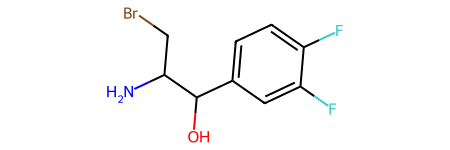

In [17]:
ps[0][0]

In [20]:
QED.qed(ps[0][0])

0.8181243962095504

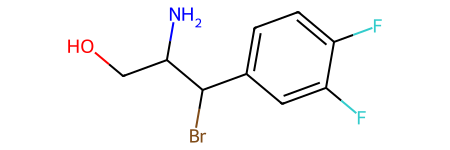

In [18]:
ps[1][0]

In [21]:
QED.qed(ps[1][0])

0.8181243962095504

In [23]:
for p in ps:
    for p in p:
        print(p)

In [29]:
corrected_ps = [prod for p in ps for prod in p if Chem.SanitizeMol(prod)]

In [32]:
Chem.SanitizeMol(ps[1][0])

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE